# One Genre To Rule Them All... Domestically

We work for a ["Big Five"](https://en.wikipedia.org/wiki/Major_film_studio#Present) Hollywood movie studio, and we're deciding which movies to make this year.

But the guys upstairs don't want to go through the hassle of reading a bunch of scripts and sitting through a lot of meetings.

They just want to know which genre has the best chance of succeeding.

That's where we come in.

Our goal, should we choose to accept it, or be forced into it by powerful people who write our checks, is to analyze domestic movies by genre and determine which ones seem the most promising.

So let's get to it!

# The Domestic Market

We'll be using the movie data from the `Data_Cleaning` notebook. If you haven't had a chance to check it out, it's a collection of movies from [The Numbers](https://www.the-numbers.com/) and [Box Office Mojo](https://www.boxofficemojo.com/), two great sources of movie information. As a reminder, all monetary data has been converted to 2018 dollars to normalize them.

**We only care about the domestic box office for this study.** Yes, increasingly movies are being released worldwide, but we want to first judge a movie's chances in the domestic market. Who knows, maybe a worldwide analysis will take place at another time (or notebook... in this repository... nudge nudge).

Here are the steps we will use to accomplish our task:
- Decide which genres to consider in our analysis.
 
- Decide on a profitability measure.

- Whittle our dataset down to movies released by the Big Five. This is to control for factors like lack of budget or marketing affecting a movie's success. Sure, independent movies can succeed, but our bosses want to see how the genres performed with all the help of a studio behind them.

- Analyze the historical performance of the genres by decade. There might be some trends over time that would be useful to know.

- Analyze the historical performance of the genres by release week. Maybe certain genres perform better at certain times of year.

- Hopefully, give our bosses actionable insight!

# Deciding on Genres

According to [The Numbers](https://www.the-numbers.com/market/), the top six genres in terms of box office gross are:
- Adventure
- Action
- Drama
- Comedy
- Thriller/Suspense
- Horror

Our bosses like making money.

Sold.

# Is This Movie Profitable? 

The toughest question out there. Hollywood studios are notorious for phony accounting, cough cough [Harry Potter and the Order of the Phoenix](https://deadline.com/2010/07/studio-shame-even-harry-potter-pic-loses-money-because-of-warner-bros-phony-baloney-accounting-51886/).

Not our bosses though. They're great. Real... stand up... people.

Anyway, we must decide on a measure for how "successful" a movie is.

For simplicity, we will judge a movie as a success if it breaks even. The reason is that there are additional revenue streams for movies beyond the theaters. There's TV airings, rentals, DVD sales, merchandise, theme park rides, spinoff TV shows, sequels, etc. 


## How much do studios spend on movies?

Well, there's the production budget. We can either get that information or we can't.

Then there's the second biggest expense: marketing. But it's difficult to know the marketing costs of movies. An article at [How Stuff Works](https://entertainment.howstuffworks.com/movie-cost1.htm) cites that marketing spend is typically around 50% of the production budget of a movie.

## How much do studios make from the domestic box office?

According to this article on [The Week](https://theweek.com/articles/647394/when-buy-movie-ticket-where-does-that-money), movie studios only end up with about 50% of the total domestic box office. Movie theaters get the other half. 


## Breakeven Point

The breakeven point is where total earnings equal total expenses: **(Domestic Box Office / 2) = (1.5 * Production Budget)**

Or, to simplify: **Domestic Box Office = 3 * Production Budget**

At the point where the domestic box office has earned three times the original production budget (or two times its production budget when adjusted for marketing costs), we shall say the movie has broken even.

This explains why we have created a column called `domestic_breakeven` that performs this calculation to classify our movies. 

## Profits Equation

We derive our profits equation from the breakeven equation, as profits are what remain after subtracting expenses from earnings.

**Profit = (Domestic Box Office / 2) - (1.5 * Production Budget)**

If the result is 0, the movie broke even.
<br>
If the result is positive, the movie made money.
<br>
If the result is negative, the movie lost money.

This explains why we have created a column called `profit` that performs this calculation to determine the amount of profit/loss each movie made.

# Curate our dataset

In this section of the notebook, we:
- 5.1 Import the code libraries we need for our analysis.
- 5.2 Import our dataset and clean it up a bit.
- 5.3 Filter our dataset to contain only the movies produced by the Big 5 Studios.
- 5.4 Remove all movies produced before 1970 to simplify our analysis. We do this because we do not have many movies from before 1970, and we don't want to draw conclusions based on very limited data.
- 5.5 Summarize what our dataset looks like after these changes.

## Import libraries and settings

We import a few libaries and set some global Jupyter notebook settings.

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# For creating colormaps
import matplotlib.cm as cm

plt.style.use('fivethirtyeight')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import data

We import the data and create a few columns we will use in our analysis.

Columns we are adding:
<br>
`release_decade` - We calculate the decade a movie was released using its release year.
<br><br>
`domestic_breakeven` - This is a boolean column (i.e. either True or False) based on whether the movie broke even according to our Profitability Equation.
<br><br>
`profit` - This is a numerical column that calculates the amount of profit a movie earned. We take the amount of domestic box office dollars it earned, divide it by 2, and then then subtract away 1.5 times its production budget. Any money left over is profit.
<br><br>
`action`, `adventure`, `comedy`, `drama`, `horror`, `thriller_suspense` - These columns are boolean columns (i.e. either True or False) that convey whether the movie in question is of the corresponding genre. For example, if a movie has the genre Comedy Drama, it will have a True value in both the `comedy` and `drama` column. This is very useful for separating our dataset by genre for graphing purposes. 

In [2]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'], usecols=['title', 'distributor_mojo', 'domestic_adj', 'budget_adj',  'genres_mojo', 'release_year', 'release_week', 'release_date'])

# Only look at movies that made money domestically
data = data[data['domestic_adj'].notna() & data['domestic_adj'] > 0]

# Only look at movies with budget information
data = data[data['budget_adj'].notna()]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

# For profit analysis
data['profit'] = (data['domestic_adj'] / 2) - (1.5 * data['budget_adj'])

# Create columns for genres
# A movie can have multiple genres. If so, we will count them for all the genres its classified with.
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)

# Remove rows that don't contain one of our genres
data = data[data['action'] | data['adventure'] | data['comedy'] | data['drama'] | data['horror'] | data['thriller_suspense']]

# Create dataframes for the genres
#action = data[data['genres_mojo'].str.contains('Action', na=False)]
#adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
#comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
#drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
#horror = data[data['genres_mojo'].str.contains('Horror', na=False)]
#thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3945 entries, 20 to 19775
Data columns (total 17 columns):
title                 3945 non-null object
release_year          3945 non-null int64
distributor_mojo      3945 non-null object
genres_mojo           3945 non-null object
release_date          3945 non-null datetime64[ns]
domestic_adj          3945 non-null float64
budget_adj            3945 non-null float64
release_week          3945 non-null int64
release_decade        3945 non-null int64
domestic_breakeven    3945 non-null bool
profit                3945 non-null float64
action                3945 non-null bool
adventure             3945 non-null bool
comedy                3945 non-null bool
drama                 3945 non-null bool
horror                3945 non-null bool
thriller_suspense     3945 non-null bool
dtypes: bool(7), datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 366.0+ KB


## Organize By Distributors

The [Big Five](https://en.wikipedia.org/wiki/Major_film_studio#Past) studios we will use in our analysis are:
- Universal
- Paramount
- Warner Bros.
- Disney
- Sony

Studios have come and gone a lot historically. They get bought out by competitors, or go out of business. A lot of messy stuff.

To simplify, we will categorize a movie by its current studio owner. So for example, Disney [recently purchased](https://theweek.com/speedreads/780191/disney-buys-21st-century-fox-713-billion) 20th Century Fox. So we will categorize a 20th Century Fox movie as Disney.

In [4]:
data[data['budget_adj'].notna() & data['distributor_mojo'].notna()]['distributor_mojo'].value_counts()

Warner Bros.                        367
Universal                           364
Fox                                 309
Paramount                           283
Sony / Columbia                     272
Buena Vista                         234
New Line                            127
Miramax                             121
Fox Searchlight                     107
Lionsgate                           104
MGM                                 102
Sony Classics                        81
Sony / Screen Gems                   69
Focus Features                       64
Columbia                             53
Weinstein Company                    49
Warner Bros. (New Line)              49
IFC                                  47
United Artists                       44
Lions Gate                           44
DreamWorks                           42
Magnolia                             41
TriStar                              37
Roadside Attractions                 35
Sony (Revolution)                    30


In [5]:
# Create a regex string to combine movies into their respective distributor
# https://en.wikipedia.org/wiki/Major_film_studio#Past
nbcuniversal = 'Universal|Focus Features|Focus World|Gramercy|Working Title|Big Idea|DreamWorks$|Illumination|Carnival|Mac Guff|United International'

print(data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Universal         364
Focus Features     64
DreamWorks         42
Gramercy           14
Focus World         3
Name: distributor_mojo, dtype: int64
Sum: 487


In [6]:
viacom = 'Paramount|BET|Comedy Central|MTV|Nickelodeon|Bardel Entertainment|MTV Animation|Nickelodeon Animation Studio|Awesomeness|CMT|Melange|United International Pictures|VH1|Viacom 18 Motion Pictures'

print(data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(viacom, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Paramount                 283
Paramount (DreamWorks)     18
Paramount Vantage          15
Paramount Classics         10
Paramount Insurge           2
Name: distributor_mojo, dtype: int64
Sum: 328


In [7]:
warnermedia = 'Warner Bros.|CNN Films|HBO|DC Films|New Line|Cartoon Network Studios|Wang Film Productions|Adult Swim Films|Castle Rock Entertainment|Cinemax|Flagship|Fullscreen|Hello Sunshine|Spyglass'

print(data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Warner Bros.               367
New Line                   127
Warner Bros. (New Line)     49
Name: distributor_mojo, dtype: int64
Sum: 543


In [8]:
disney = 'Walt Disney|^Fox$|Fox Atomic|A&E|Disneynature|ESPN|Fox Searchlight|Hulu|National Geographic|VICE|Fox Family|Lucasfilm|Marvel|The Muppets Studio|UTV Motion Pictures|20th Century Fox Animation|Blue Sky Studios|Lucasfilm Animation|Marvel Animation|Pixar Animation Studios|Buena Vista|Disney|Dragonfly Film Productions|Fox Star Studios|Fox Studios Australia|Kudos Film|New Regency|Patagonik Film Group|Shine Group|Tiger Aspect Productions|Zero Day Fox'

print(data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(disney, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Fox                309
Buena Vista        234
Fox Searchlight    107
Fox Atomic           3
Disney               1
Name: distributor_mojo, dtype: int64
Sum: 654


In [9]:
sony = 'Sony|Columbia|Affirm|Screen Gems|Stage 6|Ghost Corps|Funimation|Madhouse|Manga Entertainment UK|TriStar|Destination Films|Left Bank Pictures|Triumph Films'

print(data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts())
print('Sum:', data[data['distributor_mojo'].str.contains(sony, na=False, regex=True)]['distributor_mojo'].value_counts().sum())

Sony / Columbia        272
Sony Classics           81
Sony / Screen Gems      69
Columbia                53
TriStar                 37
Sony (Revolution)       30
Sony / AFFIRM Films      2
Name: distributor_mojo, dtype: int64
Sum: 544


In [10]:
data['universal'] = data['distributor_mojo'].str.contains(nbcuniversal, na=False, regex=True)
data['paramount'] = data['distributor_mojo'].str.contains(viacom, na=False, regex=True)
data['warner'] = data['distributor_mojo'].str.contains(warnermedia, na=False, regex=True)
data['disney'] = data['distributor_mojo'].str.contains(disney, na=False, regex=True)
data['sony'] = data['distributor_mojo'].str.contains(sony, na=False, regex=True)
data['distributor'] = np.nan

In [11]:
data.loc[data['universal'], 'distributor'] = 'Universal'
data.loc[data['paramount'], 'distributor'] = 'Paramount'
data.loc[data['warner'], 'distributor'] = 'Warner'
data.loc[data['disney'], 'distributor'] = 'Disney'
data.loc[data['sony'], 'distributor'] = 'Sony'

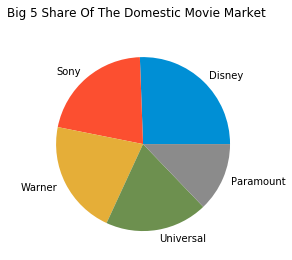

In [12]:
# We only want to keep rows that have one of the Big Five
data = data[data['distributor'].notna()]

figure, axis = plt.subplots()
figure.suptitle('Big 5 Share Of The Domestic Movie Market')

data['distributor'].value_counts().plot(kind='pie')
axis.set_ylabel('');

## Check Movies By Decade

We have very few movies from before the 1970s. We will remove these entries to simplify our analysis.

In [13]:
data['release_decade'].value_counts()

2000    1047
2010     744
1990     568
1980     128
1970      44
1960      12
1950       9
1930       3
1940       1
Name: release_decade, dtype: int64

In [14]:
data = data[data['release_decade'] >= 1970]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 20 to 19775
Data columns (total 23 columns):
title                 2531 non-null object
release_year          2531 non-null int64
distributor_mojo      2531 non-null object
genres_mojo           2531 non-null object
release_date          2531 non-null datetime64[ns]
domestic_adj          2531 non-null float64
budget_adj            2531 non-null float64
release_week          2531 non-null int64
release_decade        2531 non-null int64
domestic_breakeven    2531 non-null bool
profit                2531 non-null float64
action                2531 non-null bool
adventure             2531 non-null bool
comedy                2531 non-null bool
drama                 2531 non-null bool
horror                2531 non-null bool
thriller_suspense     2531 non-null bool
universal             2531 non-null bool
paramount             2531 non-null bool
warner                2531 non-null bool
disney                2531 non-null bool
so

## Summary

Our filtered dataset now has 2,531 entries.

The movie studios all have a fair chunk of the dataset. This will hopefully prevent bias stemming from lack of equitable market share.

We have no missing values, so we can do all monetary calculations safely. 

# Create Graphing Helper Function and Reusable Lists

In this section of the notebook, we:
  - Create the function **autolabel** that adds numbers to our bar graphs showing what the value of each bar height is. We use this for graphs where it might otherwise be difficult to tell what the values are.
  - Create the function **generate_color_list** that calculates a list of colors depending on the order of the genres for a particular chart. Because we want each genre to be associated with a specific color, this step allows us to show charts with the genres in different orders other than alphabetical and still be easily interpretable.

In [15]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html

# Function to add counts/percentages to bar plots
def autolabel(axis, num_decimals=0, counts=None, fontsize=20):
    """
    Attach a text label above each bar displaying its height.
    If sent a list of counts, display those instead.
    """
    for i, val in enumerate(axis.patches):
        if counts is not None:
            height = counts[i]
        else:
            height = round(val.get_height(), num_decimals) if num_decimals > 0 else int(round(val.get_height(), 0))
        
        # We don't want to display zeros on our bar plots
        if (height == 0) or pd.isnull(height):
            continue
            
        # Put the count below a negative value bar
        if height < 0:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*0.95, '{}'.format(height), ha='center', va='bottom', fontsize=fontsize)
        else:
            axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '{}'.format(height), ha='center', va='bottom', fontsize=fontsize)

In [16]:
# Create custom function to generate the color list when graphing
def generate_color_list(colors_needed=1, order_list=['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']):
    colors_available = ['color1', 'color2', 'color3']
    c_list = []
    
    # Matplotlib needs a list of colors if the graph doesn't have multiple columns per index
    if colors_needed == 1:
        c_list = [genres_dict[genre][colors_available[0]] for genre in order_list]
        return c_list
    
    # Matplotlib needs a list of tuples if the graph has multiple columns per index
    for i in range(colors_needed):
        temp_tuple = tuple([genres_dict[genre][colors_available[i]] for genre in order_list])
        c_list.append(temp_tuple)
        
    return c_list

# Create Summary DataFrame

In this section of the notebook, we:
  - Create a list containing the genres and lists containing the colors associated with them.
  - Create a dictionary to store individual colors and a colormap to each genre. This is useful if we need to plot multiple values per genre. For example, if we want to plot a mean and median value for each genre, we need two distinct colors per genre. Rather than set these up manually each time, a dictionary will let us access these values easily.   
  - Create a summary dataframe containing useful stats for our genres. This dataframe will allow graphing some simple charts.

In [17]:
# Create lists of useful information for graphing
genres = ['action', 'adventure', 'comedy', 'drama', 'horror', 'thriller_suspense']
colors = ['#008FD5', '#FC4F30', '#E5AE38', '#6D904F', '#8B8B8B', '#810F7C']
colors2 = ['#87C7E5', '#F4BAB0', '#F4DBA8', '#C7E2AE', '#D6D1D1', '#CE8EDB']
colors3 = ['#C5E7F7', '#F4D7D2', '#F9ECD1', '#E3F2D5', '#EAE8E8', '#ECC8F4']

# Create a dictionary holding the colors for each genre
genres_dict = {
    'action': {'color1': '#008FD5', 'color2': '#87C7E5', 'color3': '#C5E7F7', 'colormap': 'Blues'},
    'adventure': {'color1': '#FC4F30', 'color2': '#F4BAB0', 'color3': '#F4D7D2', 'colormap': 'Oranges'},
    'comedy': {'color1': '#E5AE38', 'color2': '#F4DBA8', 'color3': '#F9ECD1', 'colormap': 'Reds'},
    'drama': {'color1': '#6D904F', 'color2': '#C7E2AE', 'color3': '#E3F2D5', 'colormap': 'Greens'},
    'horror': {'color1': '#8B8B8B', 'color2': '#D6D1D1', 'color3': '#EAE8E8', 'colormap': 'Greys'},
    'thriller_suspense': {'color1': '#810F7C', 'color2':  '#CE8EDB', 'color3': '#ECC8F4', 'colormap': 'Purples'}
    }

# Create a summary statistics dataframe separated by genre to make graphing easier
# The columns are:
# Number of movies
# Average gross
# All-time gross
# Average budget
# All-time budget
# Dollar earned for dollar spent (including marketing -- adjusted budget is 1.5 times original budget)
# Median dollars earned for dollars spent
# Mean dollars earned for dollars spent
# Median profit
# Mean profit
# All-time profit
# Breakeven percentage
# Current decade (2010s) median profit
# Current decade (2010s) mean profit
# Current decade (2010s) all profit
# Current decade (2010s) breakeven percentage

aggregation_stats_per_genre = {
    'num_movies': [data[genre].sum() for genre in genres],
    'avg_gross': [round(data[data[genre]]['domestic_adj'].mean() / 1000000, 1) for genre in genres],
    'median_gross': [round(data[data[genre]]['domestic_adj'].median() / 1000000, 1) for genre in genres], 
    'all_time_gross': [round(data[data[genre]]['domestic_adj'].sum() / 1000000000, 1) for genre in genres],
    'avg_budget': [round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres],
    'median_budget': [round(data[data[genre]]['budget_adj'].median() / 1000000, 1) for genre in genres],
    'all_time_budget': [round(data[data[genre]]['budget_adj'].sum() / 1000000000, 1) for genre in genres],
    'dollars_earned_for_dollars_spent': [round((data[data[genre]]['domestic_adj'].sum() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].sum() / 1000000), 1) for genre in genres],
    'median_dollars_earned_for_dollars_spent': [round((data[data[genre]]['domestic_adj'].median() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].median() / 1000000), 1) for genre in genres],
    'mean_dollars_earned_for_dollars_spent': [round((data[data[genre]]['domestic_adj'].mean() / 2000000) / (1.5 * data[data[genre]]['budget_adj'].mean() / 1000000), 1) for genre in genres],
    'median_profit': [round((data[data[genre]]['profit'].median() / 1000000), 1) for genre in genres],
    'mean_profit': [round((data[data[genre]]['profit'].mean() / 1000000), 1) for genre in genres],
    'all_time_profit': [round(data[data[genre]]['profit'].sum() / 1000000000, 1) for genre in genres],
    'breakeven_percentage': [round(data[data[genre]]['domestic_breakeven'].sum() / data[data[genre]]['domestic_breakeven'].count() * 100, 1) for genre in genres],
    'current_decade_median_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].median() / 1000000), 1) for genre in genres],
    'current_decade_mean_profit': [round((data[(data[genre]) & (data['release_year'] >=2010)]['profit'].mean() / 1000000), 1) for genre in genres],
    'current_decade_profit': [round(data[(data[genre]) & (data['release_year'] >=2010)]['profit'].sum() / 1000000000, 1) for genre in genres],
    'current_decade_breakeven_percentage': [round(data[(data[genre]) & (data['release_year'] >=2010)]['domestic_breakeven'].mean() * 100, 1) for genre in genres]
}

In [18]:
summary = pd.DataFrame(aggregation_stats_per_genre, index=genres)
summary

num_movies  avg_gross  median_gross  all_time_gross  \
action                    493      131.3          86.6            64.7   
adventure                 260      166.9         105.5            43.4   
comedy                    995       75.9          48.5            75.5   
drama                     680       59.0          37.2            40.1   
horror                    258       89.5          53.3            23.1   
thriller_suspense         363       75.6          46.2            27.4   

                   avg_budget  median_budget  all_time_budget  \
action                  101.1           87.5             49.9   
adventure               121.8          117.1             31.7   
comedy                   45.3           35.9             45.1   
drama                    40.8           30.5             27.7   
horror                   43.9           31.1             11.3   
thriller_suspense        56.5           52.3             20.5   

                   dollars_earned_for_dollars_spent  \
action                                          0.4   
adventure                                       0.5   
comedy                                          0.6   
drama                                           0.5   
horror                                          0.7   
thriller_suspense                               0.4   

                   median_dollars_earned_for_dollars_spent  \
action                                                 0.3   
adventure                                              0.3   
comedy                                                 0.5   
drama                                                  0.4   
horror                                                 0.6   
thriller_suspense                                      0.3   

                   mean_dollars_earned_for_dollars_spent  median_profit  \
action                                               0.4          -79.7   
adventure                                            0.5          -96.5   
comedy                                               0.6          -25.5   
drama                                                0.5          -23.2   
horror                                               0.7          -19.3   
thriller_suspense                                    0.4          -43.5   

                   mean_profit  all_time_profit  breakeven_percentage  \
action                   -86.1            -42.4                   9.5   
adventure                -99.3            -25.8                   8.5   
comedy                   -30.1            -29.9                  19.5   
drama                    -31.6            -21.5                  19.4   
horror                   -21.2             -5.5                  27.9   
thriller_suspense        -46.9            -17.0                  12.7   

                   current_decade_median_profit  current_decade_mean_profit  \
action                                   -104.3                      -105.4   
adventure                                -137.4                      -133.7   
comedy                                    -21.9                       -31.0   
drama                                     -15.3                       -23.9   
horror                                     -6.2                       -16.0   
thriller_suspense                         -31.3                       -37.0   

                   current_decade_profit  current_decade_breakeven_percentage  
action                             -18.6                                  7.4  
adventure                          -11.9                                  3.4  
comedy                              -8.1                                 16.9  
drama                               -5.3                                 19.5  
horror                              -1.2                                 41.9  
thriller_suspense                   -3.4                                 18.3

# Bird's Eye View Of The Data

In this section of the notebook, we want to get a broad overview of the entire dataset.

- 8.1 Look at the number of movies released in each genre for our entire dataset (spanning 1970 - 2018).
- 8.2 Look at how much money our movies have earned at the domestic box office. This is a histogram that separates our movies into groups at increments of 50 million dollars. For example, a movie that grossed 67 million dollars would be in the 50-100 million bucket.
- 8.3 Look at how much our movies cost to produce. This is a histograph separating our movies into groups based on their production budgets in increments of 10 million dollars.
- 8.4 Look at how much our movies have profited or lost. This is a histogram separating our movies into groups based on their profits in increments of 25 million dollars. The chart starts at -575 million dollars to account for our biggest losing movie (The 13th Warrior with a loss of -551,351,843 dollars)
- 8.5 Summarize our findings.

## Number Of Movies

In [19]:
# Create custom function to make bar graphs with our summary dataframe
def plot_summary_dataframe(summary, sort_column, plot_columns, title, colors_needed=1, legend_needed=False, legend_text=[], y_label='Millions', num_decimals=0):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle(title, fontsize=20, y=1.02)

    summary.sort_values(sort_column, ascending=False, inplace=True)

    color_list = generate_color_list(colors_needed=colors_needed, order_list=summary.index)

    summary.plot(y=plot_columns, kind='bar', ax=axis, color=color_list, legend=legend_needed)
    axis.set_ylabel(y_label, fontsize=20)
    axis.set_xlabel('')
    axis.tick_params(labelsize=20)
    
    if legend_needed:
        axis.legend(legend_text, fontsize=20)
        
    autolabel(axis, num_decimals=num_decimals)

    plt.tight_layout()

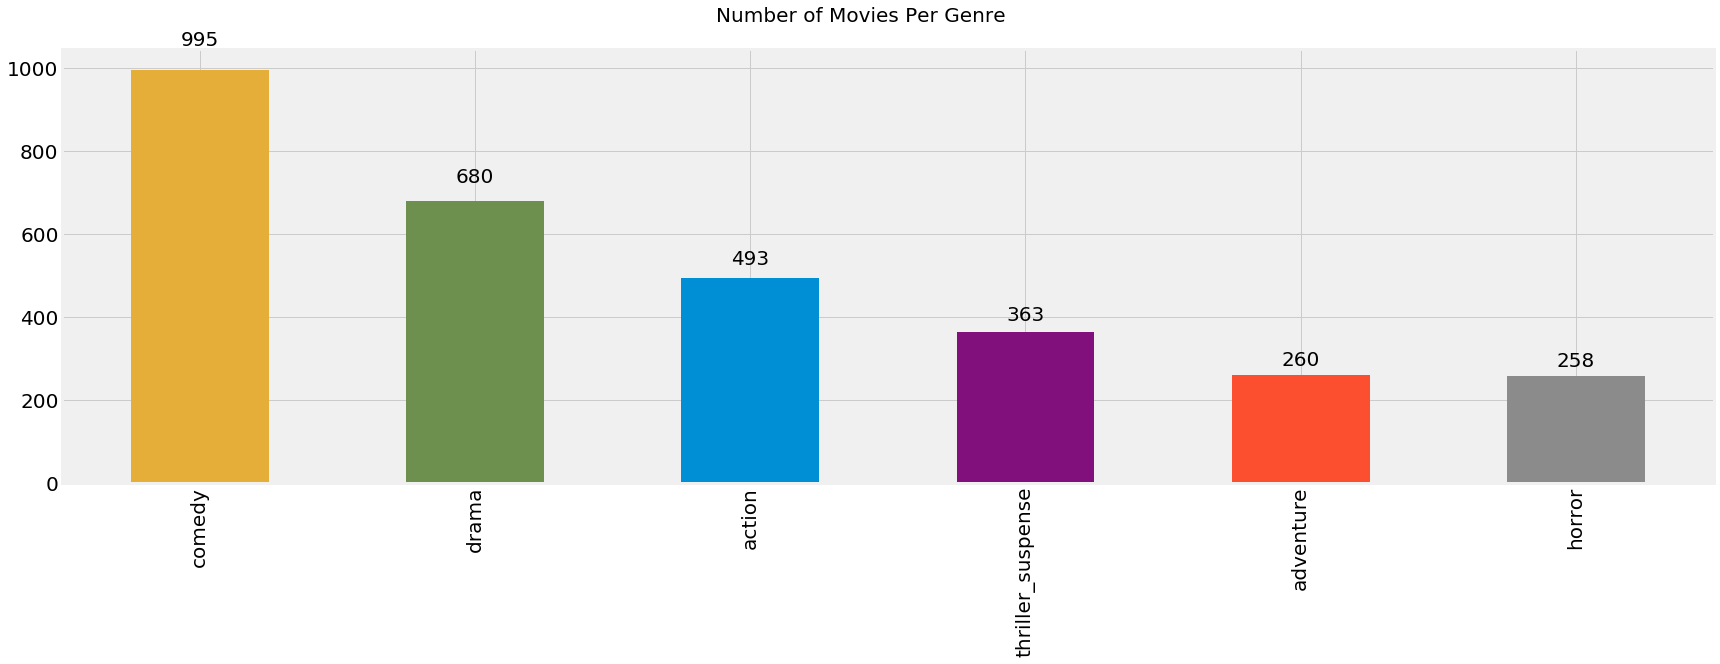

In [20]:
plot_summary_dataframe(summary=summary, sort_column='num_movies', plot_columns='num_movies', 
                       title='Number of Movies Per Genre', colors_needed=1, legend_needed=False, legend_text=[], y_label='', num_decimals=0)

## Grosses

Let's start with some exploratory data analysis looking at the big picture.

Here, we look at overall trends of how much money the movies in our dataset have earned at the worldwide box office.

In [21]:
# Create custom function to plot different aggregate statistics as histograms
def plot_aggregate_histogram(data, stat, title, bins=10, color=genres_dict['action']['color2']):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
    figure.suptitle(title, fontsize=20)

    (data[stat] / 1000000).plot.hist(bins=bins, ax=axis, fontsize=20, color=color)
    axis.set_xlabel('Millions of Dollars', fontsize=20)
    axis.set_ylabel('Number of Movies', fontsize=20)
    axis.axvline(data[stat].median() / 1000000, color='k', linewidth=1)
    axis.axvline(data[stat].mean() / 1000000, color='r', linewidth=1)
    axis.legend(['Median: {:.1f} million'.format(data[stat].median() / 1000000), 'Mean: {:.1f} million'.format(data[stat].mean() / 1000000)], fontsize=20)

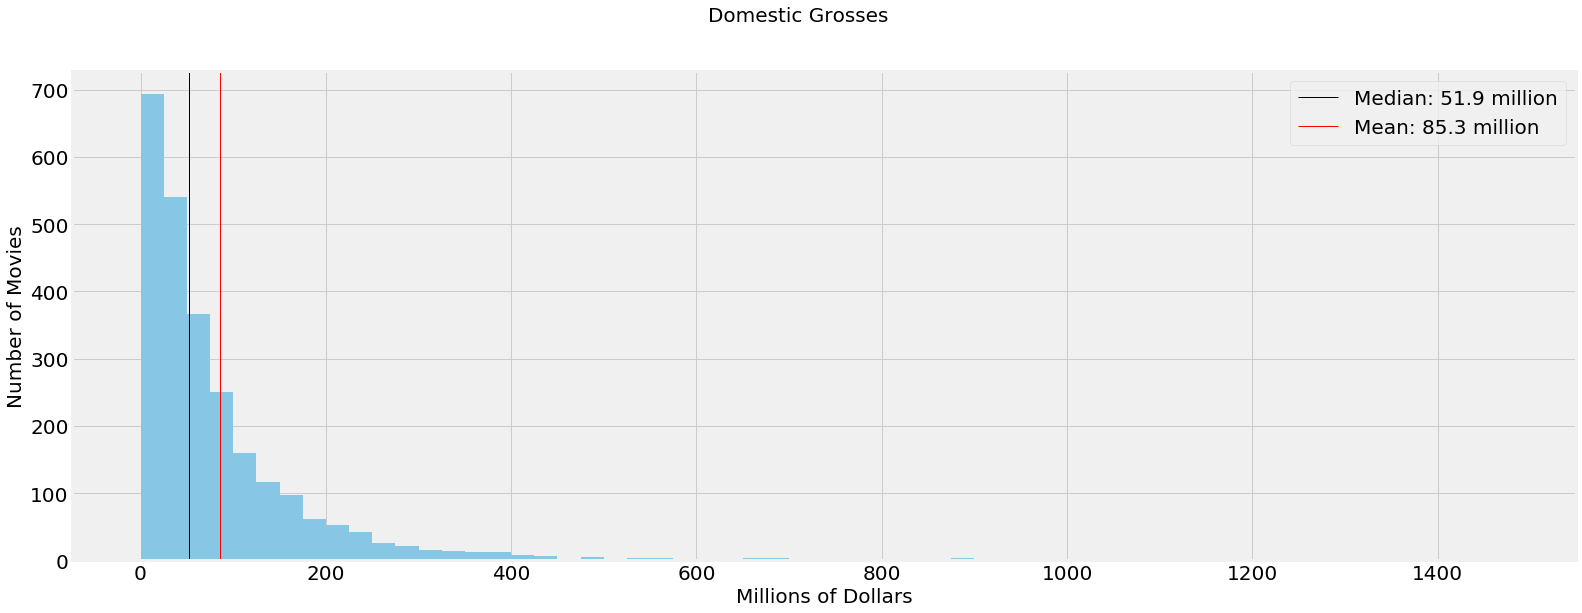

In [22]:
plot_aggregate_histogram(data=data, stat='domestic_adj', title='Domestic Grosses', 
                         bins=range(0, 1500, 25), color=genres_dict['action']['color2'])

## Budgets

Here, we look at overall trends for production budgets for the movies in our dataset.

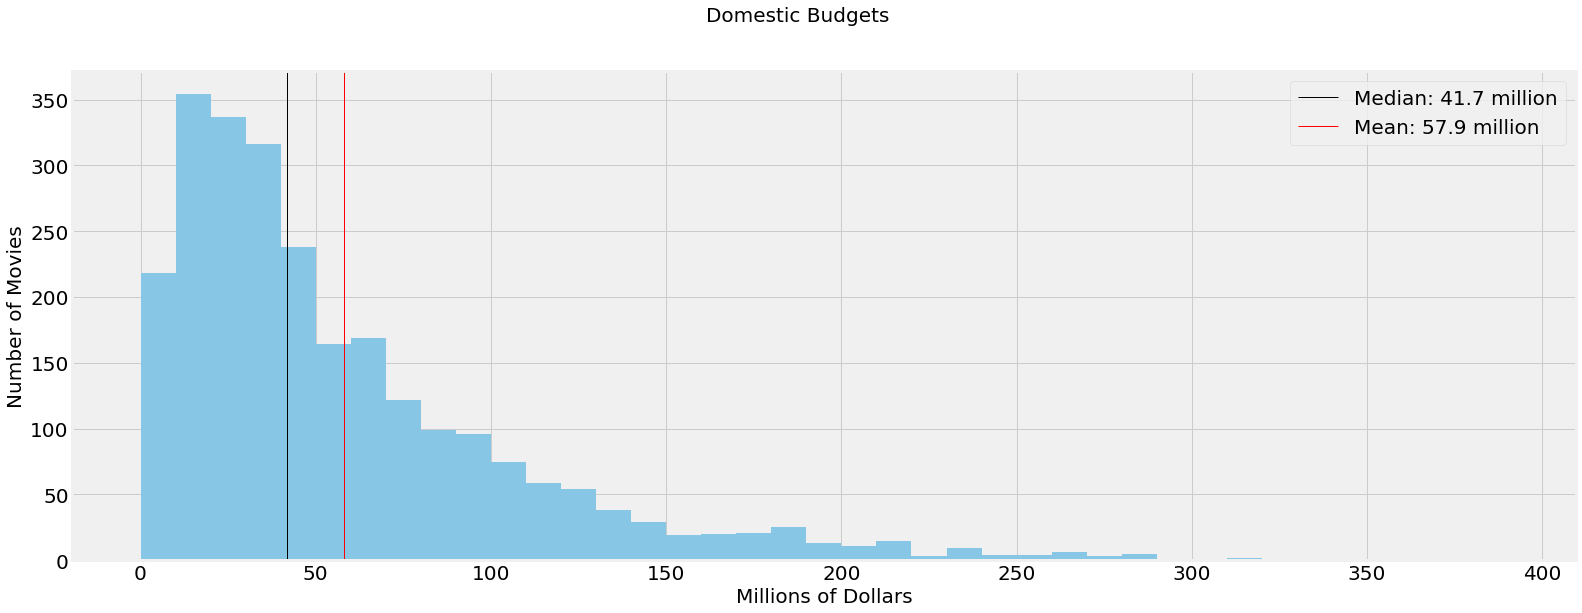

In [23]:
plot_aggregate_histogram(data=data, stat='budget_adj', title='Domestic Budgets', 
                         bins=range(0, 400, 10), color=genres_dict['action']['color2'])

## Profits

Here, we look at overall trends for how much profit (as defined by our profitability equation) the movies in our dataset have earned.

Note that these profits are calculated only based on domestic box office figures. Many of these movies would have been released abroad as well, so this isn't painting the full financial picture. For that, see the `Worldwide.ipynb` notebook.

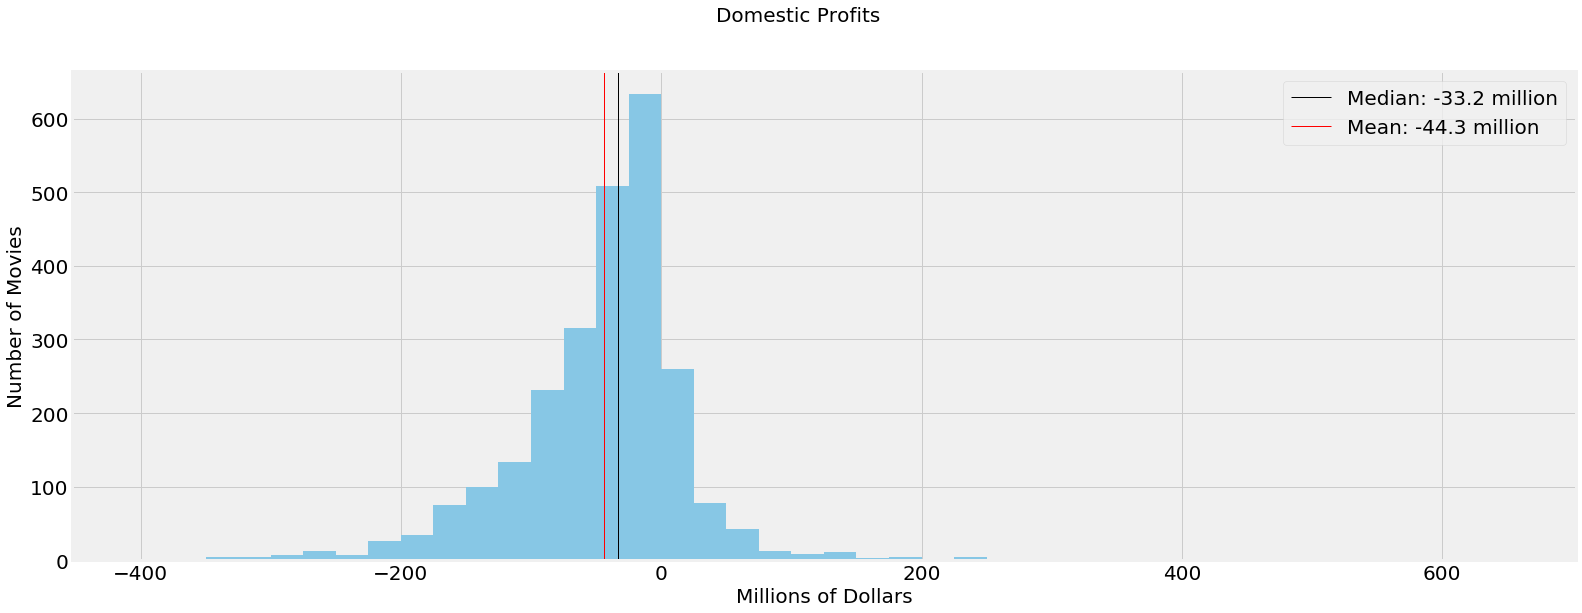

In [24]:
plot_aggregate_histogram(data=data, stat='profit', title='Domestic Profits', bins=range(-400, 675, 25), color=genres_dict['action']['color2'])

## Quick Takeaways

**Number of movies**
  - Comedy and Drama are historically the most produced genres by big movie studios by a healthy margin.

**Skewed grosses**
  - Domestic gross is heavily right-skewed, meaning it has a much higher median than mean (a difference of almost 35 million dollars).
  - This fits with our understanding of the movie business -- there are a few megahits that earn outsized returns while the majority of movies earn a little or even lose money.
  
**Skewed budgets**
  - Budgets are also heavily right-skewed, but with a much shorter right-tail than domestic gross.
  - This also fits our understanding of the movie business -- most movies are made for relatively small budgets, and there are only a few blockbusters made that have very large budgets.
  
**Skewed profits**
  - Profits are actually left-skewed, meaning the mean is less than the median.
  - Both median and mean for profits are negative, meaning the typical movie loses money at the domestic box office.
  - It's interesting that both mean and median profits are negative. Movies are indeed not a slam-dunk investment.
  
**Use median**
  - We will err on the side of using the median for our summary statistic. Our bosses are looking for insight into what they can expect as an average return from a movie they produce. We'd all like to have the mega blockbusters, but to keep their expectations in check, we will report a more fair assessment of our prospects.

# Genres Overview

In this section of the notebook, we get an overall sense of how the genres compare to each other historically.

- 9.1 Check out how much money each genre has made since the 1970s.
- 9.2 Check out how much money was spent producing each genre since the 1970s.
- 9.3 Check out how much overall profit each genre has made since the 1970s. (We calculate this by simply summing up the individual profts/losses for each movie.)
- 9.4 Check out the median amount of profit each genre has made since the 1970s.
- 9.5 Check out the mean amount of profit each genre has made since the 1970s.
- 9.6 Summarize our findings.

## Adding Up The Domestic Grosses

This graph shows the results of adding up the domestic box office grosses for all movies, separated by genre.

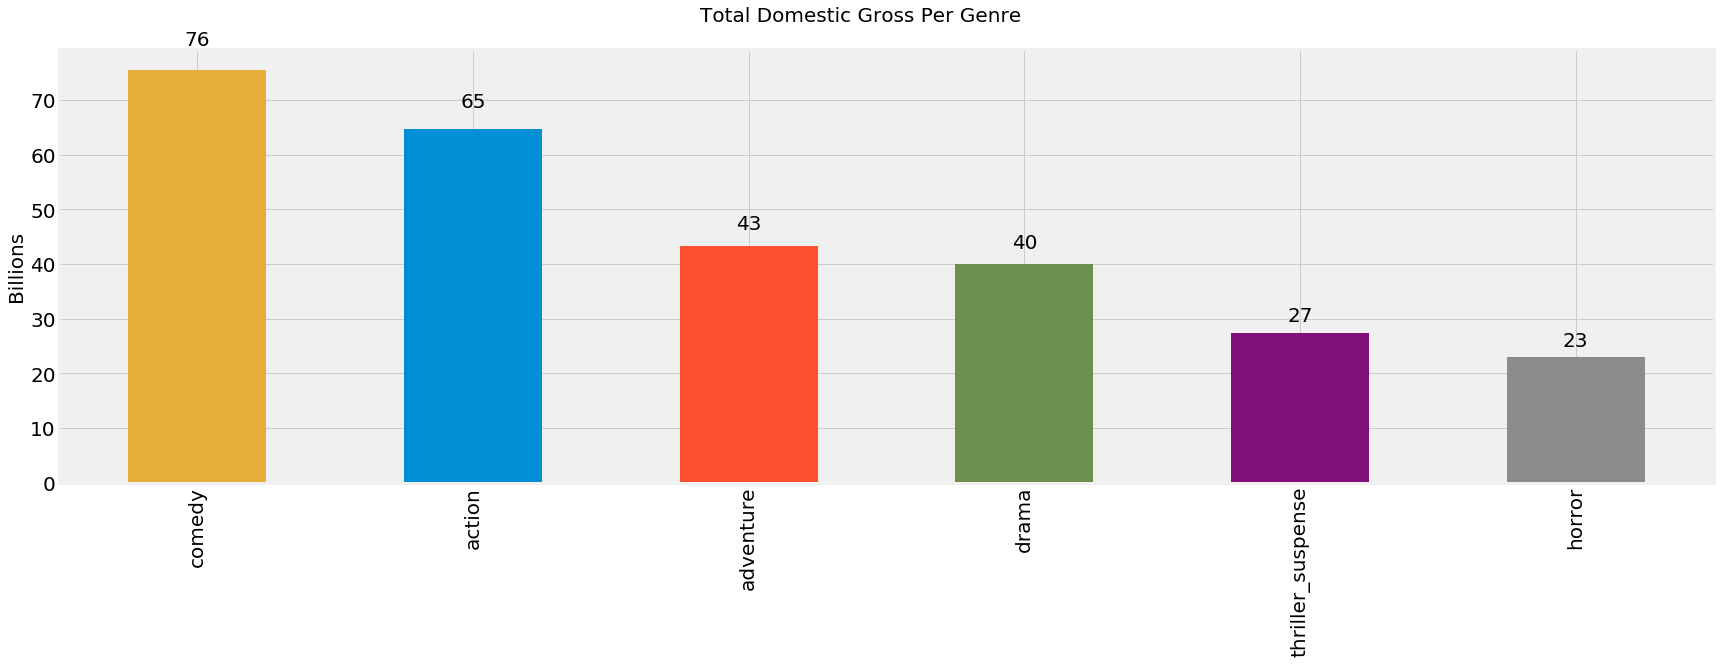

In [25]:
plot_summary_dataframe(summary=summary, sort_column='all_time_gross', plot_columns='all_time_gross', 
                       title='Total Domestic Gross Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Billions', num_decimals=0)

## Adding Up The Budgets

This graph shows the results of adding up the domestic budgets for all movies, separated by genre.

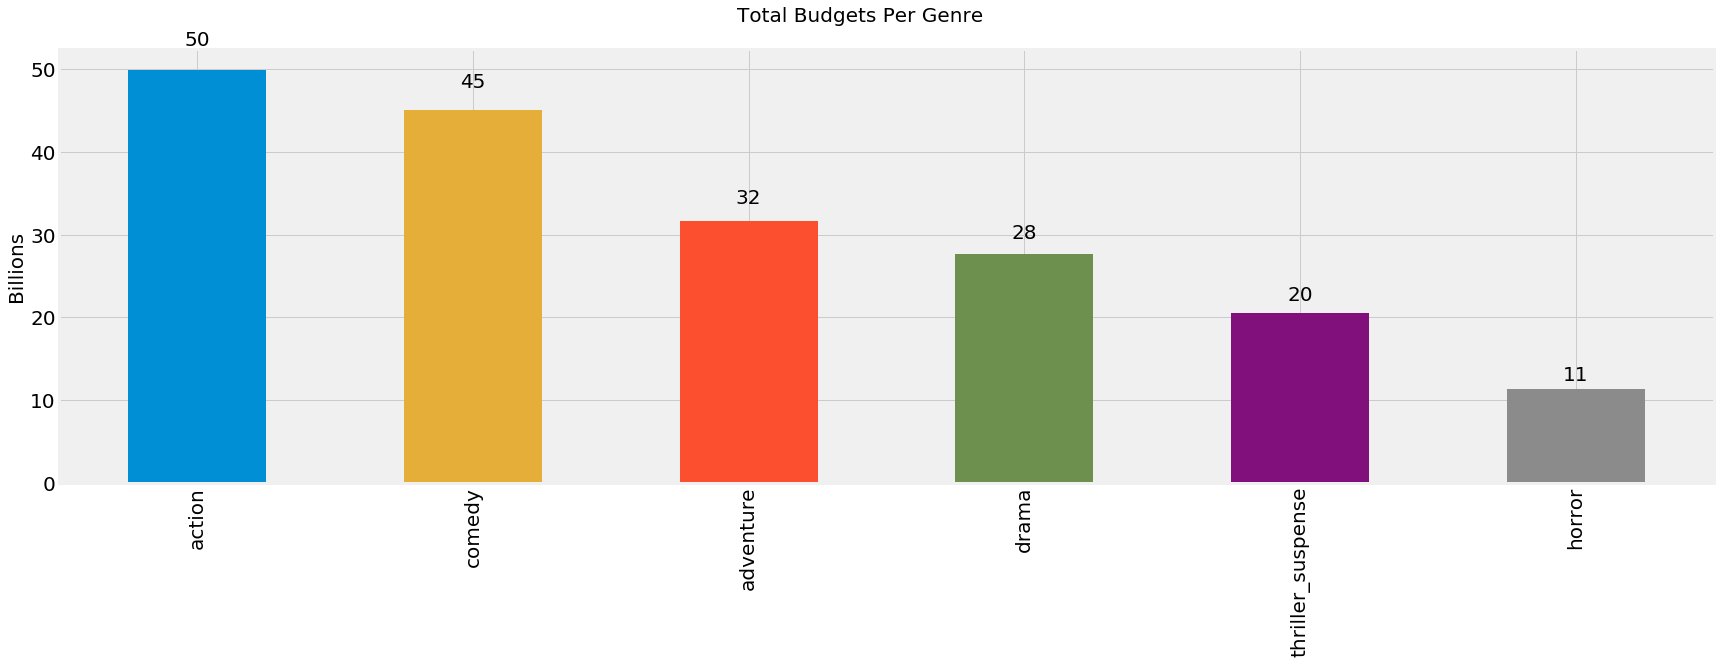

In [26]:
plot_summary_dataframe(summary=summary, sort_column='all_time_budget', plot_columns='all_time_budget', 
                       title='Total Budgets Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Billions', num_decimals=0)

## Adding Up The Profits

This graph shows the results of adding up the domestic profits for all movies, separated by genre.

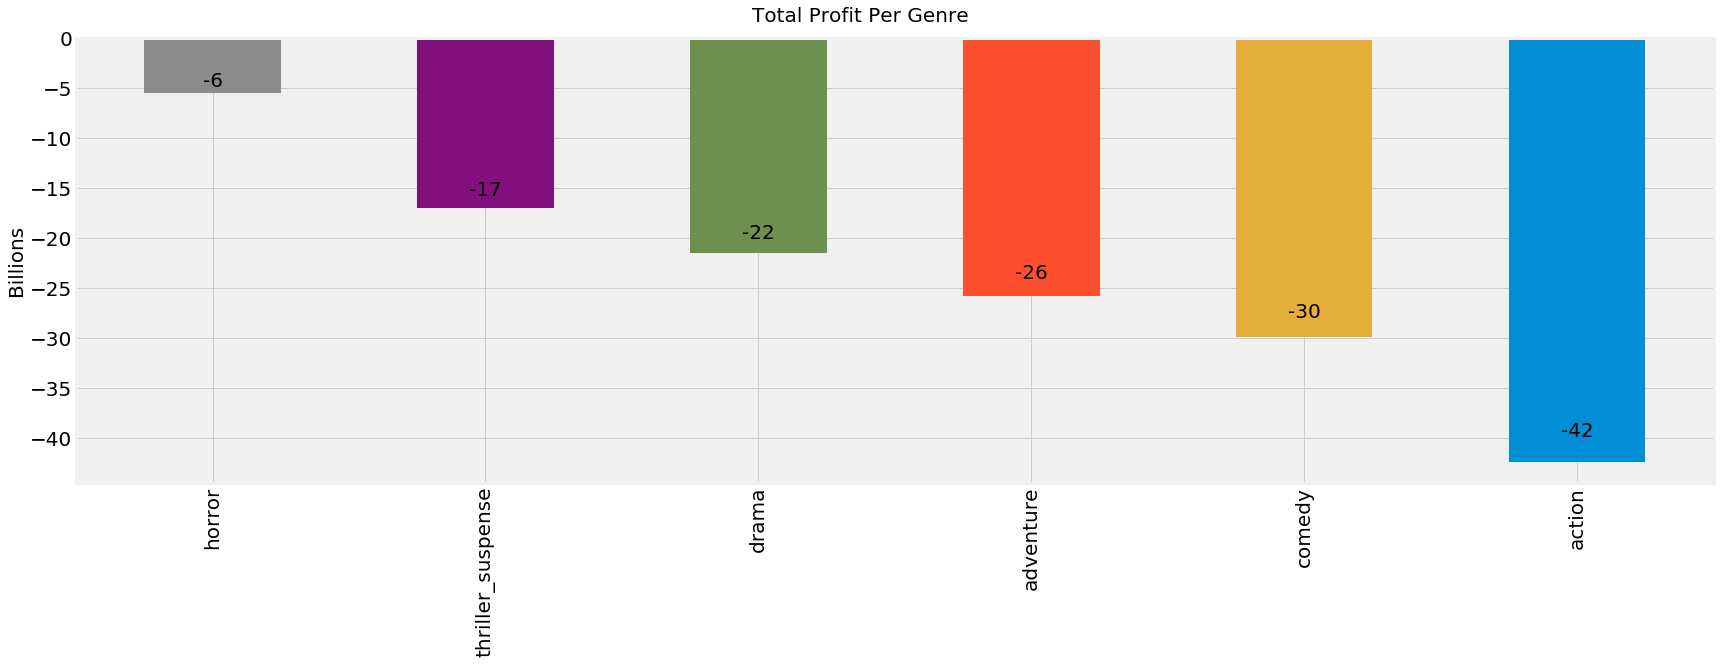

In [27]:
plot_summary_dataframe(summary=summary, sort_column='all_time_profit', plot_columns='all_time_profit', 
                       title='Total Profit Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Billions', num_decimals=0)

## Median Profit

This graph shows the results of taking the median value of domestic profits for all movies, separated by genre.

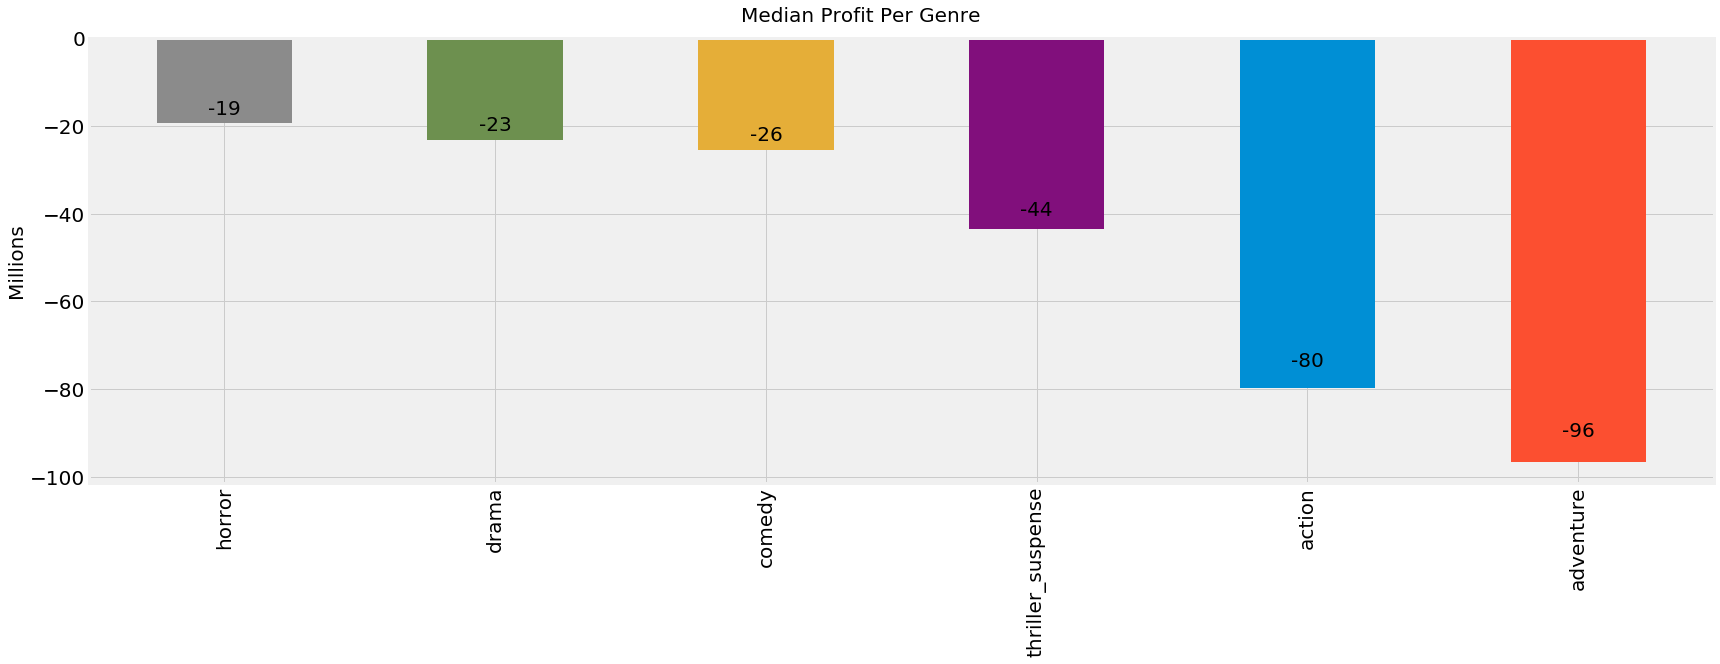

In [28]:
plot_summary_dataframe(summary=summary, sort_column='median_profit', plot_columns='median_profit', 
                       title='Median Profit Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Millions', num_decimals=0)

## Mean Profit

This graph shows the results of taking the mean value of domestic profits for all movies, separated by genre.

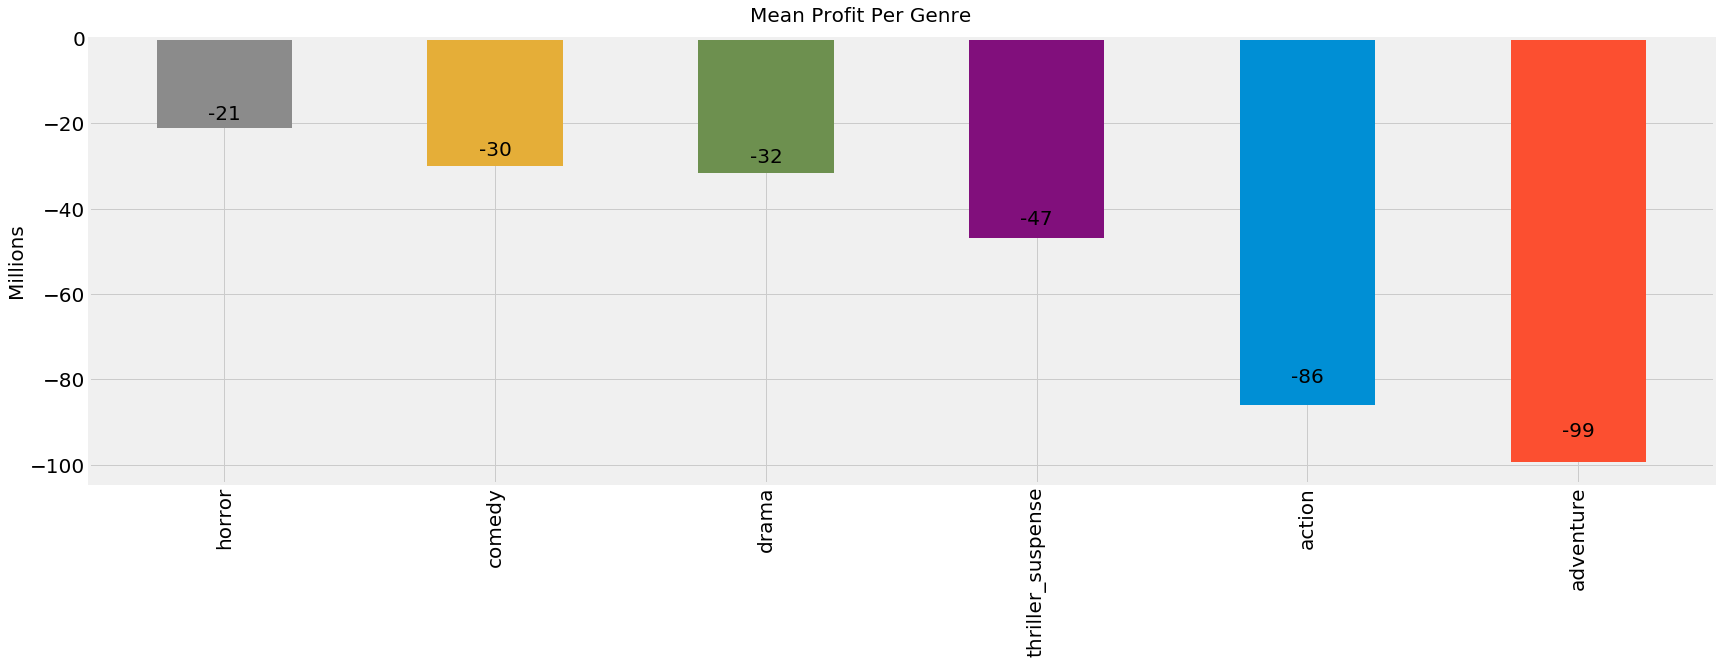

In [29]:
plot_summary_dataframe(summary=summary, sort_column='mean_profit', plot_columns='mean_profit', 
                       title='Mean Profit Per Genre', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Millions', num_decimals=0)

## Summary

**Highest gross**
  - Comedy, Action, and Adventure have grossed the most money. 
  
**Profitability**
  - No genre is profitable when looking at the entire group as a whole.
  
**Median profit**
  - No genre is a net winner in terms of median profit.
  - Horror is the best case at <span style='color:red'>-\\$19 million</span>. 
  - Drama is next at <span style='color:red'>-\\$23 million</span>.
  - Comedy is third at <span style='color:red'>-\\$26 million</span>.
  
**Mean profit**
  - No genre is a net winner in terms of mean profit.
  - Horror is the best case at <span style='color:red'>-\\$21 million</span>.
  - Comedy is next at <span style='color:red'>-\\$30 million</span>.
  - Drama is third at <span style='color:red'>-\\$32 million</span>.
  
**Thoughts**
  - We are going to dig way deeper, but it's nice to get a sense of the overall big picture by genre.

# Deeper Dive On Domestic Grosses

In this section of the notebook, we take a closer look at the domestic box office grosses by genre.

- 10.1 Look at the mean and median domestic box office gross amounts of each genre since the 1970s.
- 10.2 Look at histograms that shows us the distribution of domestic box office gross amounts for each genre since the 1970s.
- 10.3 Summarize our findings in 10.1 and 10.2.
- 10.4 Look at how the subgenre Action/Adventure affects the results (in terms of domestic box office gross amounts) for its parent genres of Action and Adventure.

## Mean and Median Gross

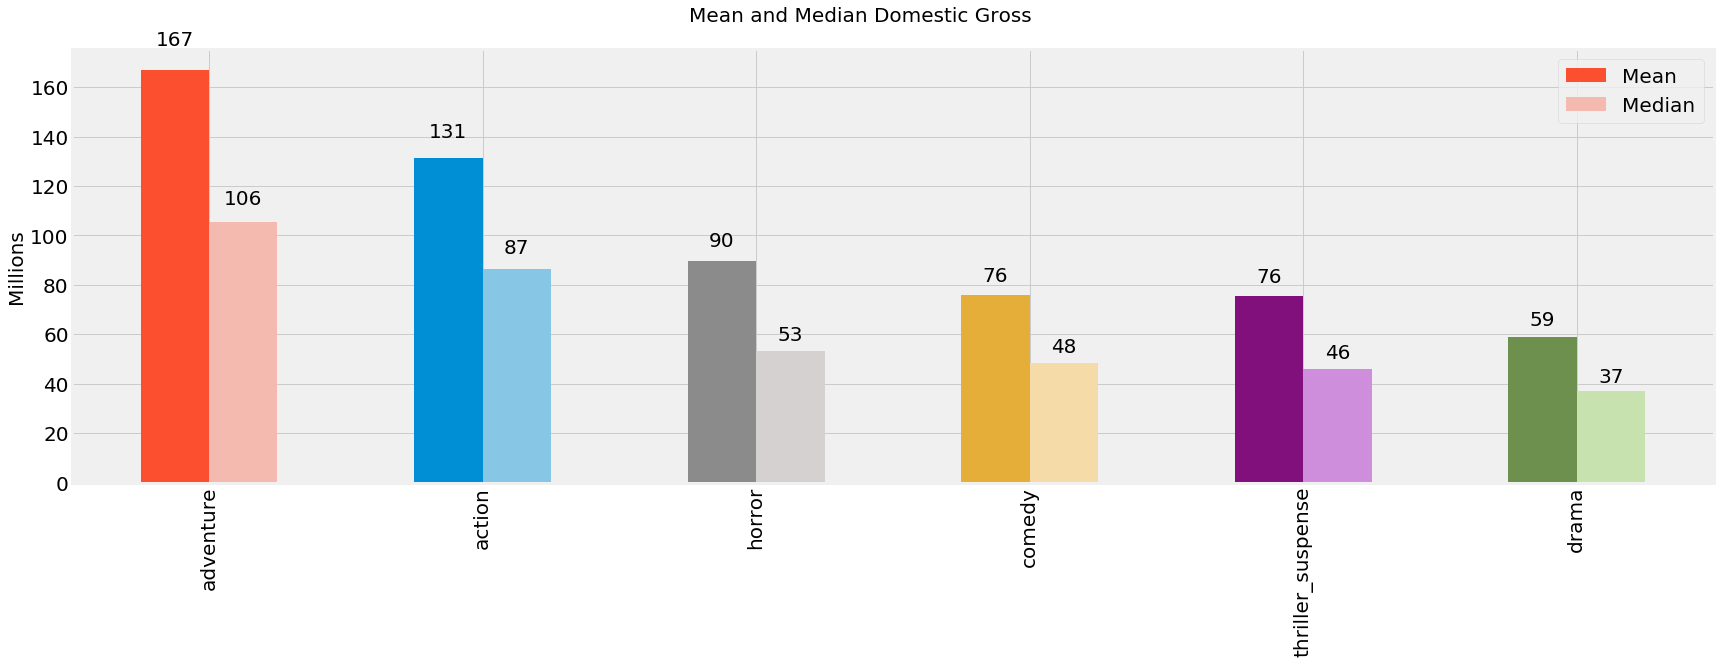

In [30]:
plot_summary_dataframe(summary=summary, sort_column='avg_gross', plot_columns=['avg_gross', 'median_gross'], 
                       title='Mean and Median Domestic Gross', colors_needed=2, legend_needed=True, 
                       legend_text=['Mean', 'Median'], y_label='Millions', num_decimals=0)

## Gross Distributions

This graph shows a histogram of the domestic box office grosses of all movies in our dataset, separated by genre.

The width of the bars is 50 million dollars. This means that each bar represents the number of movies that have grossed an amount of money somewhere in that 50 million dollar range.

Note that we are only showing those movies with domestic grosses up to 900 million dollars here. This is to make the graphs easier to read by not having too much empty space spanning the larger budget values that have very few entries.

This only excludes three movies in our dataset:
  - E.T.: The Extra-Terrestrial: &#0036;1.1 billion 
  - Jaws: &#0036;1.2 billion
  - The Exorcist: &#0036;1.3 billion

In [31]:
# Custom function to plot histograms of a stat by genre
def plot_histograms_by_genre(data, stat, title, genres, bins=10, colors_needed=1):
    figure, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(24,15))
    figure.suptitle(title, fontsize=20)

    sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]][stat].median() / 1000000)} for genre in genres], key=lambda k: k['amount'], reverse=True)
    genres_list = [item['genre'] for item in sorted_genres]
    color_list = generate_color_list(colors_needed=1, order_list=genres_list)

    for genre, axis, color in zip(genres_list, axes.flat, color_list):
        (data[data[genre]][stat] / 1000000).plot.hist(bins=bins, ax=axis, color=color)
        axis.set_title(genre, fontsize=20)
        axis.axvline(data[data[genre]][stat].median() / 1000000, color='k', linewidth=1)
        axis.axvline(data[data[genre]][stat].mean() / 1000000, color='r', linewidth=1)
        axis.legend(['Median: {:.1f} million'.format(data[data[genre]][stat].median() / 1000000), 'Mean: {:.1f} million'.format(data[data[genre]][stat].mean() / 1000000)], fontsize=15)
        axis.set_xlabel('Millions', fontsize=20)
        axis.set_ylabel('Number of Movies')

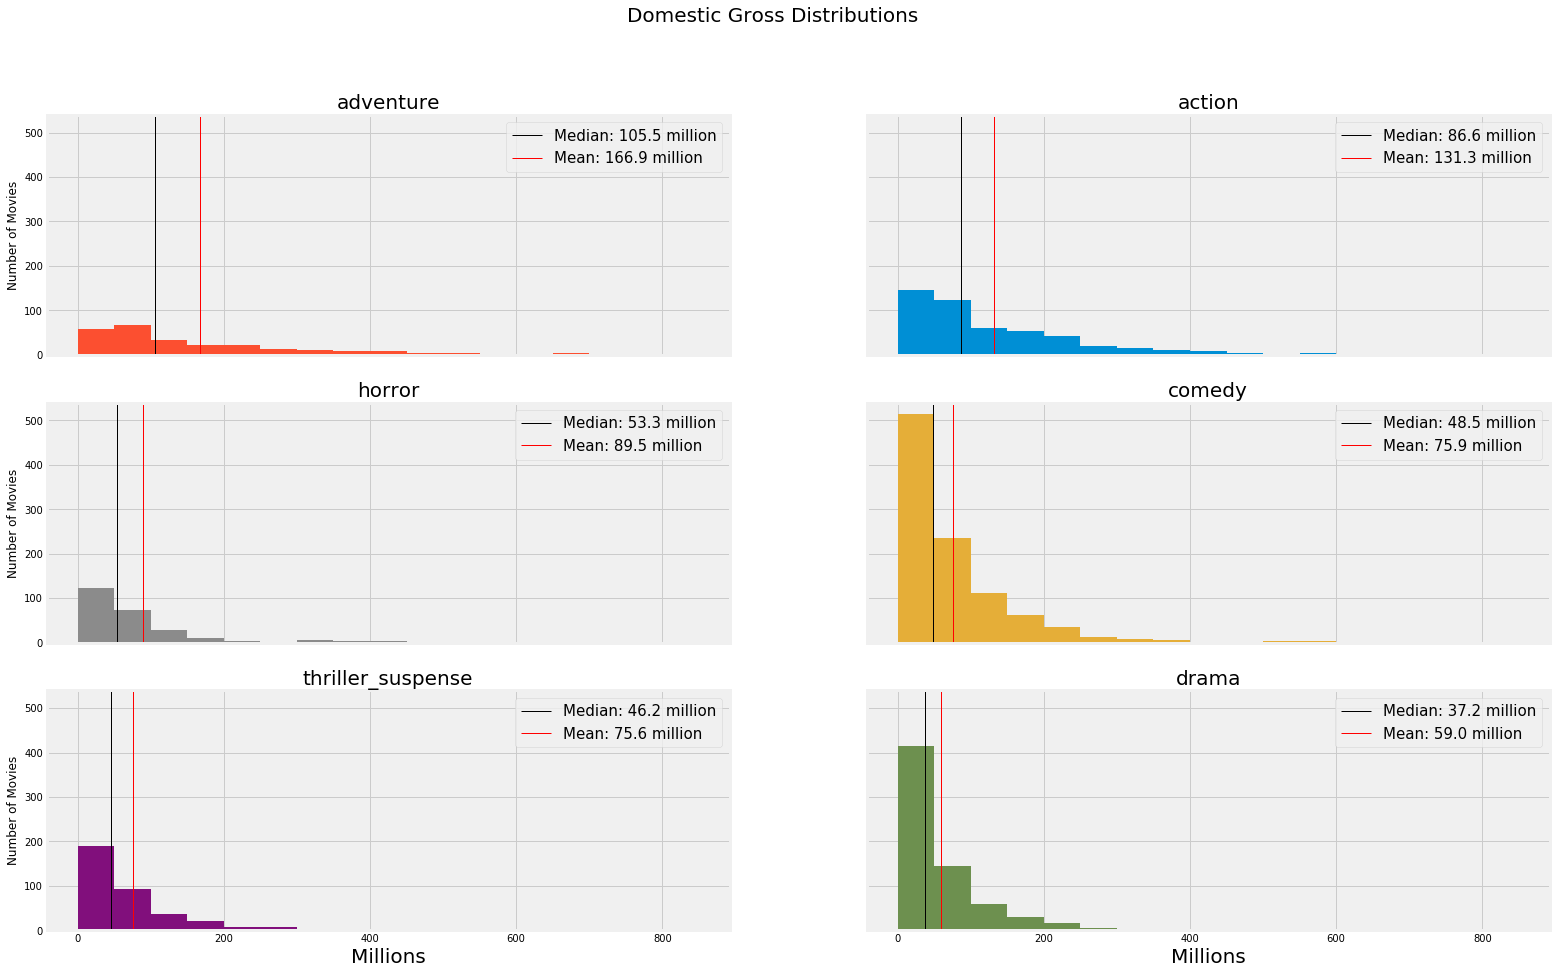

In [32]:
plot_histograms_by_genre(data=data, stat='domestic_adj', title='Domestic Gross Distributions', 
                         genres=genres, bins=range(0, 900, 50), colors_needed=1)

## Quick Takeaways

**Skew**
  - Even subdivided by genre, the worldwide box office gross distributions are all right-skewed.
  
**Mean and median**
  - Mean and median gross for Adventure and Action are far higher than any other genre.
  - Adventure's median gross is approximately 2 times as large as the third place median gross, Horror.
  - The most common gross amount in every genre except Adventure is &#0036;0-50 milllion.
  
**Action/Adventure**
  - Action and Adventure are the two genres with the biggest spread between mean and median gross (\\$61.4 million dollars and \\$44.7 million dollars respectively).
  - Something to keep in mind is the frequency of movies labeled Action/Adventure. In our analysis, such movies would count as both an Action movie and an Adventure movie. (We are assigning movies to every genre they have.) 
  - Since both of these genres are big on spectacle, they tend to be more likely to be blockbuster material.
  - We might have a situation where duplicate entries in both columns are artificially boosting their totals.
  - Let's investigate this a little further.

## Action/Adventure

In this section, we examine the Action/Adventure subgenre to see how it affects the Gross, Budget, and Profit of the Action and Adventure genres.

In [33]:
print('Median gross of Action/Adventure movies: ${:.1f} million'.format(data[data['genres_mojo'] == 'Action / Adventure']['domestic_adj'].median() / 1000000))
print('Median gross of Action (without Adventure component) movies: ${:.1f} million'.format(data[(data['genres_mojo'].str.contains('Action', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['domestic_adj'].median() / 1000000))
print('Median gross of Adventure (without Action component) movies: ${:.1f} million'.format(data[(data['genres_mojo'].str.contains('Adventure', na=False)) & (~data['genres_mojo'].isin(['Action / Adventure']))]['domestic_adj'].median() / 1000000))

Median gross of Action/Adventure movies: $195.9 million
Median gross of Action (without Adventure component) movies: $76.0 million
Median gross of Adventure (without Action component) movies: $79.6 million


In [34]:
# Custom function to show the Action/Adventure subgenres effect on Action and Adventure stats
def action_adventure_stats(genre, stat, title):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle(title, fontsize=20)

    median_with_action_adventure = data[data[genre]][stat].median() / 1000000
    median_without_action_adventure = data[(data[genre]) & (data['genres_mojo'] != 'Action / Adventure')][stat].median() / 1000000

    grp = data[data[genre]].groupby('genres_mojo')[stat].median().sort_values(ascending=False) / 1000000

    grp.plot(kind='bar', ax=axis, color=genres_dict[genre]['color1'])
    axis.axhline(median_with_action_adventure, color='k', linewidth=1)
    axis.axhline(median_without_action_adventure, color='r', linewidth=1)
    axis.tick_params(labelsize=20)
    axis.set_xlabel('')
    axis.set_ylabel('Millions', fontsize=20);
    axis.legend(['Overall Median With Action/Adventure: {:.1f}'.format(median_with_action_adventure),
                 'Overall Median Without Action/Adventure: {:.1f}'.format(median_without_action_adventure)], loc='best', fontsize=20)
    autolabel(axis)

### Action

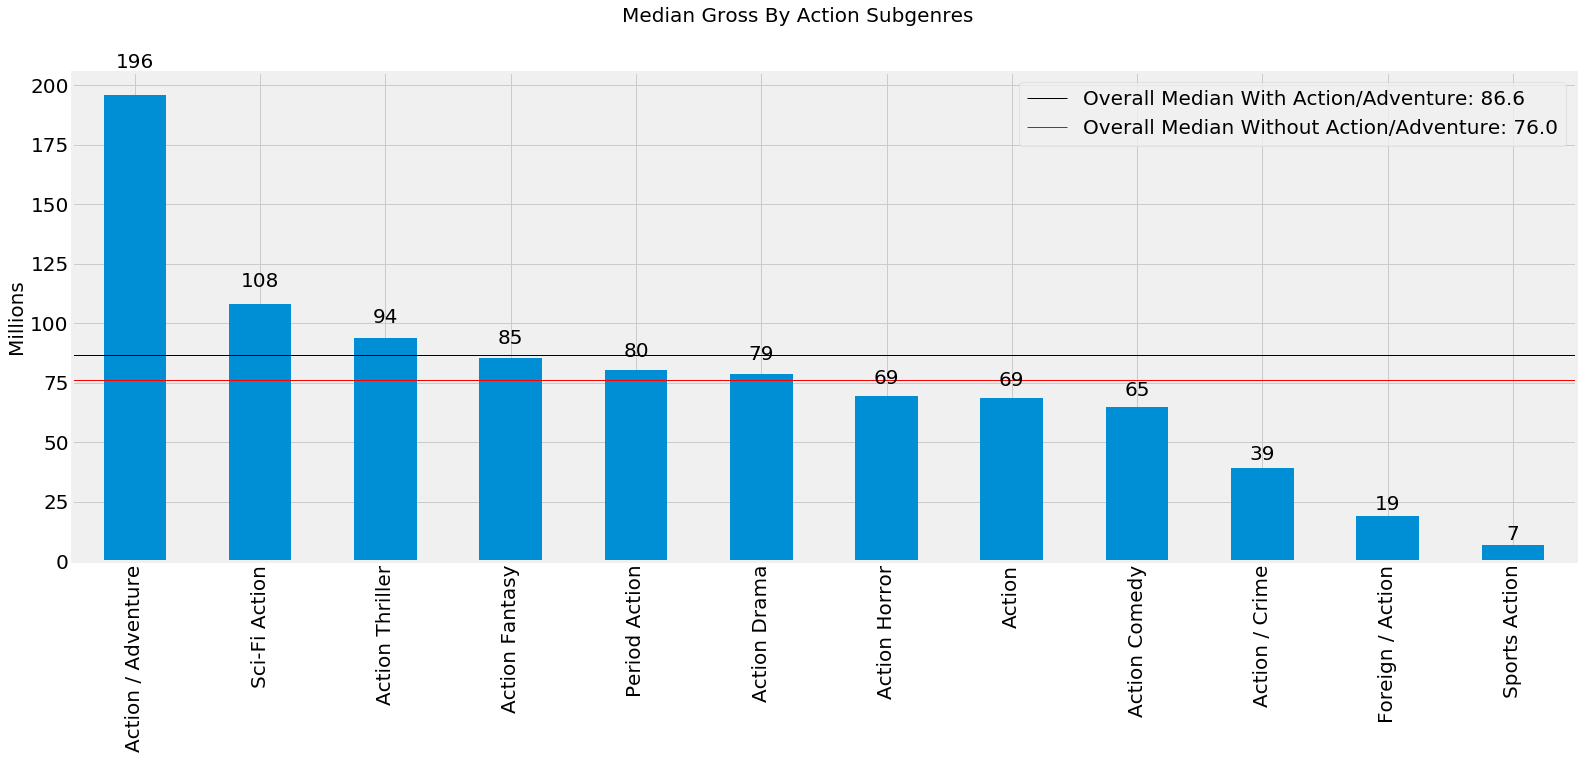

In [35]:
action_adventure_stats(genre='action', stat='domestic_adj', title='Median Gross By Action Subgenres')

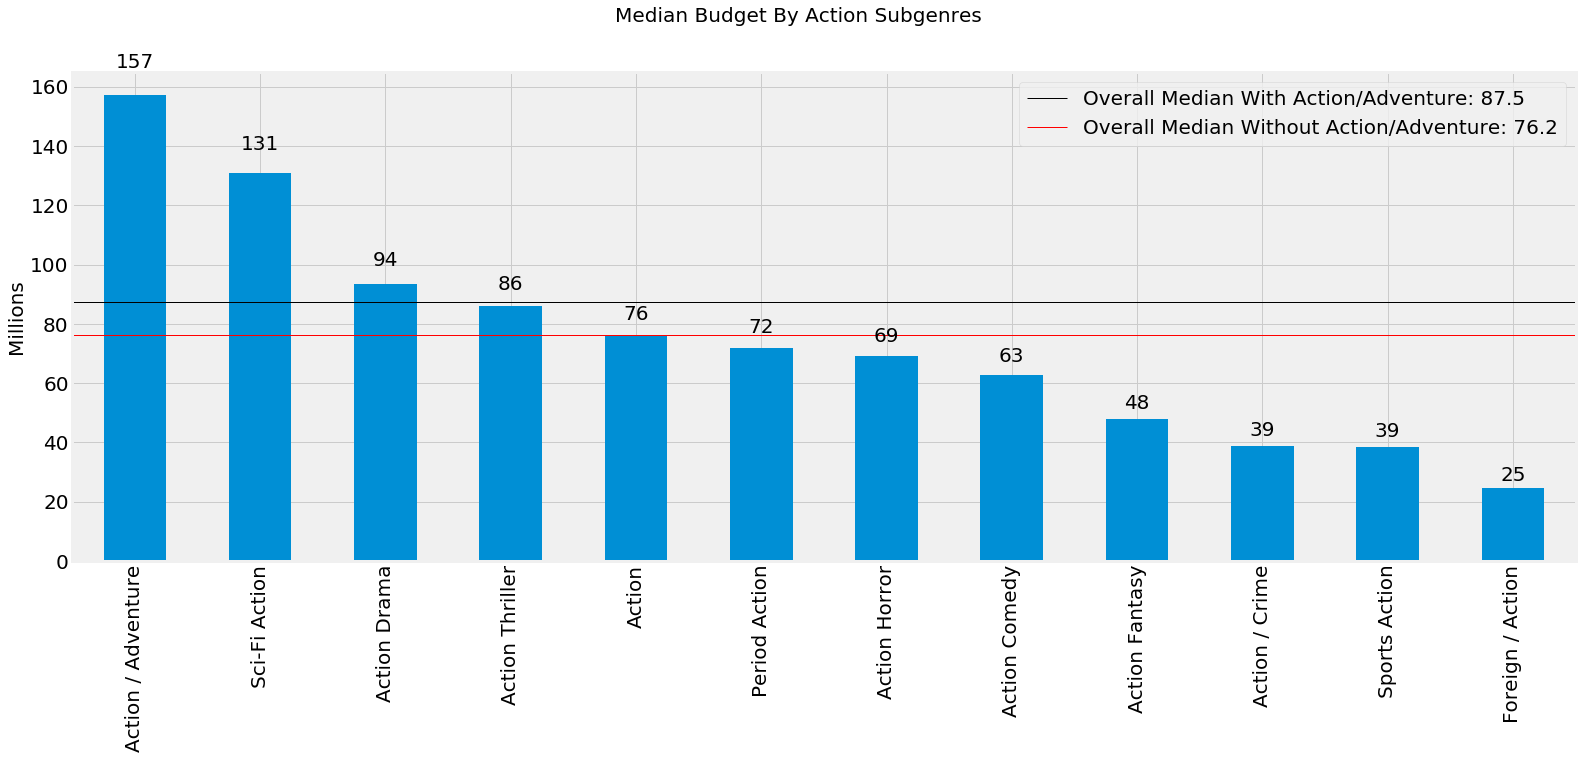

In [36]:
action_adventure_stats(genre='action', stat='budget_adj', title='Median Budget By Action Subgenres')

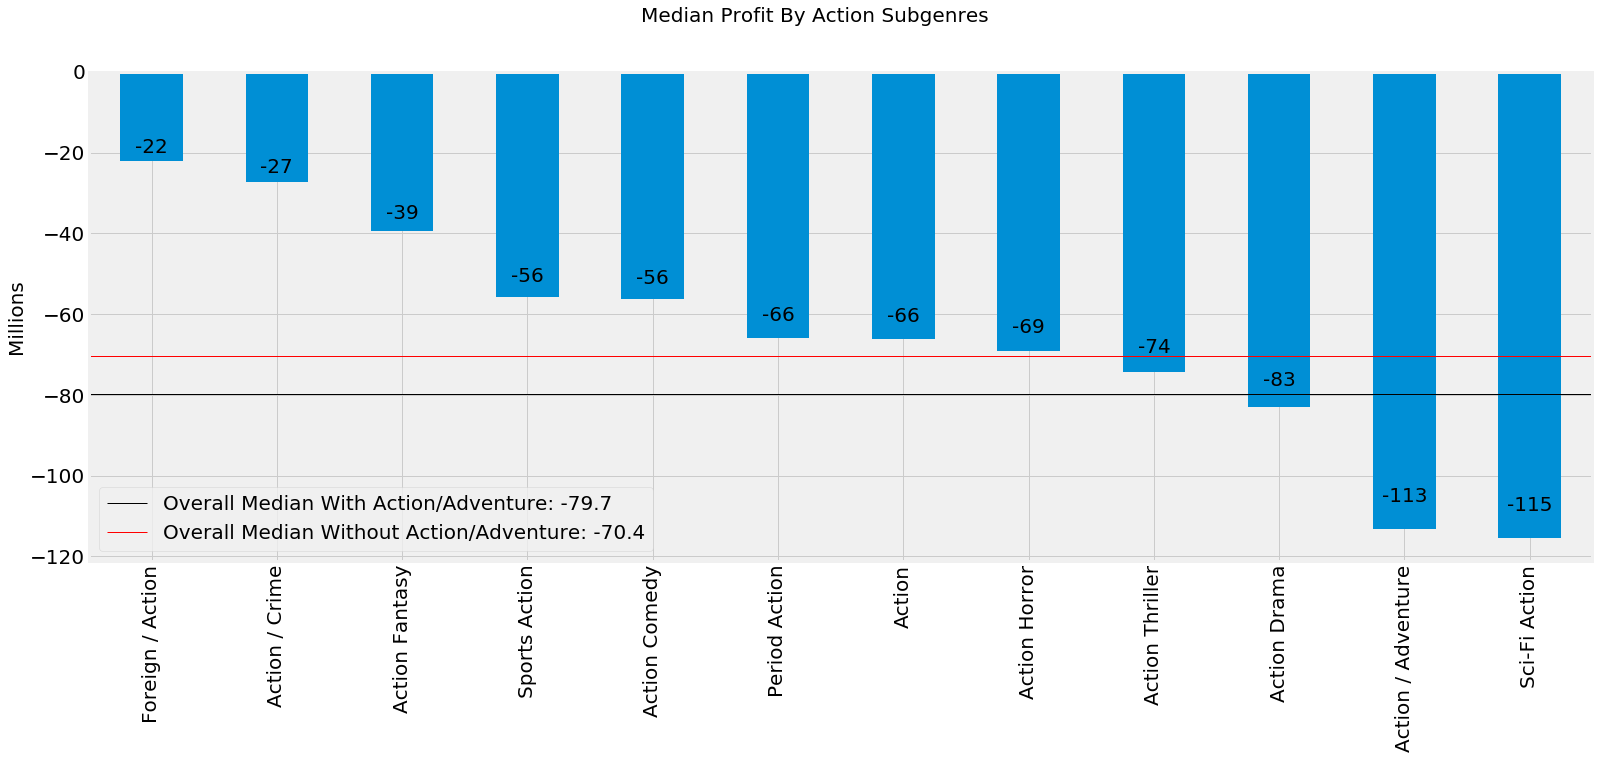

In [37]:
action_adventure_stats(genre='action', stat='profit', title='Median Profit By Action Subgenres')

### Quick Takeaways

  - Action/Adventure and Sci-Fi Action are the highest grossing subgenres. They also carry the highest production budgets.
  - No subgenre has a positive median profit. This might be due to how expensive Action movies are in general. They might rely on the international box office to bridge the gap to profitability. 
  - Since Action/Adventure is such a huge grossing subgenre, it boosts the median gross for the entire genre by about &#0036;10.6 million.

### Adventure

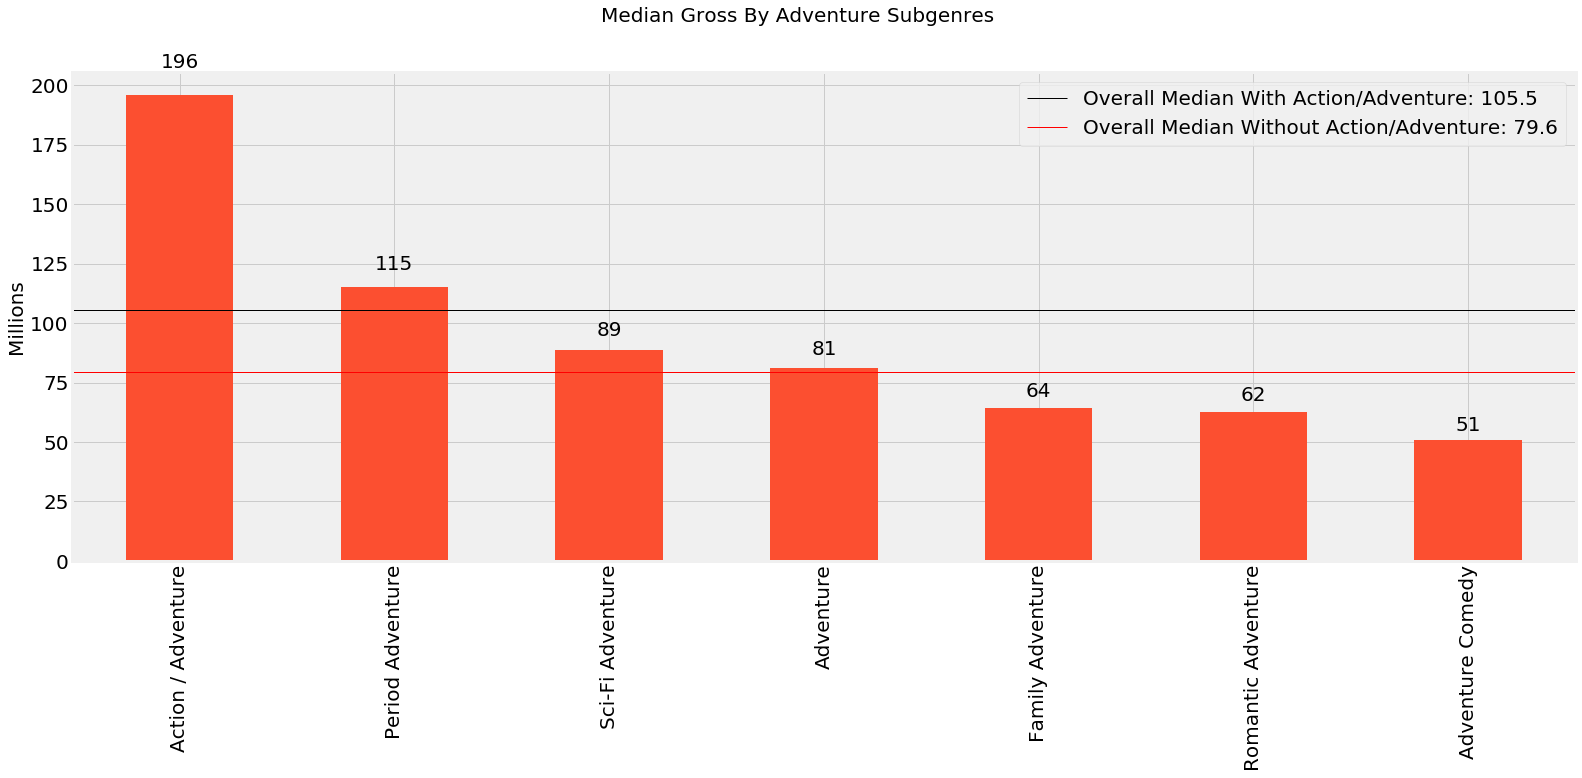

In [38]:
action_adventure_stats(genre='adventure', stat='domestic_adj', title='Median Gross By Adventure Subgenres')

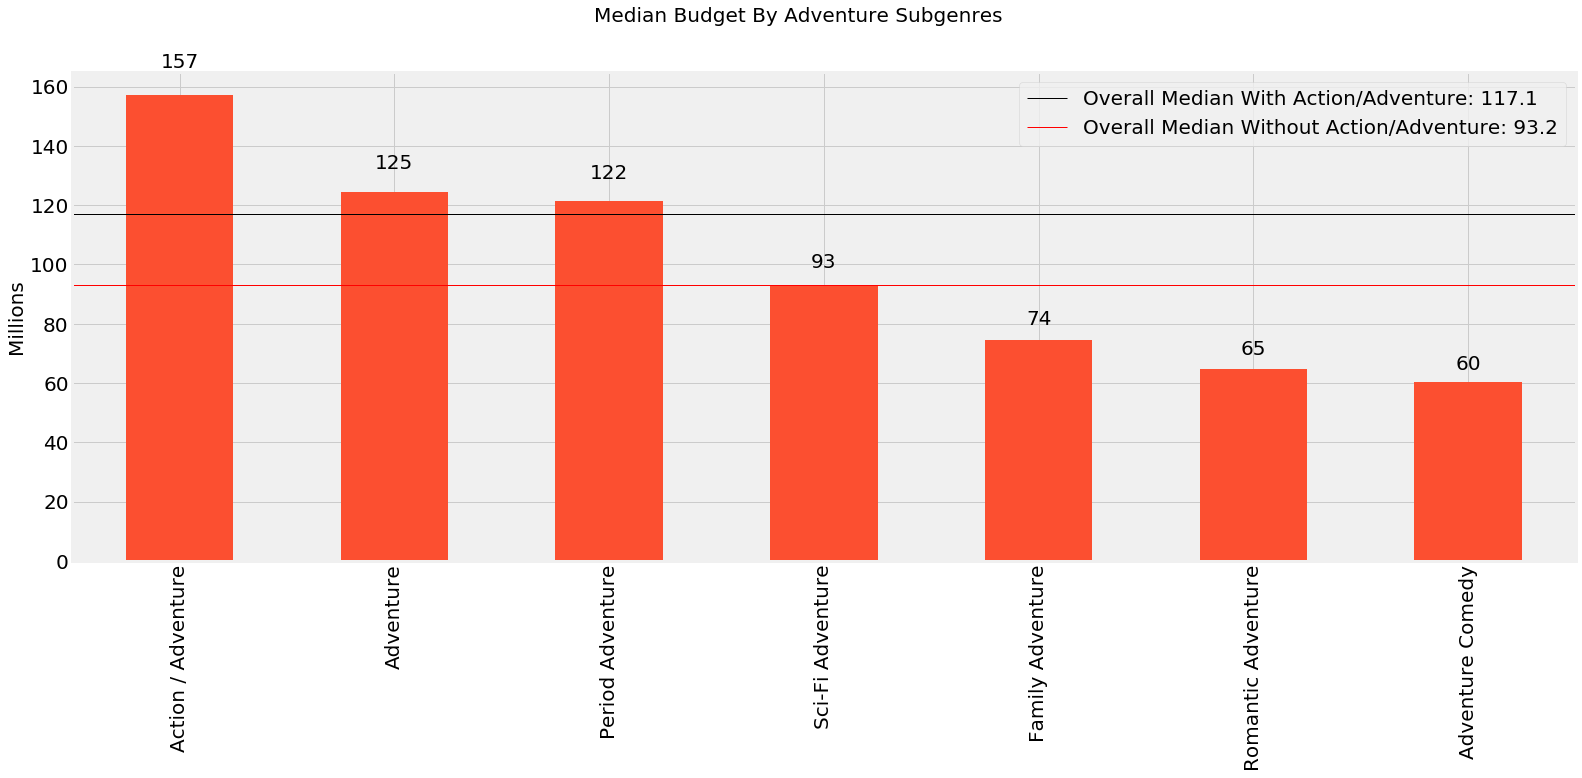

In [39]:
action_adventure_stats(genre='adventure', stat='budget_adj', title='Median Budget By Adventure Subgenres')

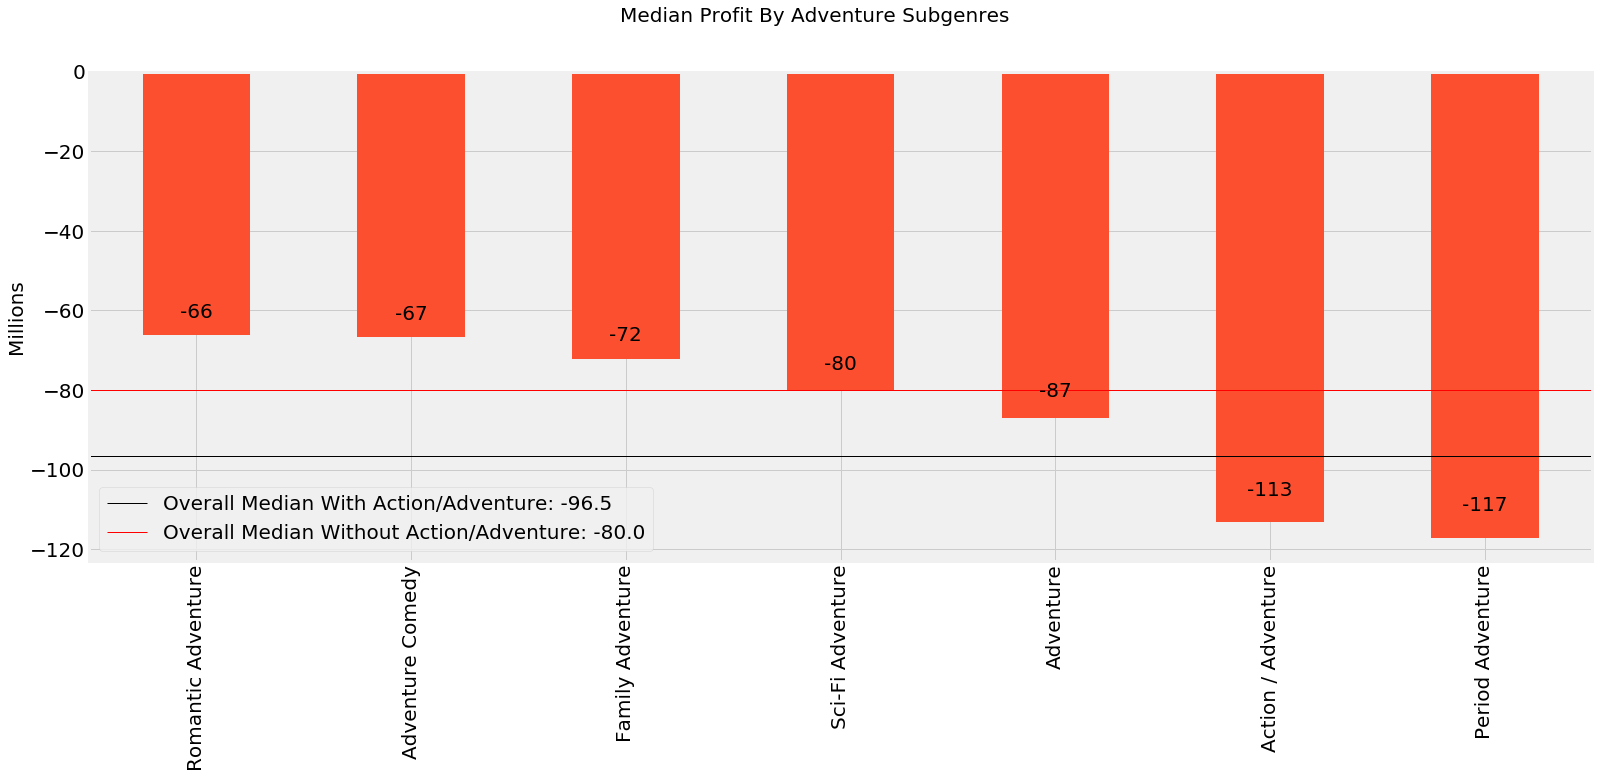

In [40]:
action_adventure_stats(genre='adventure', stat='profit', title='Median Profit By Adventure Subgenres')

### Quick Takeaways

  - Action/Adventure is the highest grossing and most expensive subgenre.
  - Period Adventure is the second highest grossing subgenre and third most expensive.
  - No subgenres have a positive median profit. 
  - The Action/Adventure subgenre boosts the median gross for the entire genre by about &#0036;25.9 million.

### Summary

**Action/Adventure is the culprit!**
  - Action/Adventure movies are so high-grossing that they are boosting the median stats of Action and Adventure movies by a big margin.
  
**Gross**
  - Action's median gross increases about &#0036;10.6 million.
  - Adventure's median gross increases about &#0036;25.9 million.
    
**Budget**
  - Action's median budget increases about &#0036;12 million.
  - Adventure's median budget increases about &#0036;23.9 million.
    
**Profit**
  - Action's median profit decreases about &#0036;9.3 million.
  - Adventure's median profit decreases about &#0036;16.5 million.
  - That means Action/Adventure movies (with their <span style='color:red'>-\\$113 million</span> median loss) are losing more money at the domestic market than all other subgenres except Sci-Fi Action (<span style='color:red'>-\\$115 million</span>) and Period Adventure (<span style='color:red'>-\\$117 million</span>).
    
**Keep it in the back of our minds**
  - We should be aware of the limitations of only looking at the domestic market, as Action and Adventure movies are two genres that perform very well overseas. Studios might make these genres with the understanding that they won't break even domestically.

# Deeper Dive on Production Budgets

In this section of the notebook, we take a closer look at production budgets of each genre since the 1970s.

- 11.1 Look at the mean and median values for production budget of each genre.
- 11.2 Look at histograms that show us the distribution of production budget amounts for each genre.
- 11.3 Another look at the distribution of production budgets (not separated by genre).
- 11.4 Summarize our findings. 

## Mean and Median Production Budget

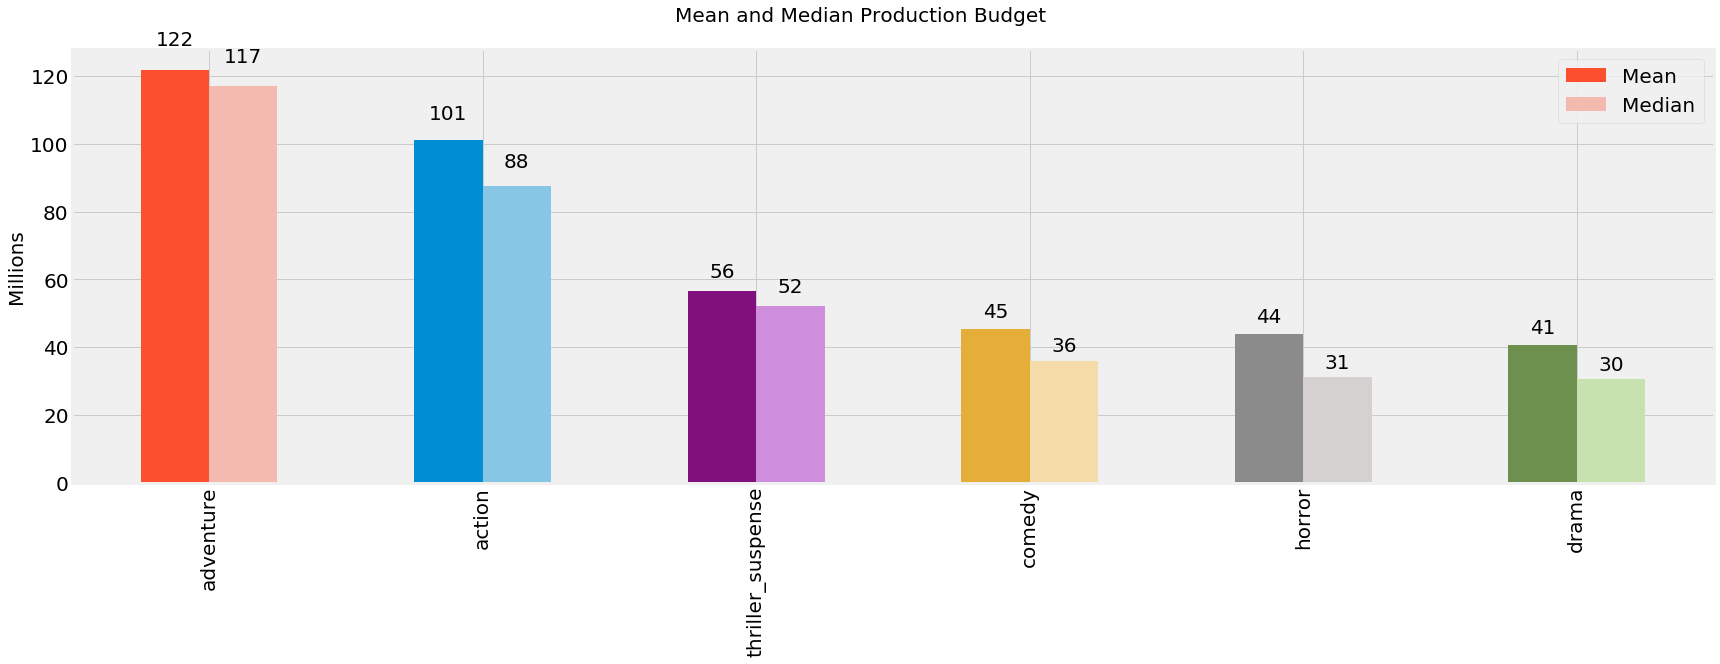

In [41]:
plot_summary_dataframe(summary=summary, sort_column='avg_budget', plot_columns=['avg_budget', 'median_budget'], 
                       title='Mean and Median Production Budget', colors_needed=2, legend_needed=True, 
                       legend_text=['Mean', 'Median'], num_decimals=0)

## Production Budget Distributions

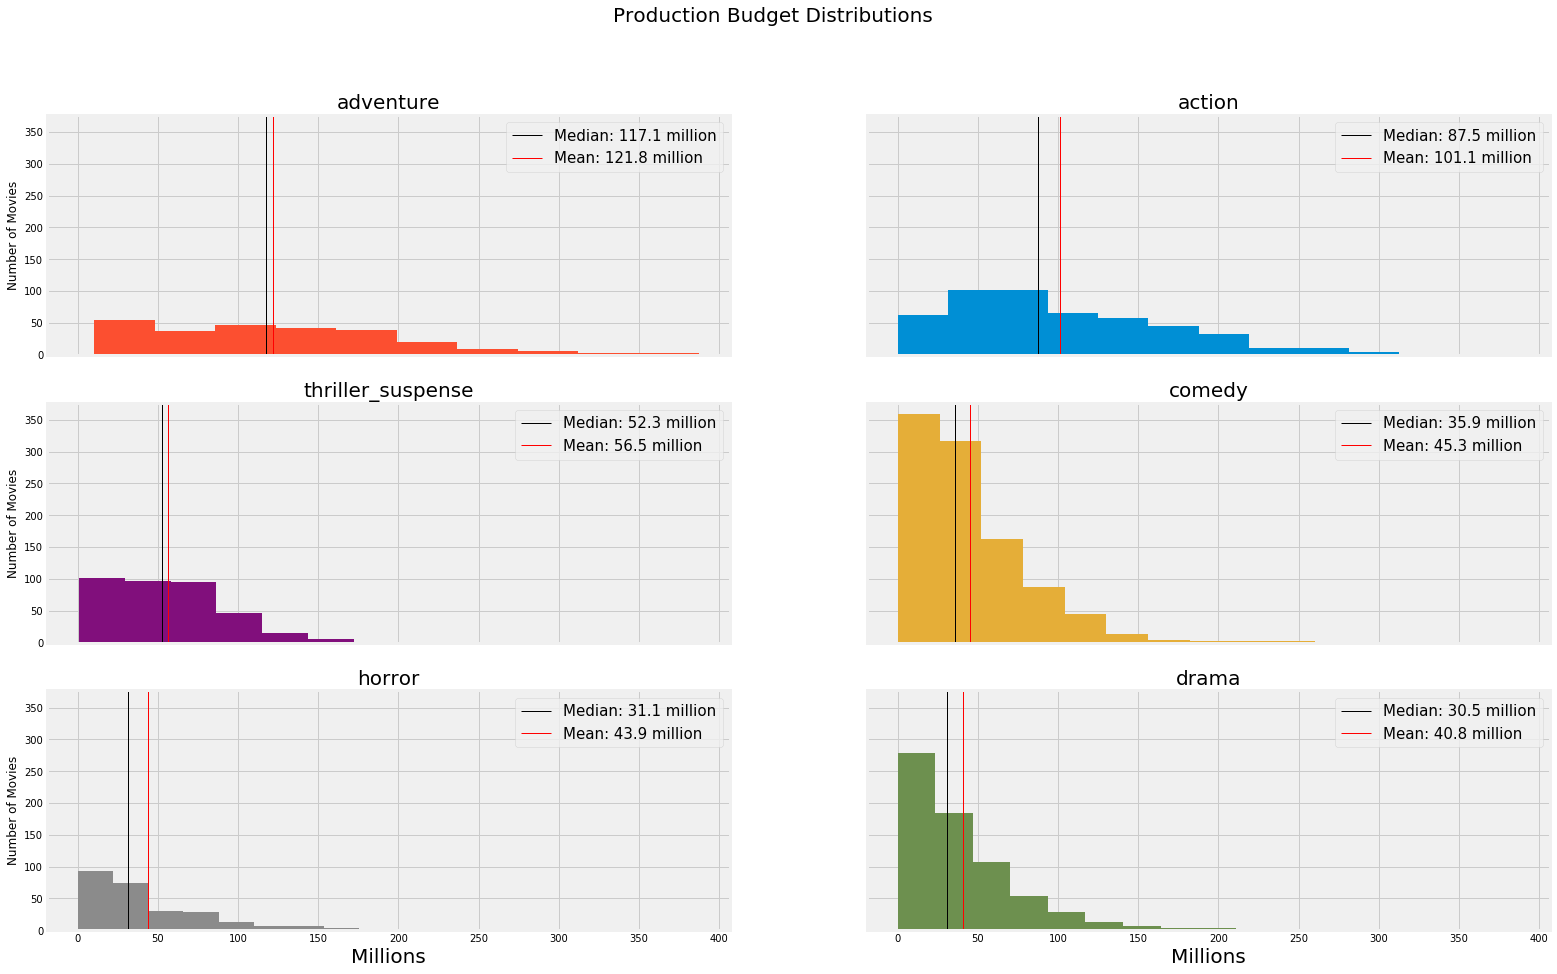

In [42]:
plot_histograms_by_genre(data=data, stat='budget_adj', title='Production Budget Distributions', 
                         genres=genres, bins=10, colors_needed=1)

## Production Budget Distribution (Not Separated By Genre)

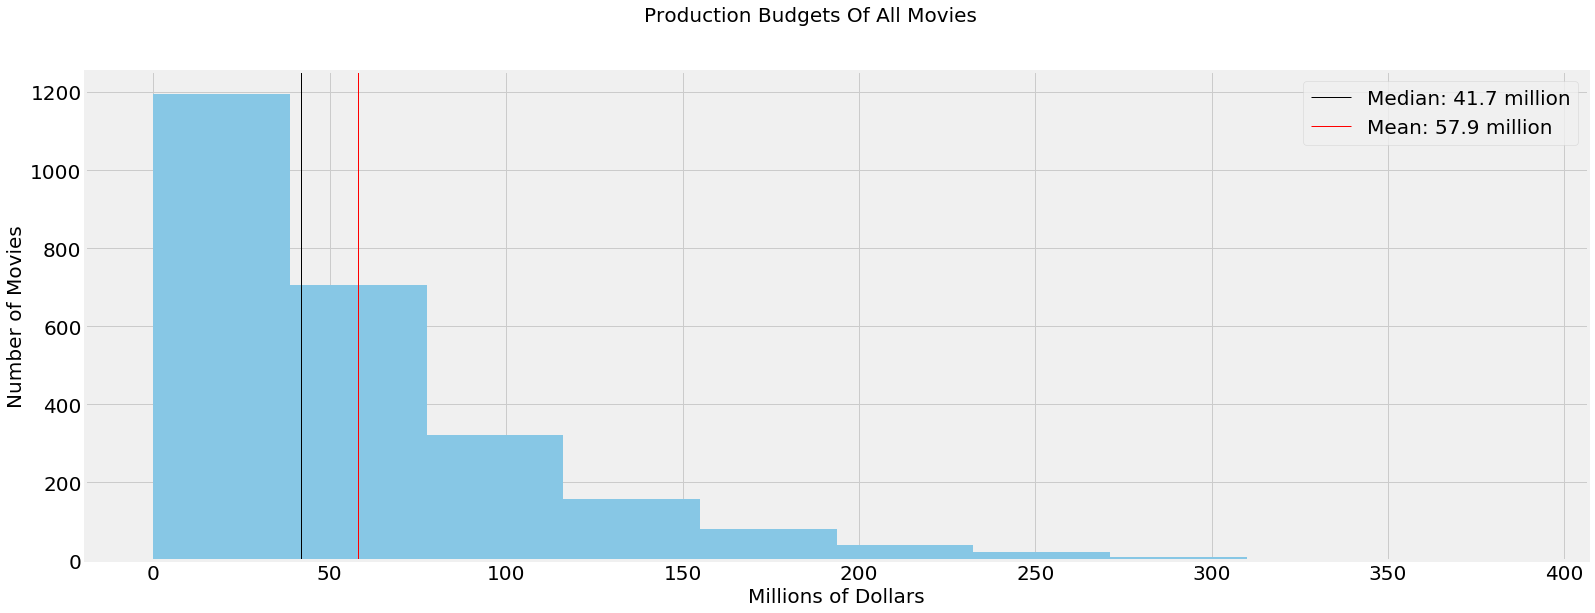

In [43]:
plot_aggregate_histogram(data=data, stat='budget_adj', title='Production Budgets Of All Movies', 
                         bins=10, color=genres_dict['action']['color2'])

## Quick Takeaways

**Median production budget**
  - Adventure and Action have by far the largest median budget. This makes sense, as those movies tend to require more set pieces and CGI than other genres.
  - Adventure is 2.2 times the median budget of the third place genre, Thriller/Suspense.
  - Comedy, Horror, and Drama all have very similar, low median production budgets. 
  - Production budgets (when separated by genre) are also right-skewed, but they have far less skew than worldwide grosses.
  
**Low budgets**
  - We can tell by the median production budget of &#0036;41.7 million that the majority of movies produced have a relatively small budget.
  - Blockbusters (those costing 200-300 million dollars) are the exception, rather than the rule.
  - Something to keep in mind is if this trend has changed in the past decade. (We will look at this a bit later.)

# Deeper Dive On Profits

In this section of the notebook, we take a closer look at domestic profits for each genre since the 1970s.

- 12.1 Define a few custom functions for making some graphing situations easier later on. 
- 12.2 Look at a boxplot showing the distribution of domestic profit amounts for each genre.
- 12.3 Summarize our findings.
- 12.4 Look at the median profits of each subgenre within our main genres.
- 12.5 Summarize our findings. 
- 12.6 Look at the mean profits of each subgenre within our main genres.
- 12.7 Summarize our findings.  
- 12.8 Look at earnings divided by expenses for our main genres.
- 12.9 Summarize our findings.

## Custom Functions To Create New Columns Containing Stats Separated By Genre

Since we define a movie's genre by all the genres it contains, many of our movies have multiple genres that we care about.

It would make life easier if, in one column, we could store a statistic and the genre of the movie.

Obviously, this involves duplication in situations where a movie has multiple genres (for example, an Action/Adventure movie counts as both an Action and Adventure movie).

These custom functions create new columns that contain the corresonding statistic (domestic gross, budget, profit, breakeven) and whether the movie is of a certain genre.

This makes graphing certain things much easier.

In [44]:
# We want individual columns that hold a specific domestic stat for each genre.
# Since a movie can have multiple genres, right now we must isolate each genre with a groupby while looping over each genre.
# If we create individual columns that contain information about a genre and a domestic stat, it's easier to graph later.
def domestic_stat_by_genre(row, genre, stat):
    # Returns either 0 or the stat value due to boolean multiplication.
    test = row[genre] * row[stat]
        
    # If the row is not in the genre (i.e. False * $100 = 0)
    if test == 0:
        return np.nan
    else:
        return test

# We want individual columns that store breakeven information for each genre.
# Since we will be adding the entries in these columns (and using pd.DataFrame.mean()), we need to convert them to 1's and 0's.
# Thus, we need to create a separate function from the 'domestic_stat_by_genre' function.
def test_for_breakeven_by_genre(row, genre, breakeven_column):
    if row[genre]:
        if row[breakeven_column]:
            return 1
        else:
            return 0
    else:
        return np.nan
    
# List of new columns to hold domestic stats by genre.
budget_columns = ['domestic_budget_{}'.format(genre) for genre in genres]
gross_columns = ['domestic_gross_{}'.format(genre) for genre in genres]
profit_columns = ['domestic_profit_{}'.format(genre) for genre in genres]
breakeven_columns = ['domestic_breakeven_{}'.format(genre) for genre in genres]

for genre, col in zip(genres, budget_columns):
    data[col] = data.apply(lambda x: domestic_stat_by_genre(x, genre, 'budget_adj'), axis=1)
    
for genre, col in zip(genres, gross_columns):
    data[col] = data.apply(lambda x: domestic_stat_by_genre(x, genre, 'domestic_adj'), axis=1)
    
for genre, col in zip(genres, profit_columns):
    data[col] = data.apply(lambda x: domestic_stat_by_genre(x, genre, 'profit'), axis=1)
        
for genre, col in zip(genres, breakeven_columns):
    data[col] = data.apply(lambda x: test_for_breakeven_by_genre(x, genre, 'domestic_breakeven'), axis=1)

## Boxplot To The Rescue!

In [45]:
def plot_boxplot(data, genres, title, columns, starting_year=1970, y_label=''):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,15))
    figure.suptitle(title, fontsize=20, y=1.05)

    data[data['release_year'] >= starting_year][columns].plot(kind='box', ax=axis)
    axis.set_ylabel(y_label, fontsize=20)
    axis.set_xticklabels(genres)
    axis.tick_params(labelsize=20)
    axis.axhline(0, color='k', linewidth=1)

    plt.tight_layout()

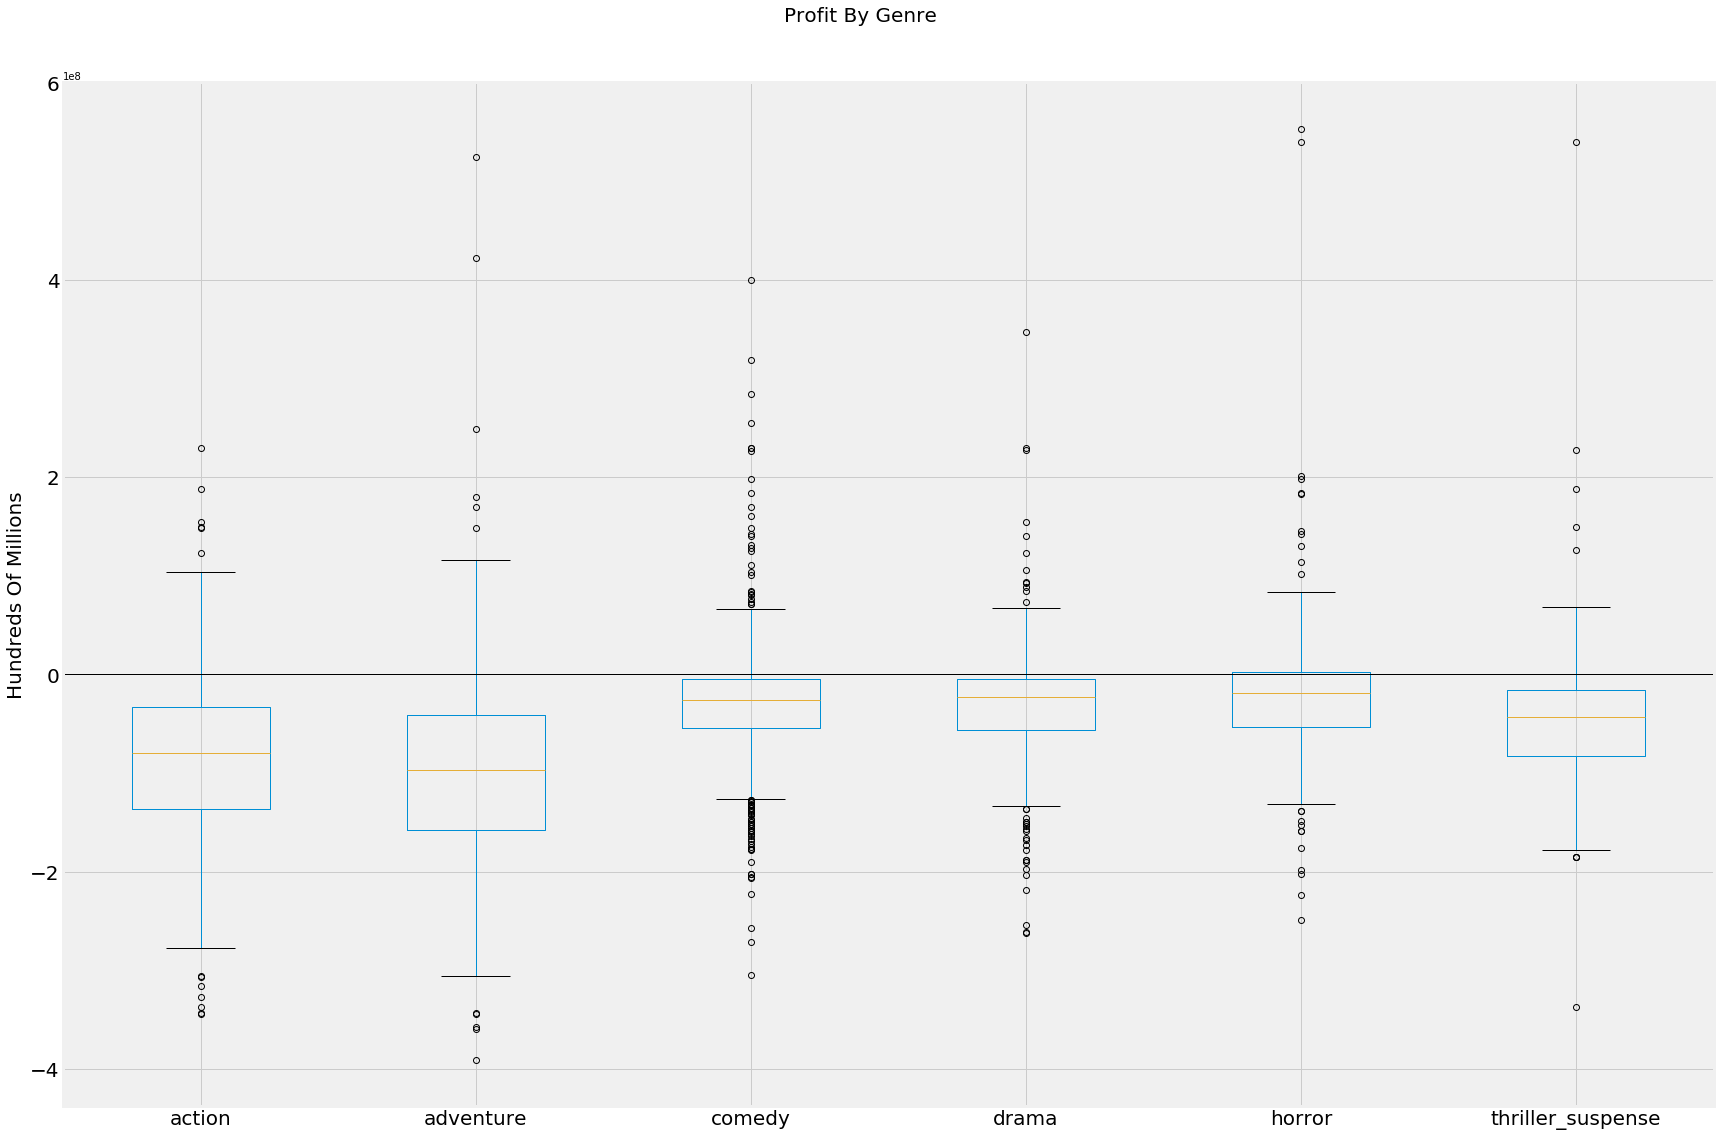

In [46]:
plot_boxplot(data=data, genres=genres, title='Profit By Genre', columns=profit_columns, starting_year=1970, y_label='Hundreds Of Millions')

## Quick Takeaways

**Long right tails and negative medians!**
  - All genres have negative median profit.
  - All genres have those glorious right tails (meaning big earners), the mega-super-duper-blockbuster hits.
  - Comedy, Drama, and Horror have many mega-losers.
  - Horror, Thriller/Suspense, and Adventure have the highest profiting single movies.
  
**Distribution shapes**
  - Action and Adventure have very similar distribution patterns.
  - Comedy, Drama, Horror, and Thriller/Suspense also share similar distribution patterns (notwithstanding the frequency of outliers).

## Median Profits By Subgenre

In [47]:
# Custom function to plot profit data of our subgenres. The genres are sorted from highest to lowest profit stat.
def profit_by_subgenres(data, genres, aggregation_function='median', apply_function=lambda x: x / 1000000):
    sorted_genres = sorted([{'genre': genre, 'amount': (data[data[genre]]['profit'].agg(aggregation_function))} for genre in genres], key=lambda k: k['amount'], reverse=True)
    genres_list = [item['genre'] for item in sorted_genres]
    color_list = generate_color_list(colors_needed=1, order_list=genres_list)
    
    figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 54))
      
    for genre, color, axis in zip(genres_list, color_list, axes.flat): 
        overall_stat = data[data[genre]]['profit'].agg(aggregation_function) / 1000000
    
        (data[data[genre]].groupby('genres_mojo')['profit'].agg(aggregation_function).apply(apply_function).sort_values(ascending=False)).plot(kind='bar', ax=axis, color=color)

        axis.axhline(overall_stat, color='k', linewidth=1)
        axis.tick_params(labelsize=20)
        axis.set_xlabel('')
        axis.set_ylabel('Millions', fontsize=20)
        axis.set_title('{} Profit By {} Subgenres'.format(aggregation_function.title(), genre.title()), fontsize=20, y=1.02)
        axis.legend(['Overall {}: {:.1f}'.format(aggregation_function.title(), overall_stat)], loc=3, fontsize=20)
        autolabel(axis)
        
    plt.tight_layout()

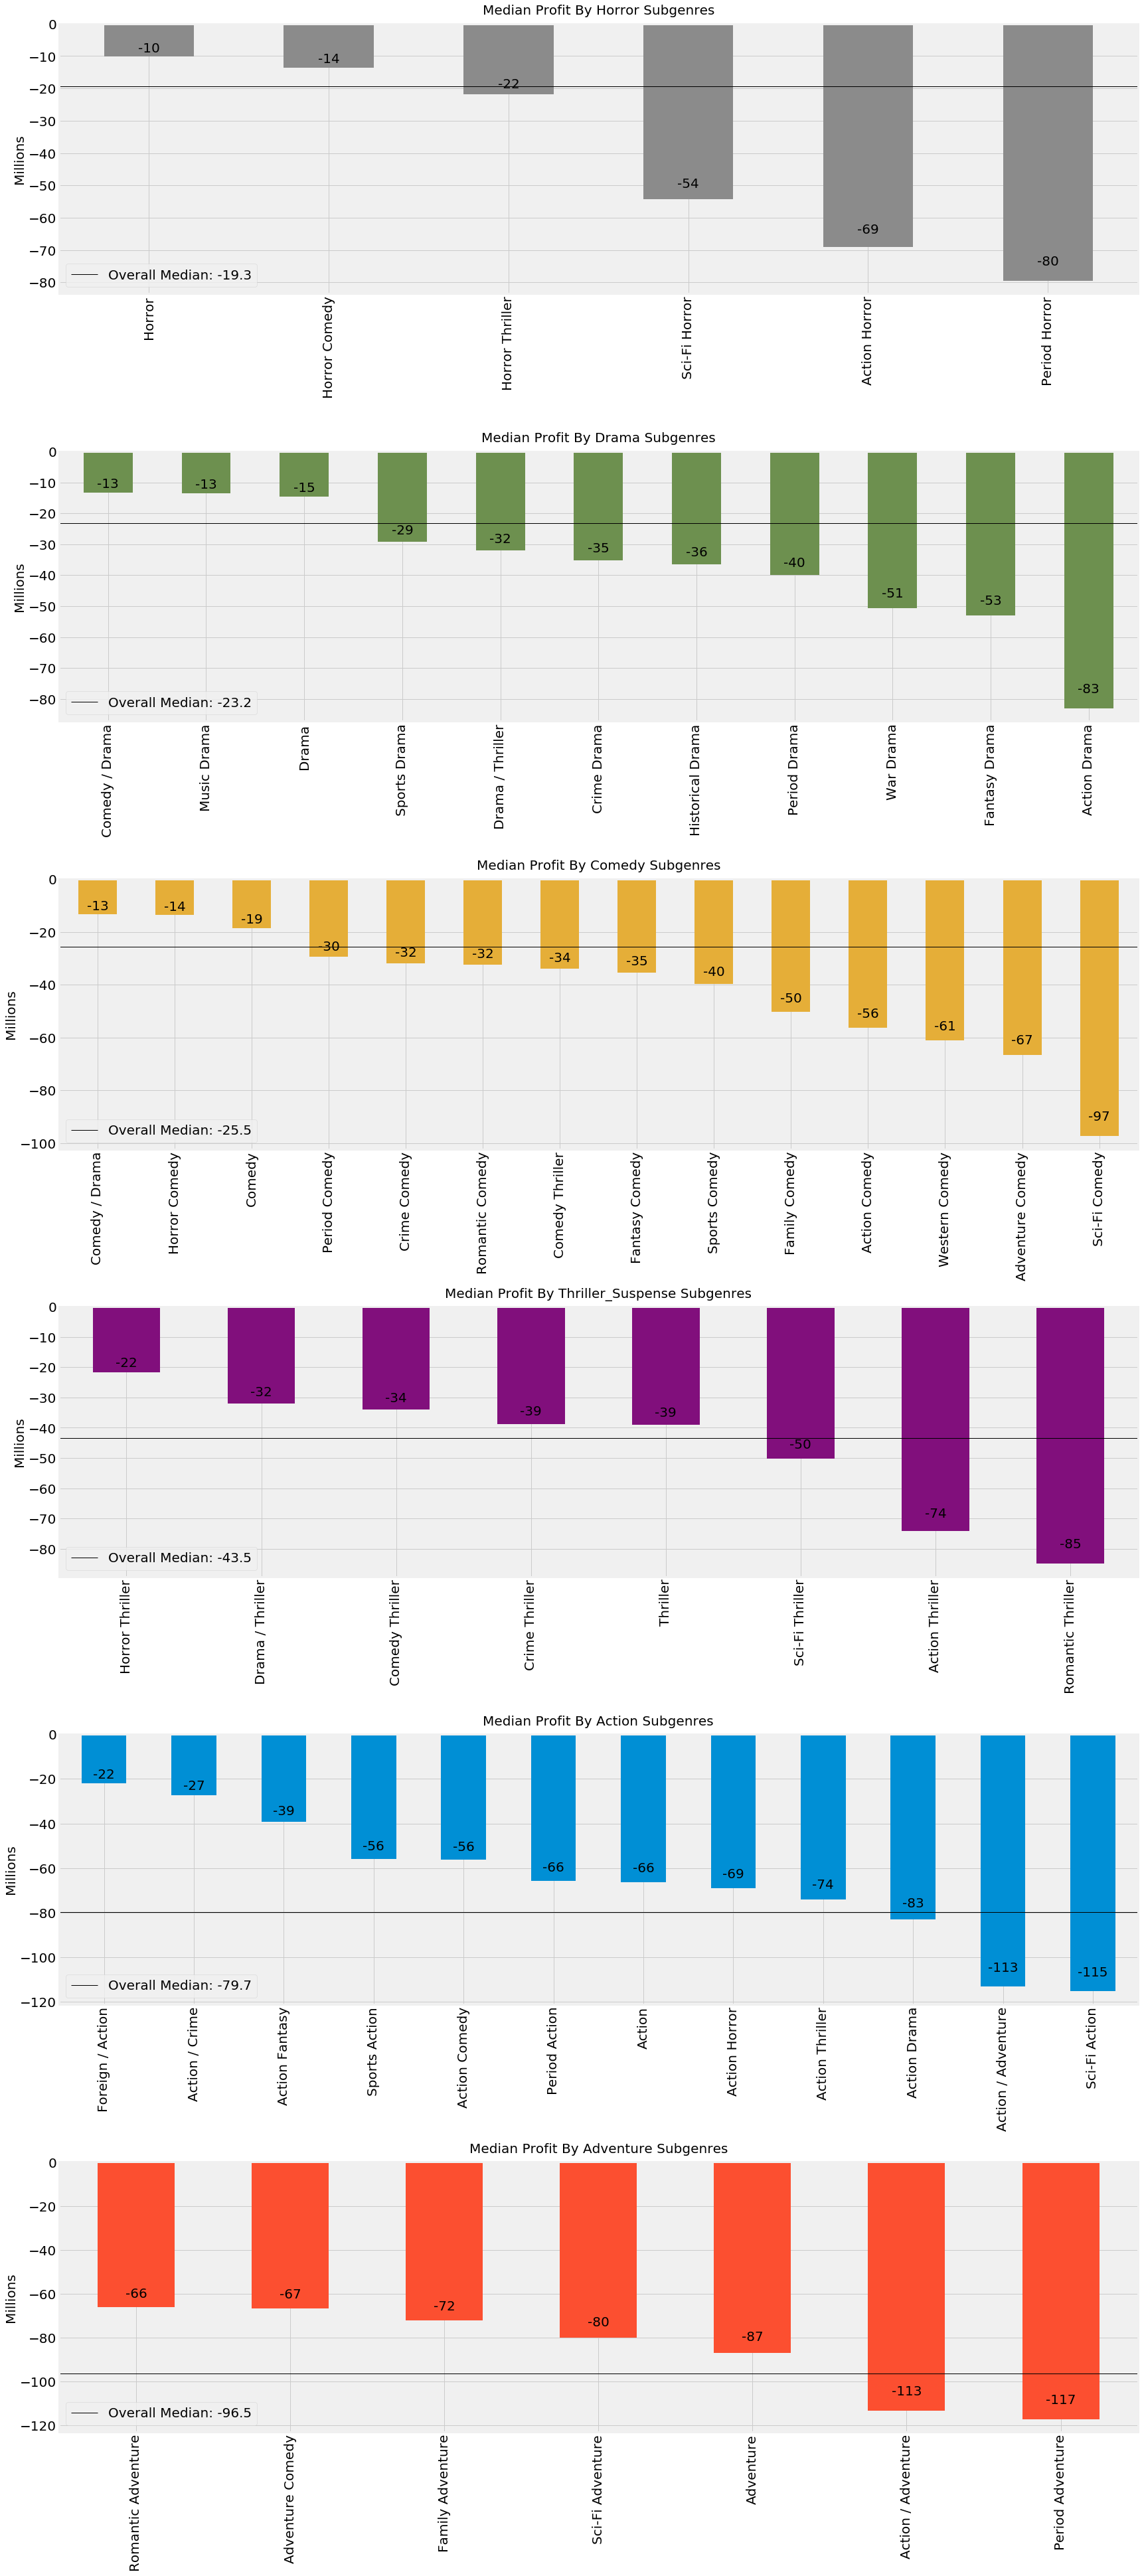

In [48]:
profit_by_subgenres(data=data, genres=genres, aggregation_function='median', apply_function=lambda x: x / 1000000)

## Quick Takeaways

**The domestic market isn't enough**
  - No genre (or any of its subgenres) has a positive median domestic profitability.
  - Action and Adventure are the worst in terms of median losses.
  
**Best subgenres?**
  - It's hard to declare any subgenre as "best" when they are all median losers, but the highest earning ones are:
    - Horror: <span style='color:red'>-&#0036;10 million</span>
    - Comedy/Drama: <span style='color:red'>-&#0036;13 million</span>
    - Music Drama: <span style='color:red'>-&#0036;13 million</span>
    - Horror/Comedy: <span style='color:red'>-&#0036;14 million</span>
    - Drama: <span style='color:red'>-&#0036;15 million</span>

## Mean Profits By Subgenre

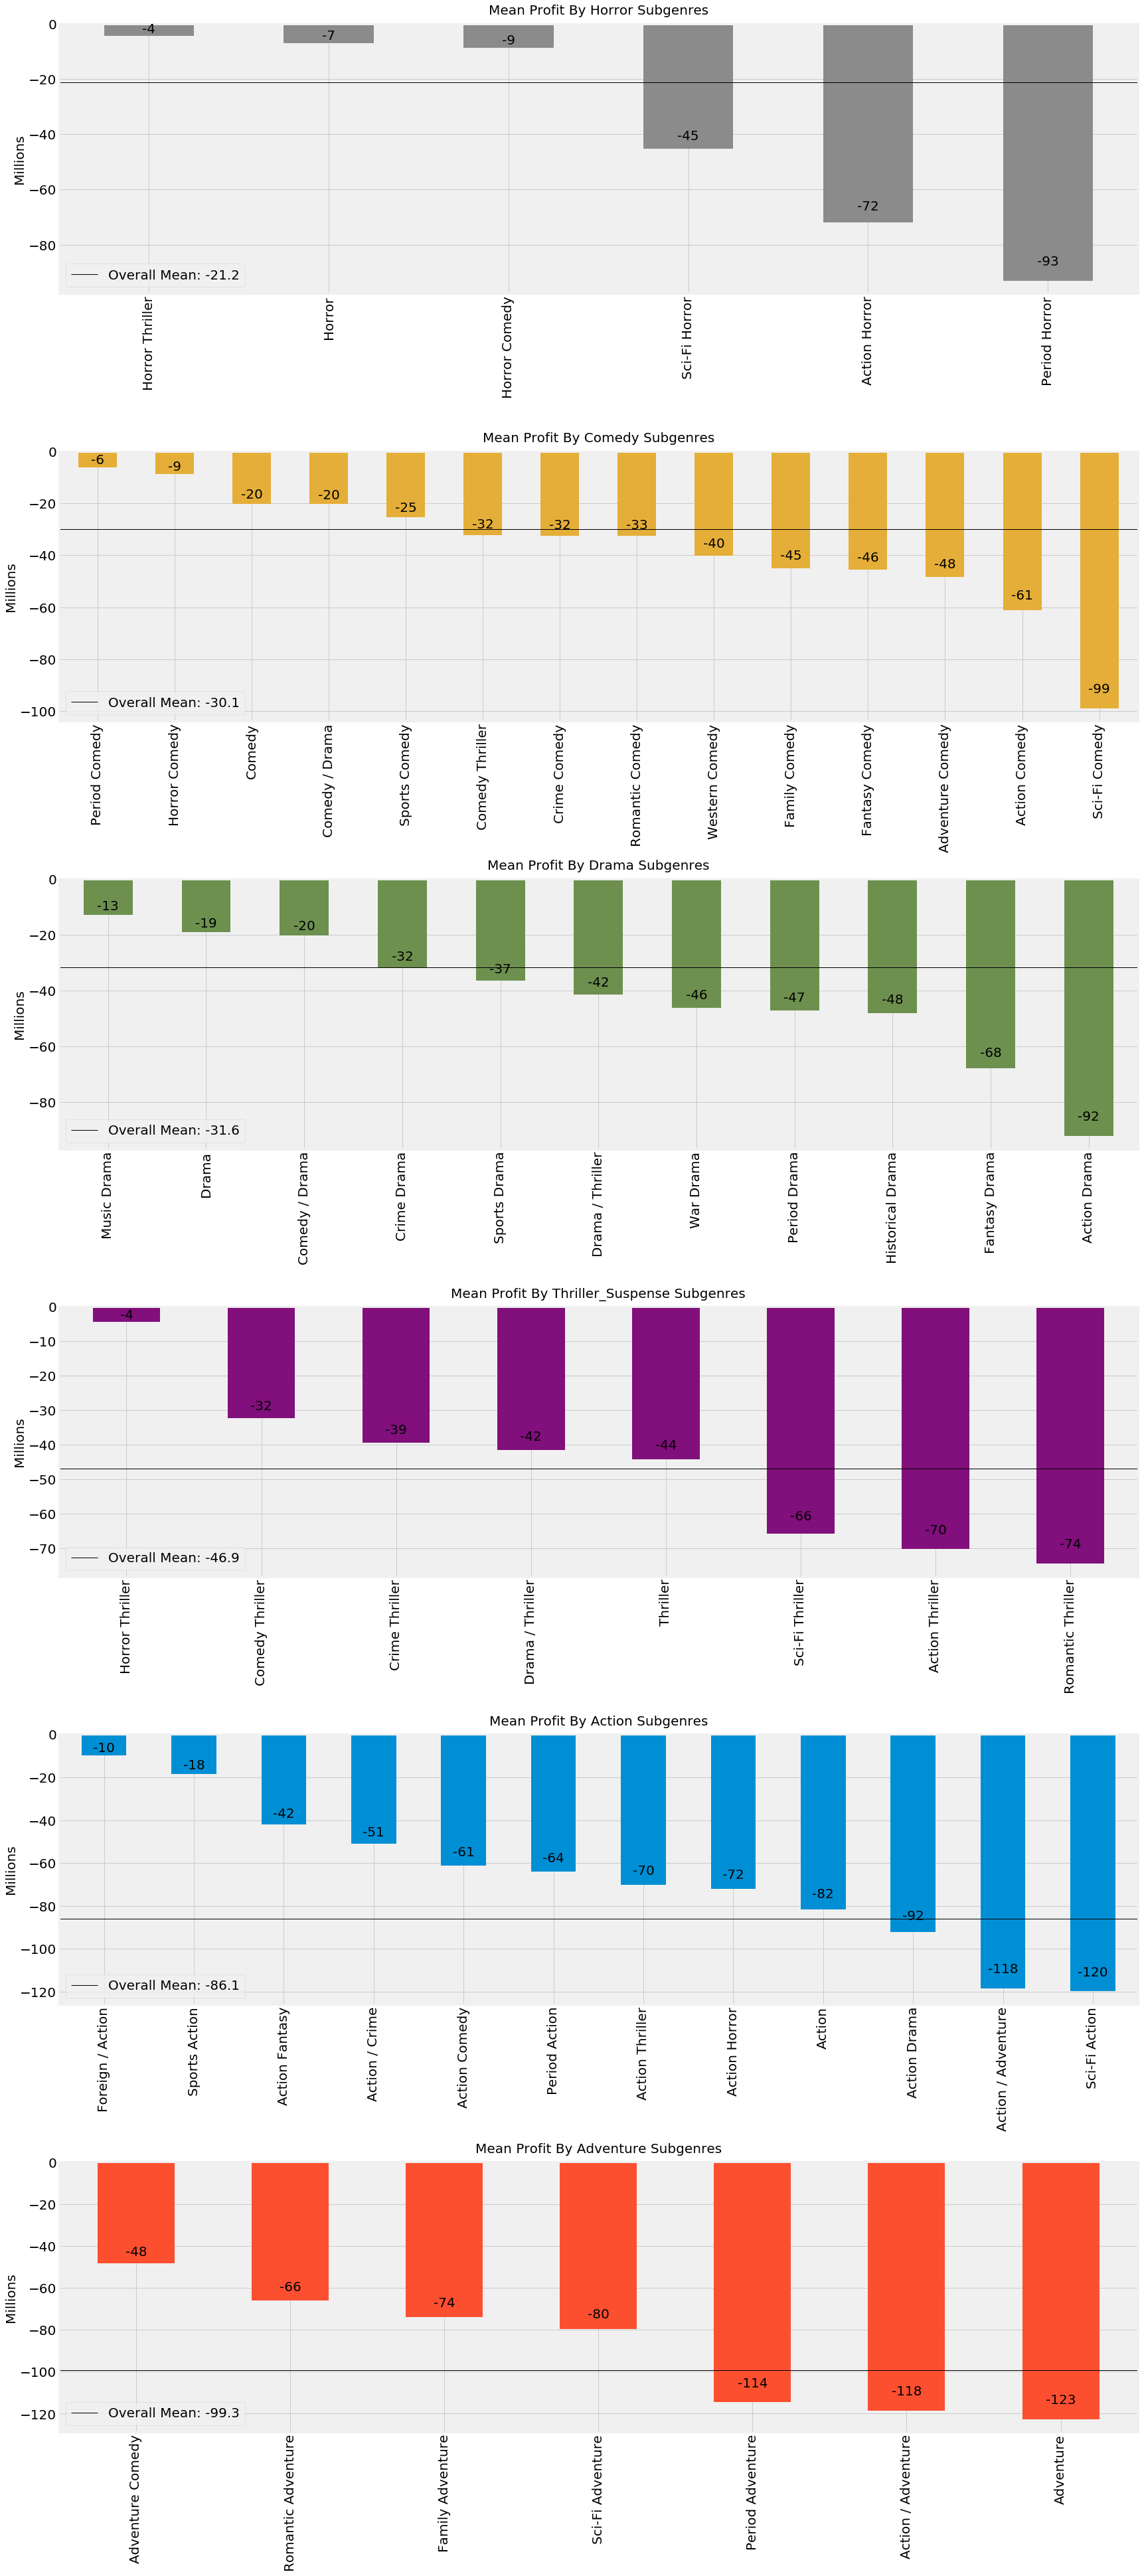

In [49]:
profit_by_subgenres(data=data, genres=genres, aggregation_function='mean', apply_function=lambda x: x / 1000000)

## Quick Takeaways

**Results are similar to median profits by subgenre**
  - All genres and subgenres are median losers in terms of profit.
  - The worst-performing genres are again Action and Adventure.

## Earnings Divided By Expenses (Or Dollars Earned Per Dollar Spent)

Here's another way to measure how successful a genre is -- you look at the ratio of earnings to expenses.

In other words, for each movie we capture **(Worldwide Box Office / 2) / (1.5 * Production Budget)**.

Then for each genre, we can either add up all the results (i.e. see how the genre fares for every datapoint we have), take the median, or take the mean.

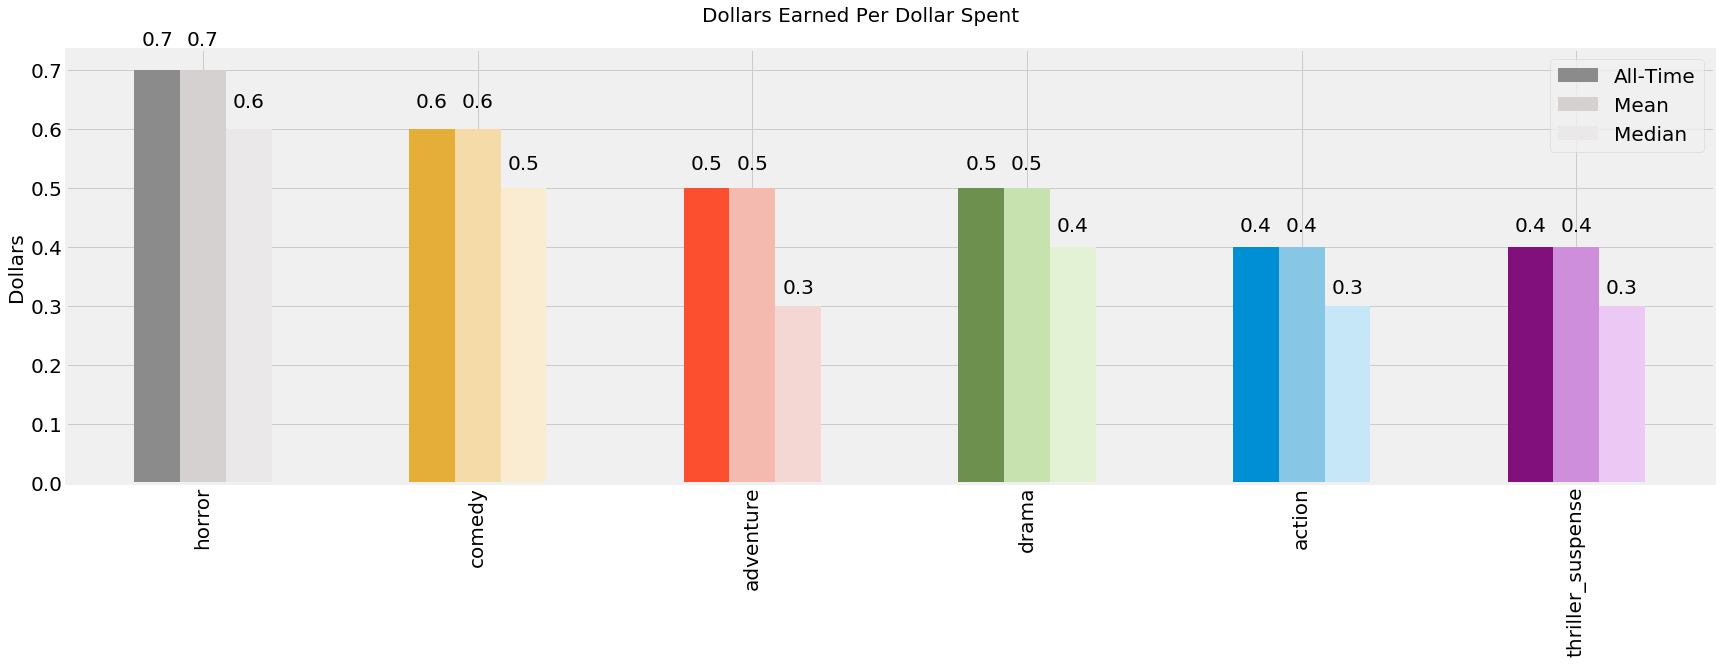

In [50]:
plot_summary_dataframe(summary=summary, sort_column='dollars_earned_for_dollars_spent', 
                       plot_columns=['dollars_earned_for_dollars_spent', 'mean_dollars_earned_for_dollars_spent', 'median_dollars_earned_for_dollars_spent'], 
                       title='Dollars Earned Per Dollar Spent', colors_needed=3, legend_needed=True, 
                       legend_text=['All-Time', 'Mean', 'Median'], y_label='Dollars', num_decimals=1)

## Quick Takeaways

**We need the international market**
  - Horror is the best case scenario here, with a median &#0036;0.60 earned for every dollar spent.
  - Comedy has a median 50% loss on every dollar spent.
  - The remaining four genres fare even worse.

# Percentage Chance To Break Even

We can calculate the percentage chance a movie has to break even as another way to judge relative risk.

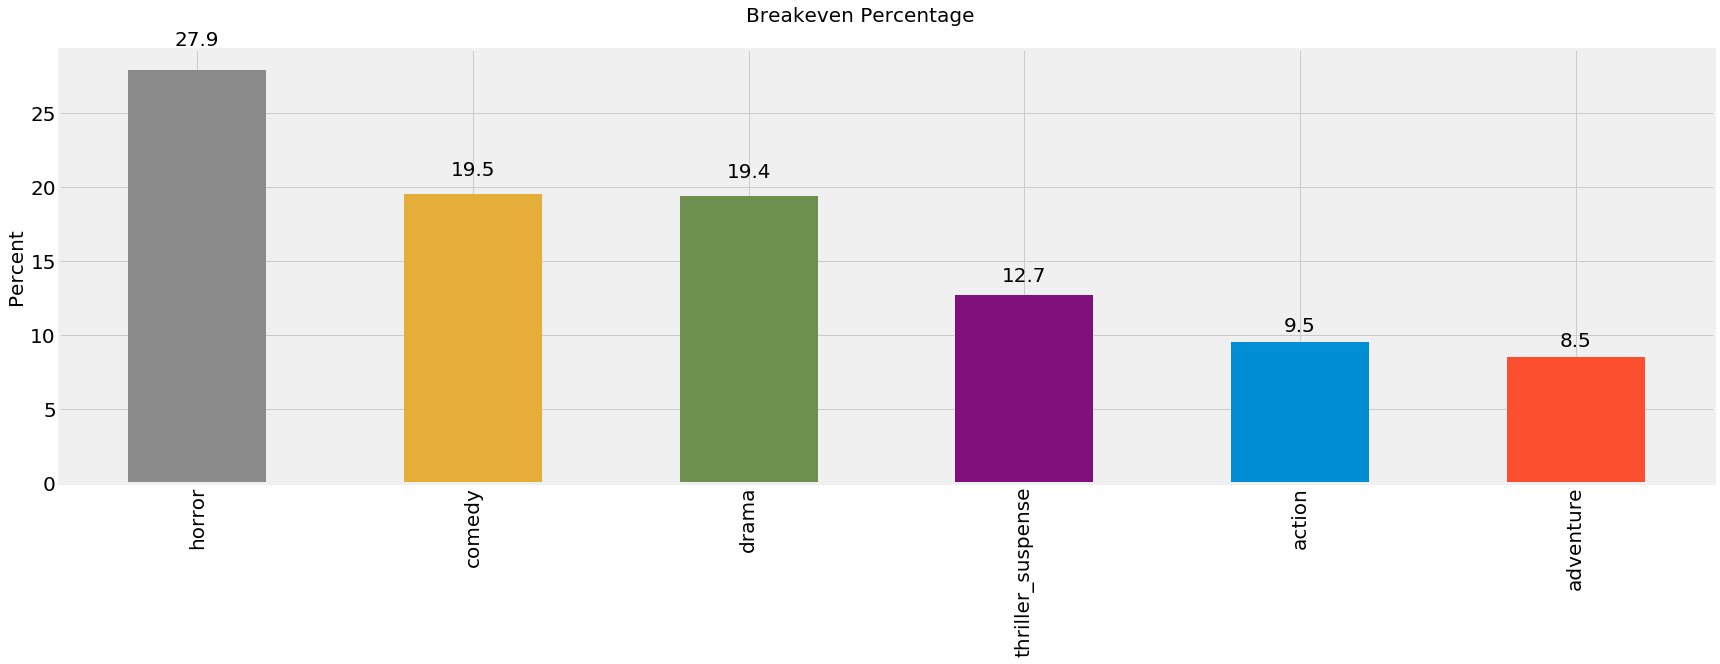

In [51]:
plot_summary_dataframe(summary=summary, sort_column='breakeven_percentage', plot_columns='breakeven_percentage', 
                       title='Breakeven Percentage', colors_needed=1, legend_needed=False, 
                       legend_text=[], y_label='Percent', num_decimals=1)

## Quick Takeaways

**Less than 30%**
  - All genres have a less than 30% chance of breaking even domestically.
  - The least risky one just from a breakeven perpective is Horror.
  - The next least risky genres are Comedy and Drama.

# If A Decision Must Be Made Now

This would be a difficult decision to make.

From the 1970s to today, Comedy and Drama are the two most frequently produced genres with 995 and 680 movies, respectively. 

Comedy, Action, and Adventure have made the most overall money domestically. Adventure and Action have far higher median domestic grosses than Comedy (\\$106 million and \\$87 million versus \\$48 million). Comedy must be making up for this with its higher numbers of movies released. However, Adventure and Action are the two most expensive genres to make (\\$117 million and \\$87 million), whereas Comedy is fourth at \\$36 million.

The highest aggregate return for every dollar spent comes from Horror, then Comedy. 

The highest median return for every dollar spent also comes from Horror, then Comedy.

The highest median profit per genre is Horror, then Drama, then Comedy. (Note though that all three of these numbers are negative, since no genre has a positive median profit all-time.)

The genres with the lowest median budgets are Drama (\\$30 million), then Horror (\\$31 million), then Comedy (\\$36 million).

Genres with the best chance to breakeven are Horror, then Comedy, then Drama.

## A Few Strategies

### "Let's not lose *too much* money" strategy

Since all genres are median losers domestically, if our distribution strategy only includes the domestic market, we shouldn't hope to come out ahead in the long run. However, if pushed to select the best genres, I would suggest Horror, then either Comedy or Drama. 

Horror is one of the cheapest genres to produce and yet it has the highest median profit per genre. It also has the highest chance to break even. Our bosses could make around three Horror movies for the price of a single Action movie, or four Horror movies for the price of one Adventure movie. Horror's median gross of \\$53 million is well below Action's \\$87 million and Adventure's \\$106 million, but it would be a safer play.

It's tough to decide if the next best option is Comedy or Drama.

Comedy has the third cheapest median budget and the third highest median profit. Historically, it is a solid genre, as it has earned in aggregate the most amount of box office dollars. It also earns the second-most amount of money on a per-dollar spent basis. 

Drama has the cheapest median budget, the second-highest median profit, and the third-highest chance to break even. So while these movies tend to break even less often than Comedies, they tend to be less expensive to produce and make more money, on average.

### "Swing for the fences" strategy

If our bosses really care about releasing those mega blockbusters and risk be damned, then we all know they're talking about Action and Adventure, the kings of the right tails. They have by far the highest median grosses, but are also the biggest median losers (<span style='color:red'>-\\$79.7 million</span> and <span style='color:red'>-\\$96.5 million</span>) respectively. 

They also have the lowest chance to break even, at 9.5% for Action and 8.5% for Adventure.

These two genres require the additional revenue of the international box office the most for survival.

For the domestic market specifically, I'd stay away from Action and Adventure, and focus on Horror and either Comedy or Drama.

## Disclaimer

There are a lot of reasons why studios prefer to make certain genres over others. After all, it's tough to make theme park rides based on Drama and Comedy movies. This analysis assumes we only care about how much money a movie makes at the box office.

## Let's Keep Digging

So far, we have only analyzed these genres in aggregate. 

Our bosses want more pinpoint accuracy. Which genres are the hottest right now? Which genres perform the best during which parts of the year?

So we've got more digging to do, and we'll next look for trends by Release Decade and Release Week. 

# Performance By Decade

We will now dive into the performance of movies by decade of release.

- 15.1 Create a custom function to facilitate plotting by time as well as a statistic.
- 15.2 Look at how the number of movies released has changed over time for all genres.
- 15.3 Summarize our findings.
- 15.4 Look at how domestic box office grosses have changed over time for all genres. 
- 15.5 Look at how production budgets have changed over time for all genres. 
- 15.6 Summarize our findings.
- 15.7 Look at how profits have changed over time for all genres.
- 15.8 Summarize our findings.
- 15.9 Look at how the breakeven percentages have changed over time for all genres.
- 15.10 Summarize our findings.
- 15.11 Look at how domestic box office grosses have changed over time for the subgenres of our main genres.

## Create Custom Function To Plot By Time As Well As A Statistic

Up until now, we haven't been looking at our data from a time perspective. We have only been looking at movies by genre.

It's time to look at our data by genre and by decade.

To make graphing easier, we create a custom function to help us do this.

In [52]:
def plot_by_time_and_stat(data, genres, title, groupby_column, stat_columns, aggregate_function, apply_needed=False, apply_function=None, y_label='', y_ticks_needed=False, y_ticks='', legend_needed=True, legend_text=genres, color=colors, axhline_needed=False, axhline_value='', autolabel_needed=False, autolabel_fontsize=20):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24,9))
    figure.suptitle(title, fontsize=20)
    
    if apply_needed: 
        data.groupby(groupby_column)[stat_columns].agg(aggregate_function).apply(apply_function).plot(kind='bar', ax=axis, color=color)
    else: 
        data.groupby(groupby_column)[stat_columns].agg(aggregate_function).plot(kind='bar', ax=axis, color=color)
        
    axis.set_xlabel('')
    axis.set_ylabel(y_label, fontsize=20)
    axis.tick_params(labelsize=20)
    
    if legend_needed: 
        axis.legend(legend_text, loc='best', fontsize=15)
    
    if y_ticks_needed:
        axis.set_yticks(y_ticks)
        
    if axhline_needed:
        axis.axhline(axhline_value, color='k', linewidth=1)
        
    if autolabel_needed:
        autolabel(axis, fontsize=autolabel_fontsize)

## Number of movies

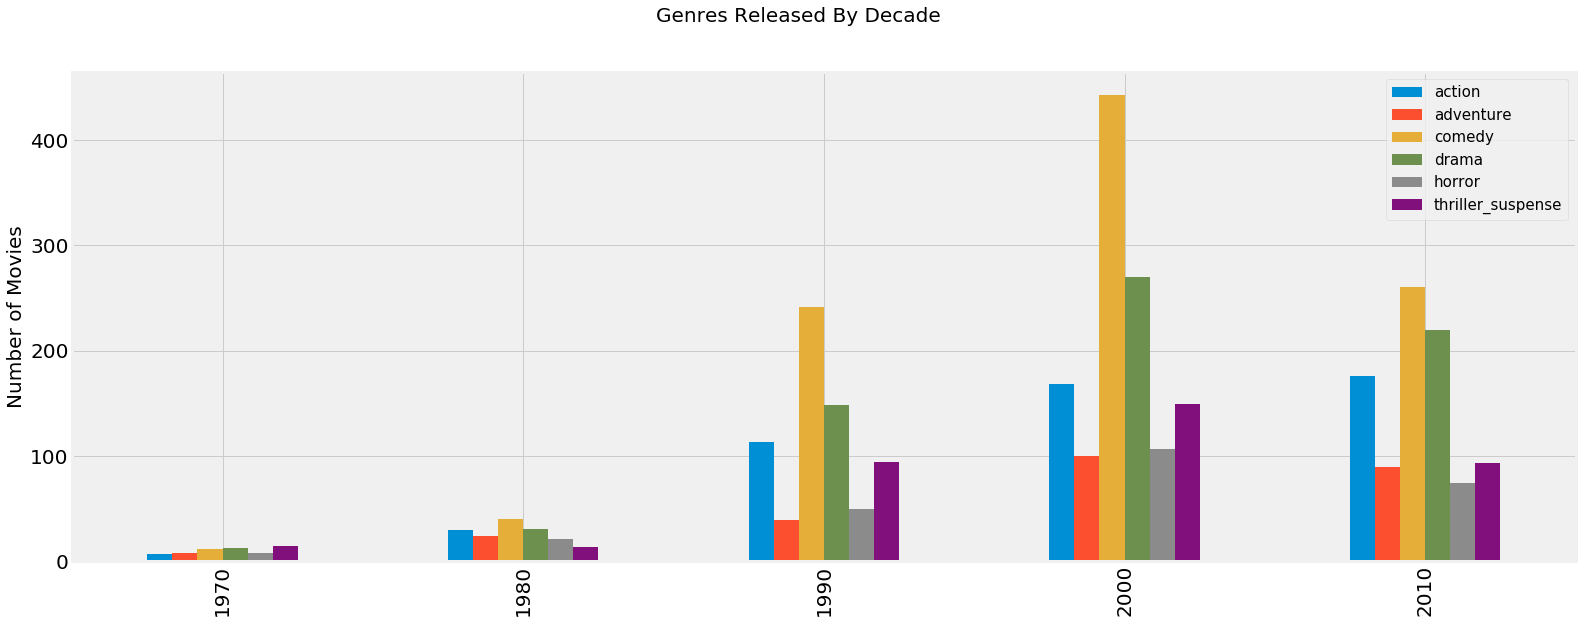

In [53]:
plot_by_time_and_stat(data=data, genres=genres, title='Genres Released By Decade', 
                      groupby_column='release_decade', stat_columns=genres, aggregate_function='sum', 
                      apply_needed=False, apply_function=None, y_label='Number of Movies', y_ticks_needed=False, y_ticks='')

## Quick Takeaways

**1970s to 2000s**
  - We see huge increases in the number of movies released per genre.
  - Comedy and Drama are the most produced genres from then to the present by a wide margin.
  
**2000s to 2010s**
  - We see a reduction in the number of movies released for all genres except Action. 
  
**Fewer movies made now**
- Our gut should tell us movies are not as profitable now as they used to be because the Big Five release far fewer movies now than they did in the 2000s.

## Grosses

### Not Separated By Genre

We will look at a couple graphs to get a sense of our movies without separating them by genre.

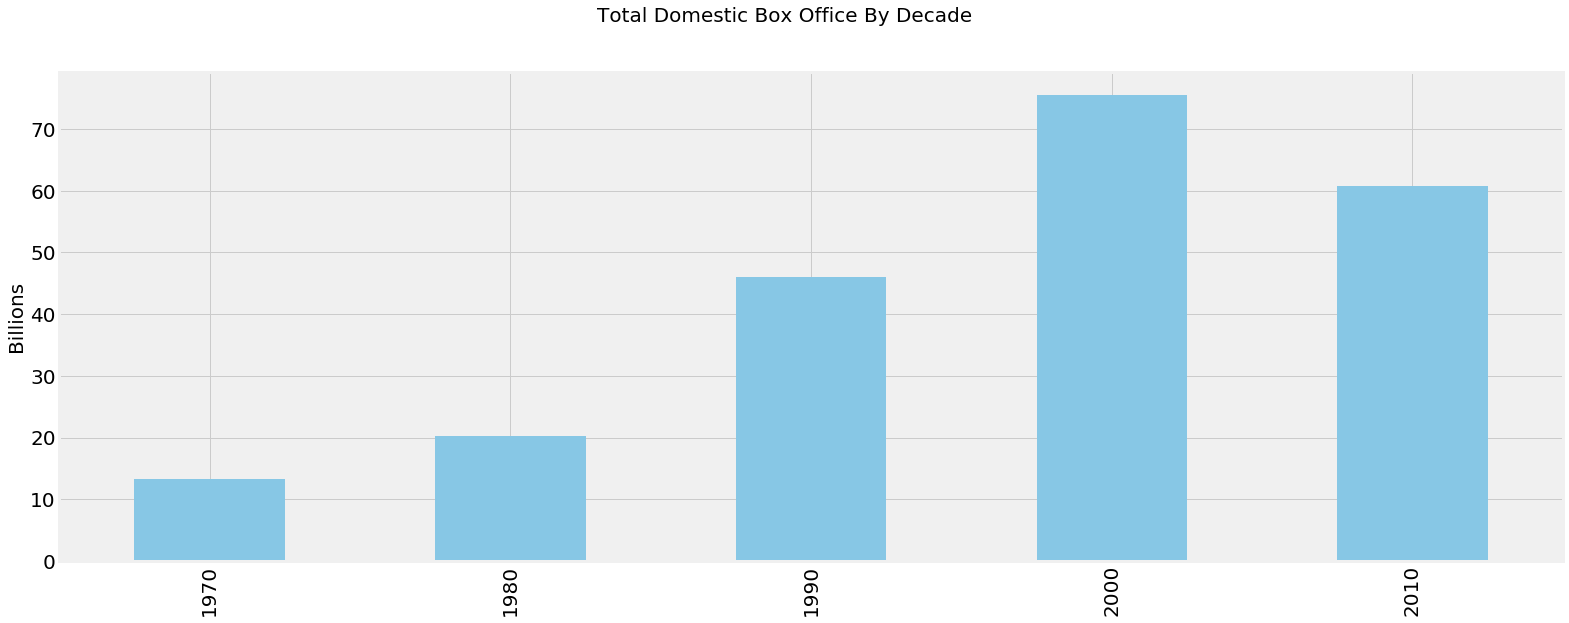

In [54]:
plot_by_time_and_stat(data=data, genres=genres, title='Total Domestic Box Office By Decade', 
                      groupby_column='release_decade', stat_columns='domestic_adj', 
                      aggregate_function='sum', apply_needed=True, apply_function=lambda x: x / 1000000000, 
                      y_label='Billions', y_ticks_needed=False, y_ticks='', legend_needed=False, 
                      legend_text='', color=genres_dict['action']['color2'])

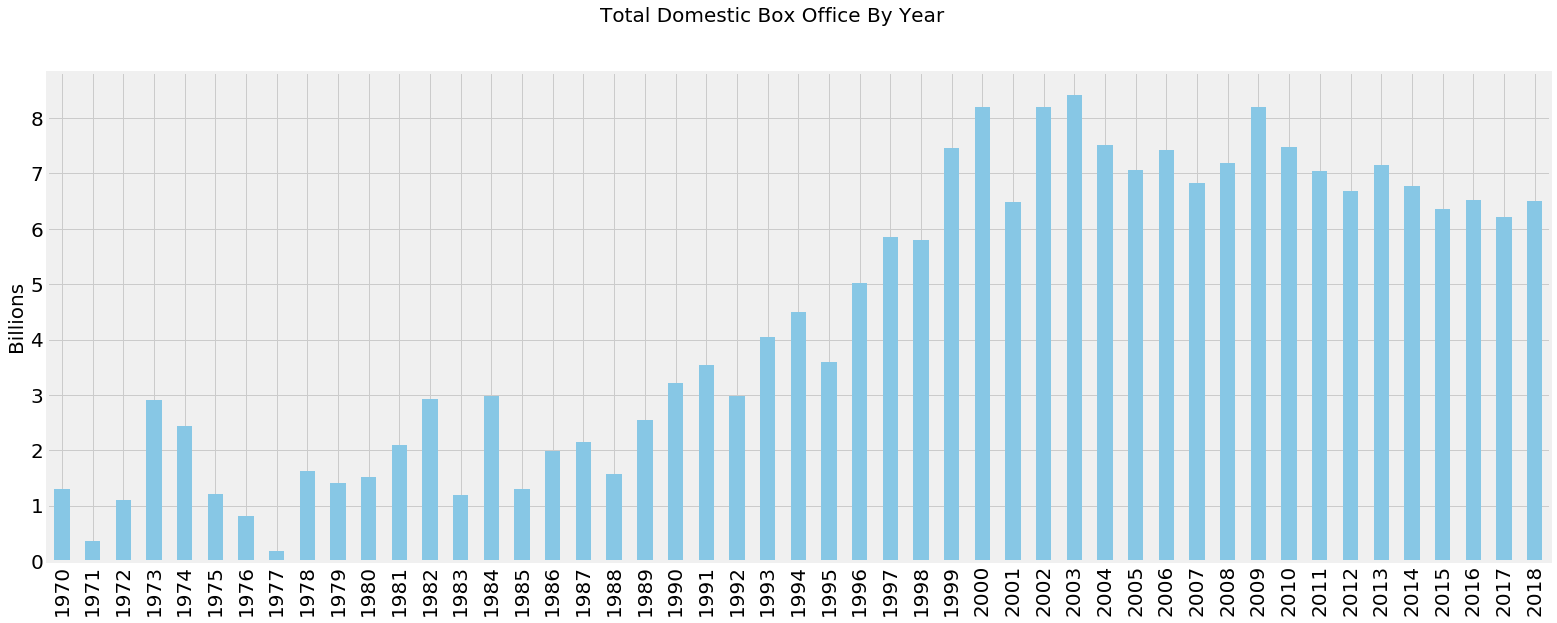

In [55]:
plot_by_time_and_stat(data=data, genres=genres, title='Total Domestic Box Office By Year', 
                      groupby_column='release_year', stat_columns='domestic_adj', 
                      aggregate_function='sum', apply_needed=True, apply_function=lambda x: x / 1000000000, 
                      y_label='Billions', y_ticks_needed=False, y_ticks='', legend_needed=False, 
                      legend_text='', color=genres_dict['action']['color2'])

### Separated By Genre

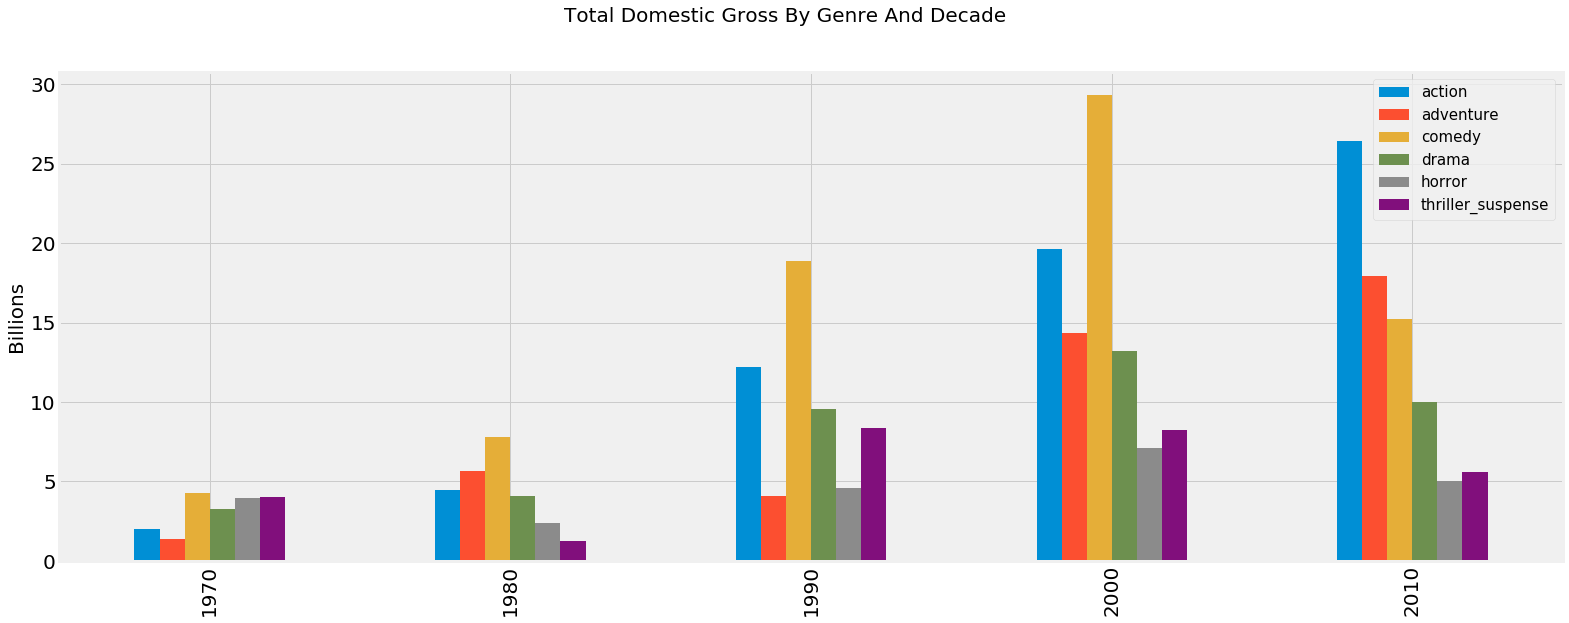

In [56]:
plot_by_time_and_stat(data=data, genres=genres, title='Total Domestic Gross By Genre And Decade', groupby_column='release_decade', stat_columns=gross_columns, aggregate_function='sum', apply_needed=True, apply_function=lambda x: x / 1000000000, y_label='Billions', y_ticks_needed=False, y_ticks='')

In [57]:
# Create custom function to determine the background color for labeling the genre with the highest stat per decade
def find_genre_for_background_color(groupby_instance, decade):
    column_name_list = groupby_instance.loc[decade].sort_values(ascending=False).index[0].split('_')
    
    # Check if the split string has length 4, if so it is thriller_suspense and requires extra filtering
    # The reason is our genres are 'action', 'adventure', 'comedy', 'drama', 'horror', and 'thriller_suspense'
    # Our worldwide stat column names have the following form: worldwide_(stat name)_genre
    # Thus five of our six genres will have length 3 when split on '_', but 'thriller_suspense' will have length 4
    if len(column_name_list) == 4:
        return '_'.join(column_name_list[-2:])
    
    # If the genre is not 'thriller_suspense', we just need the last word in the list
    return column_name_list[-1]

In [58]:
# Create a stacked bar plot of a stat by genre for each year, highlighting the genre with the highest value in each decade 
def plot_stat_by_year_and_highlight_decade_winner(data, genres, title, stat_columns, aggregation_function, apply_function=None, y_label=''):
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
    figure.suptitle(title, fontsize=20, y=1.05)

    # Determine background colors for each decade
    grp = data.groupby('release_decade')[stat_columns].agg(aggregation_function)
    bg_1970 = genres_dict[find_genre_for_background_color(grp, 1970)]['color1']
    bg_1980 = genres_dict[find_genre_for_background_color(grp, 1980)]['color1']
    bg_1990 = genres_dict[find_genre_for_background_color(grp, 1990)]['color1']
    bg_2000 = genres_dict[find_genre_for_background_color(grp, 2000)]['color1']
    bg_2010 = genres_dict[find_genre_for_background_color(grp, 2010)]['color1']

    # Set up plot
    grp = data.groupby('release_year')[stat_columns].agg(aggregation_function).apply(apply_function)
    grp.plot(kind='bar', stacked=True, ax=axis)
    axis.set_ylabel(y_label, fontsize=20)
    axis.set_xlabel('')
    axis.tick_params(labelsize=20)
    axis.legend(genres, fontsize=20)
    axis.axvspan(0, 10, color=bg_1970, alpha=0.2)
    axis.axvspan(10, 20, color=bg_1980, alpha=0.2)
    axis.axvspan(20, 30, color=bg_1990, alpha=0.2)
    axis.axvspan(30, 40, color=bg_2000, alpha=0.2)
    axis.axvspan(40, 50, color=bg_2010, alpha=0.2)
    axis.axvline(10, color='k', alpha=0.2)
    axis.axvline(20, color='k', alpha=0.2)
    axis.axvline(30, color='k', alpha=0.2)
    axis.axvline(40, color='k', alpha=0.2)

    plt.tight_layout()

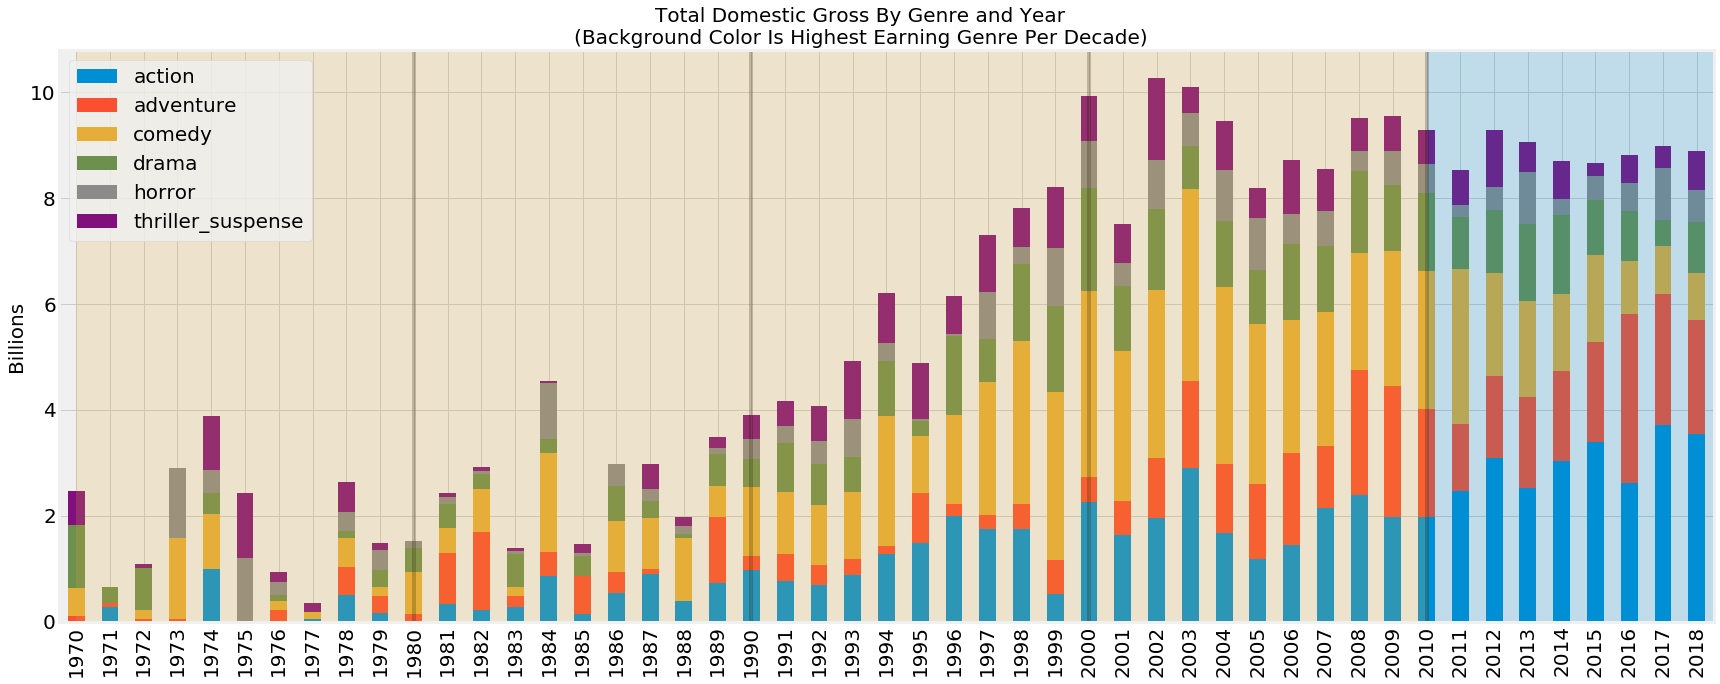

In [59]:
plot_stat_by_year_and_highlight_decade_winner(data=data, genres=genres, 
                                              title='Total Domestic Gross By Genre and Year\n(Background Color Is Highest Earning Genre Per Decade)', 
                                              stat_columns=gross_columns, aggregation_function='sum',
                                              apply_function=lambda x: x / 1000000000, y_label='Billions')

### Quick Takeaways

**Domestic box office decrease in 2010s**
  - The total domestic box office increased every decade from the 1970s to the 2000s.
  - It decreased in the 2010s.

**Highest-grossing genres**
  - Comedy was the highest grossing genre from the 1970s to the 2000s.
  - The highest grossing genre for the current decade is Action.
  
**Last three decades**
  - Only Action and Adventure have had increases in their total domestic box office in each of the last three decades.
  
**From the 2000s to 2010s**
  - Only Action and Adventure have increased their total domestic box office amount over this period.
  - Comedy has only earned about half of its 2000s domestic box office total this decade.
  - Horror and Thriller/Suspense hold the lowest domestic box office amounts over this period.

### Mean and Median Gross

In [60]:
def plot_mean_and_median_by_time_and_stat(data, genres, groupby_column, stat_columns, stat_name_for_title, apply_needed=False, apply_function=None, y_label='', y_ticks_needed=False, y_ticks='', axhline_needed=False, axhline_value=''):
    figure, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
    
    if apply_needed: 
        data.groupby(groupby_column)[stat_columns].agg('mean').apply(apply_function).plot(kind='bar', ax=axis1)
        data.groupby(groupby_column)[stat_columns].agg('median').apply(apply_function).plot(kind='bar', ax=axis2)
    else:
        data.groupby(groupby_column)[stat_columns].agg('mean').plot(kind='bar', ax=axis1)
        data.groupby(groupby_column)[stat_columns].agg('median').plot(kind='bar', ax=axis2)
    
    axis1.set_ylabel(y_label, fontsize=20)
    
    if y_ticks_needed:
        axis1.set_yticks(y_ticks)
        axis2.set_yticks(y_ticks)
        
    axis1.set_xlabel('')
    axis1.tick_params(labelsize=20)
    axis1.legend(genres, fontsize=20)
    axis1.set_title('Mean {} By Genre And Decade'.format(stat_name_for_title), fontsize=20, y=1.02)

    axis2.set_ylabel(y_label, fontsize=20)
    axis2.set_xlabel('')
    axis2.tick_params(labelsize=20)
    axis2.legend(genres, fontsize=20)
    axis2.set_title('Median {} By Genre And Decade'.format(stat_name_for_title), fontsize=20, y=1.02)
    
    if axhline_needed:
        axis1.axhline(axhline_value, color='k', linewidth=1)
        axis2.axhline(axhline_value, color='k', linewidth=1)

    plt.tight_layout()

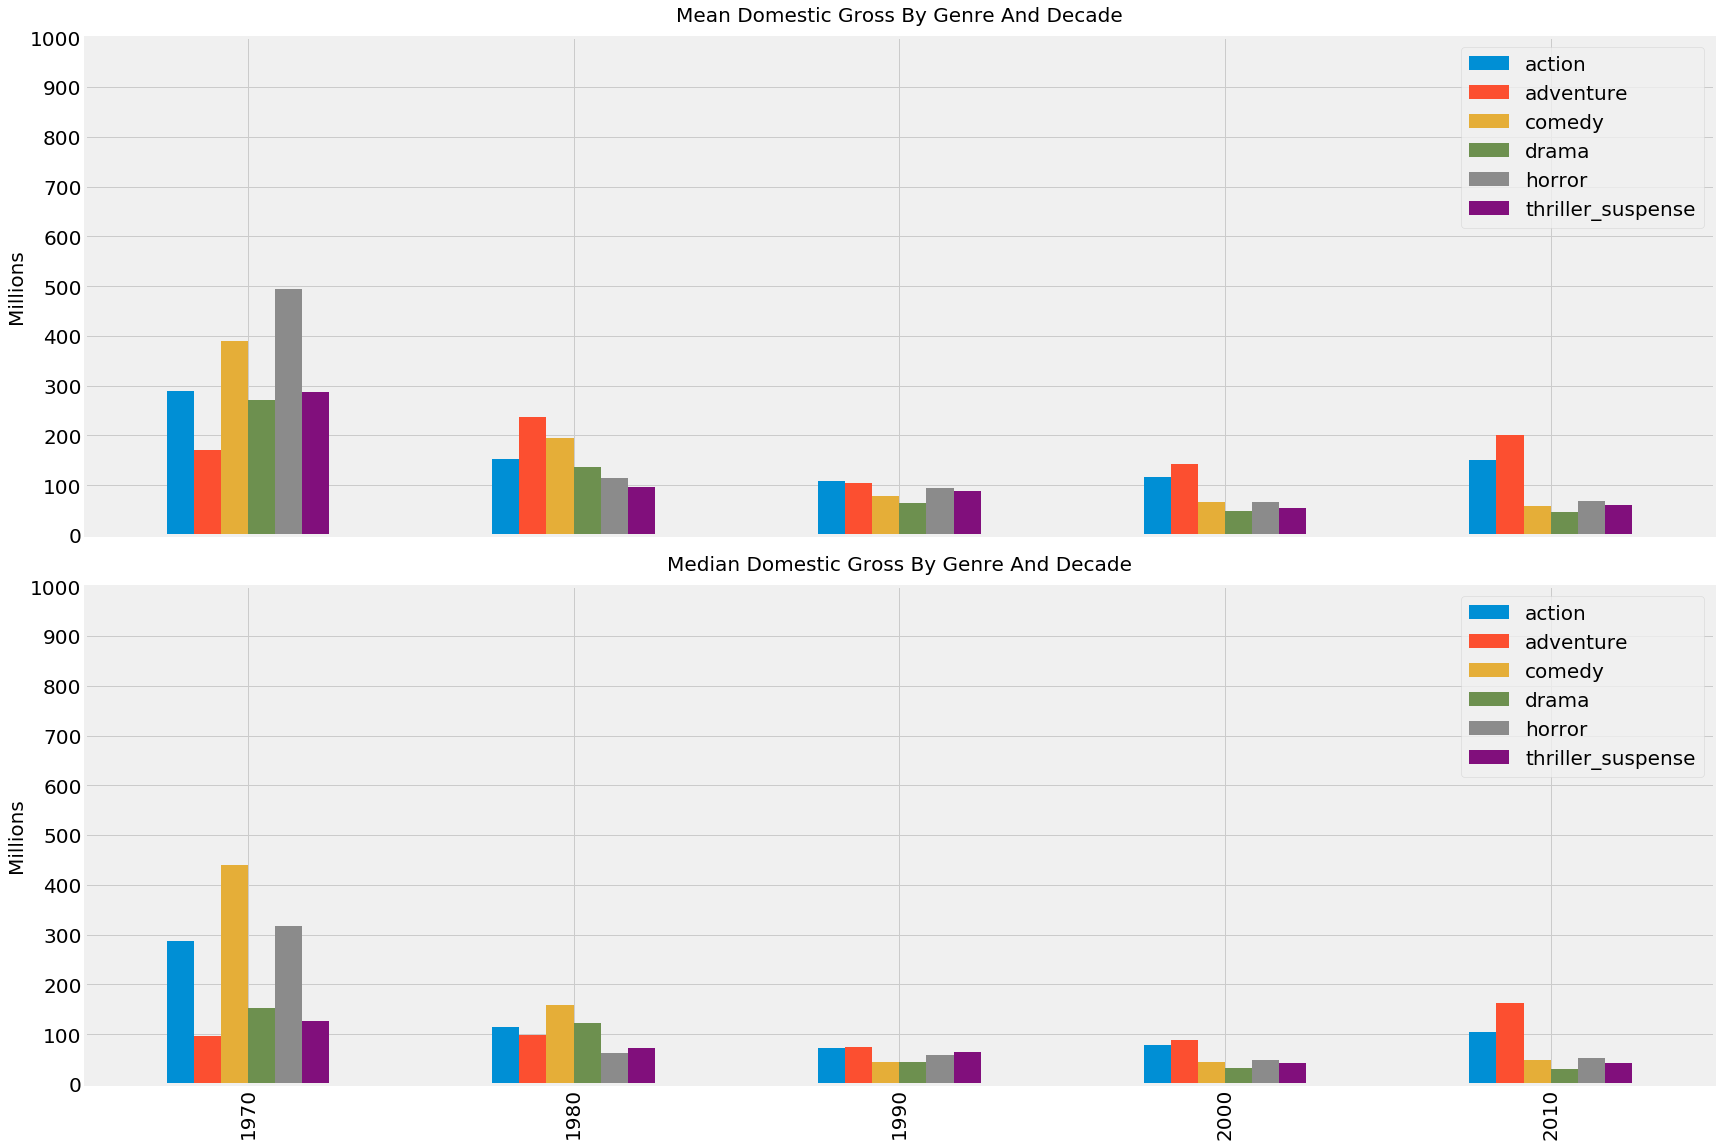

In [61]:
plot_mean_and_median_by_time_and_stat(data=data, genres=genres, groupby_column='release_decade', 
                                      stat_columns=gross_columns, stat_name_for_title='Domestic Gross', 
                                      apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      y_label='Millions', y_ticks_needed=True, y_ticks=range(0, 1100, 100))

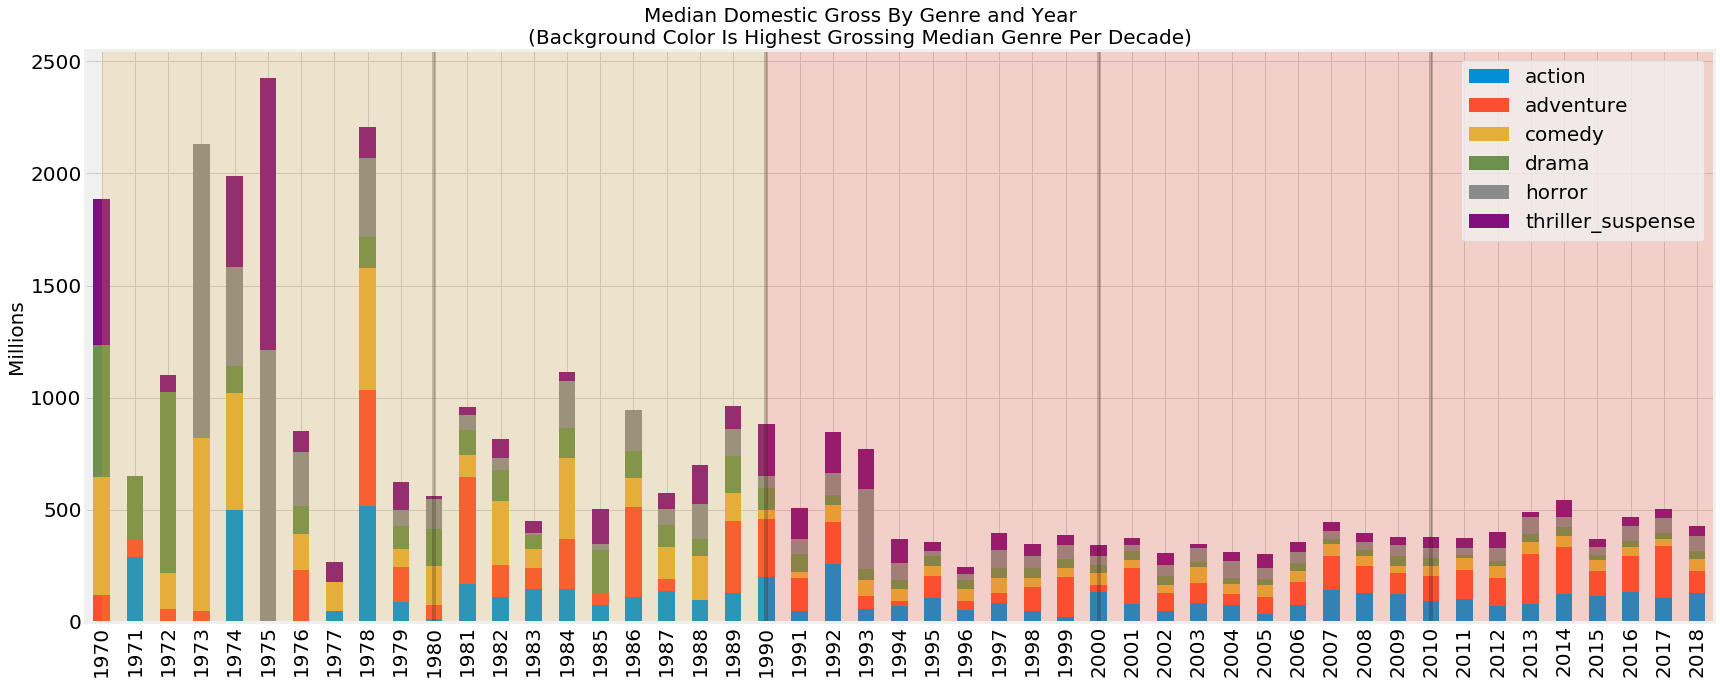

In [62]:
plot_stat_by_year_and_highlight_decade_winner(data=data, genres=genres, 
                                              title='Median Domestic Gross By Genre and Year\n(Background Color Is Highest Grossing Median Genre Per Decade)', 
                                              stat_columns=gross_columns, aggregation_function='median',
                                              apply_function=lambda x: x / 1000000, y_label='Millions')

### Quick Takeaways

**Contracting period, then expanding period**
  - We see an overall contraction in mean/median gross by decade from the 1970s to the 1990s. 
  - For Action, Adventure, and Comedy, their median grosses increase in the 2000s and 2010s.
  - For Drama, Horror, and Thriller/Suspense, their median grosses have a net decrease from the 1990s to the 2010s. 
  
**Median gross change from 2000s to 2010s ranked from highest to lowest**
  - Adventure:         &#0036;73.5 million    -- 82.5%
  - Action:            &#0036;26.5 million  -- 34.0%
  - Horror:            &#0036;3.4 million   -- 6.9%
  - Comedy:            &#0036;2.7 million   -- 6.1%
  - Thriller/Suspense: &#0036;0.07 million   -- 0.1%
  - Drama:             <span style='color:red'>-&#0036;2.1 million</span>    -- <span style='color:red'>-6.6%</span>
  
**Highest median gross by decade**
  - 1970s: Comedy
  - 1980s: Comedy
  - 1990s: Adventure
  - 2000s: Adventure
  - 2010s: Adventure

In [63]:
def one_stat_over_time_in_separate_graphs(data, genres, title, figsize, colors, groupby_column, stat_column, aggregation_function, starting_year=1970, apply_needed=False, apply_function=None, xtick_values='', y_label='', axhline_needed=False, axhline_value=''):
    figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=figsize)
    figure.suptitle(title, fontsize=20, y=1.02)

    for genre, axis, color in zip(genres, axes.flat, colors):    
        # Create a series with decades as indexes and median budget as values
        
        if apply_needed:
            (data[(data[genre]) & (data['release_year'] >= starting_year)].groupby(groupby_column)[stat_column].agg(aggregation_function).apply(apply_function)).sort_index(ascending=True).plot(kind='bar', xticks=xtick_values, ax=axis, linewidth=3, color=color)
        else:
            (data[(data[genre]) & (data['release_year'] >= starting_year)].groupby(groupby_column)[stat_column].agg(aggregation_function)).sort_index(ascending=True).plot(kind='bar', xticks=xtick_values, ax=axis, linewidth=3, color=color)
                
        axis.set_ylabel(y_label, fontsize=20)
        axis.tick_params(labelsize=20)
        axis.set_xlabel('')
        axis.legend([genre], loc=2, fontsize=15)
        autolabel(axis)
        
        if axhline_needed:
            axis.axhline(axhline_value, color='k', linewidth=1)

    plt.tight_layout()

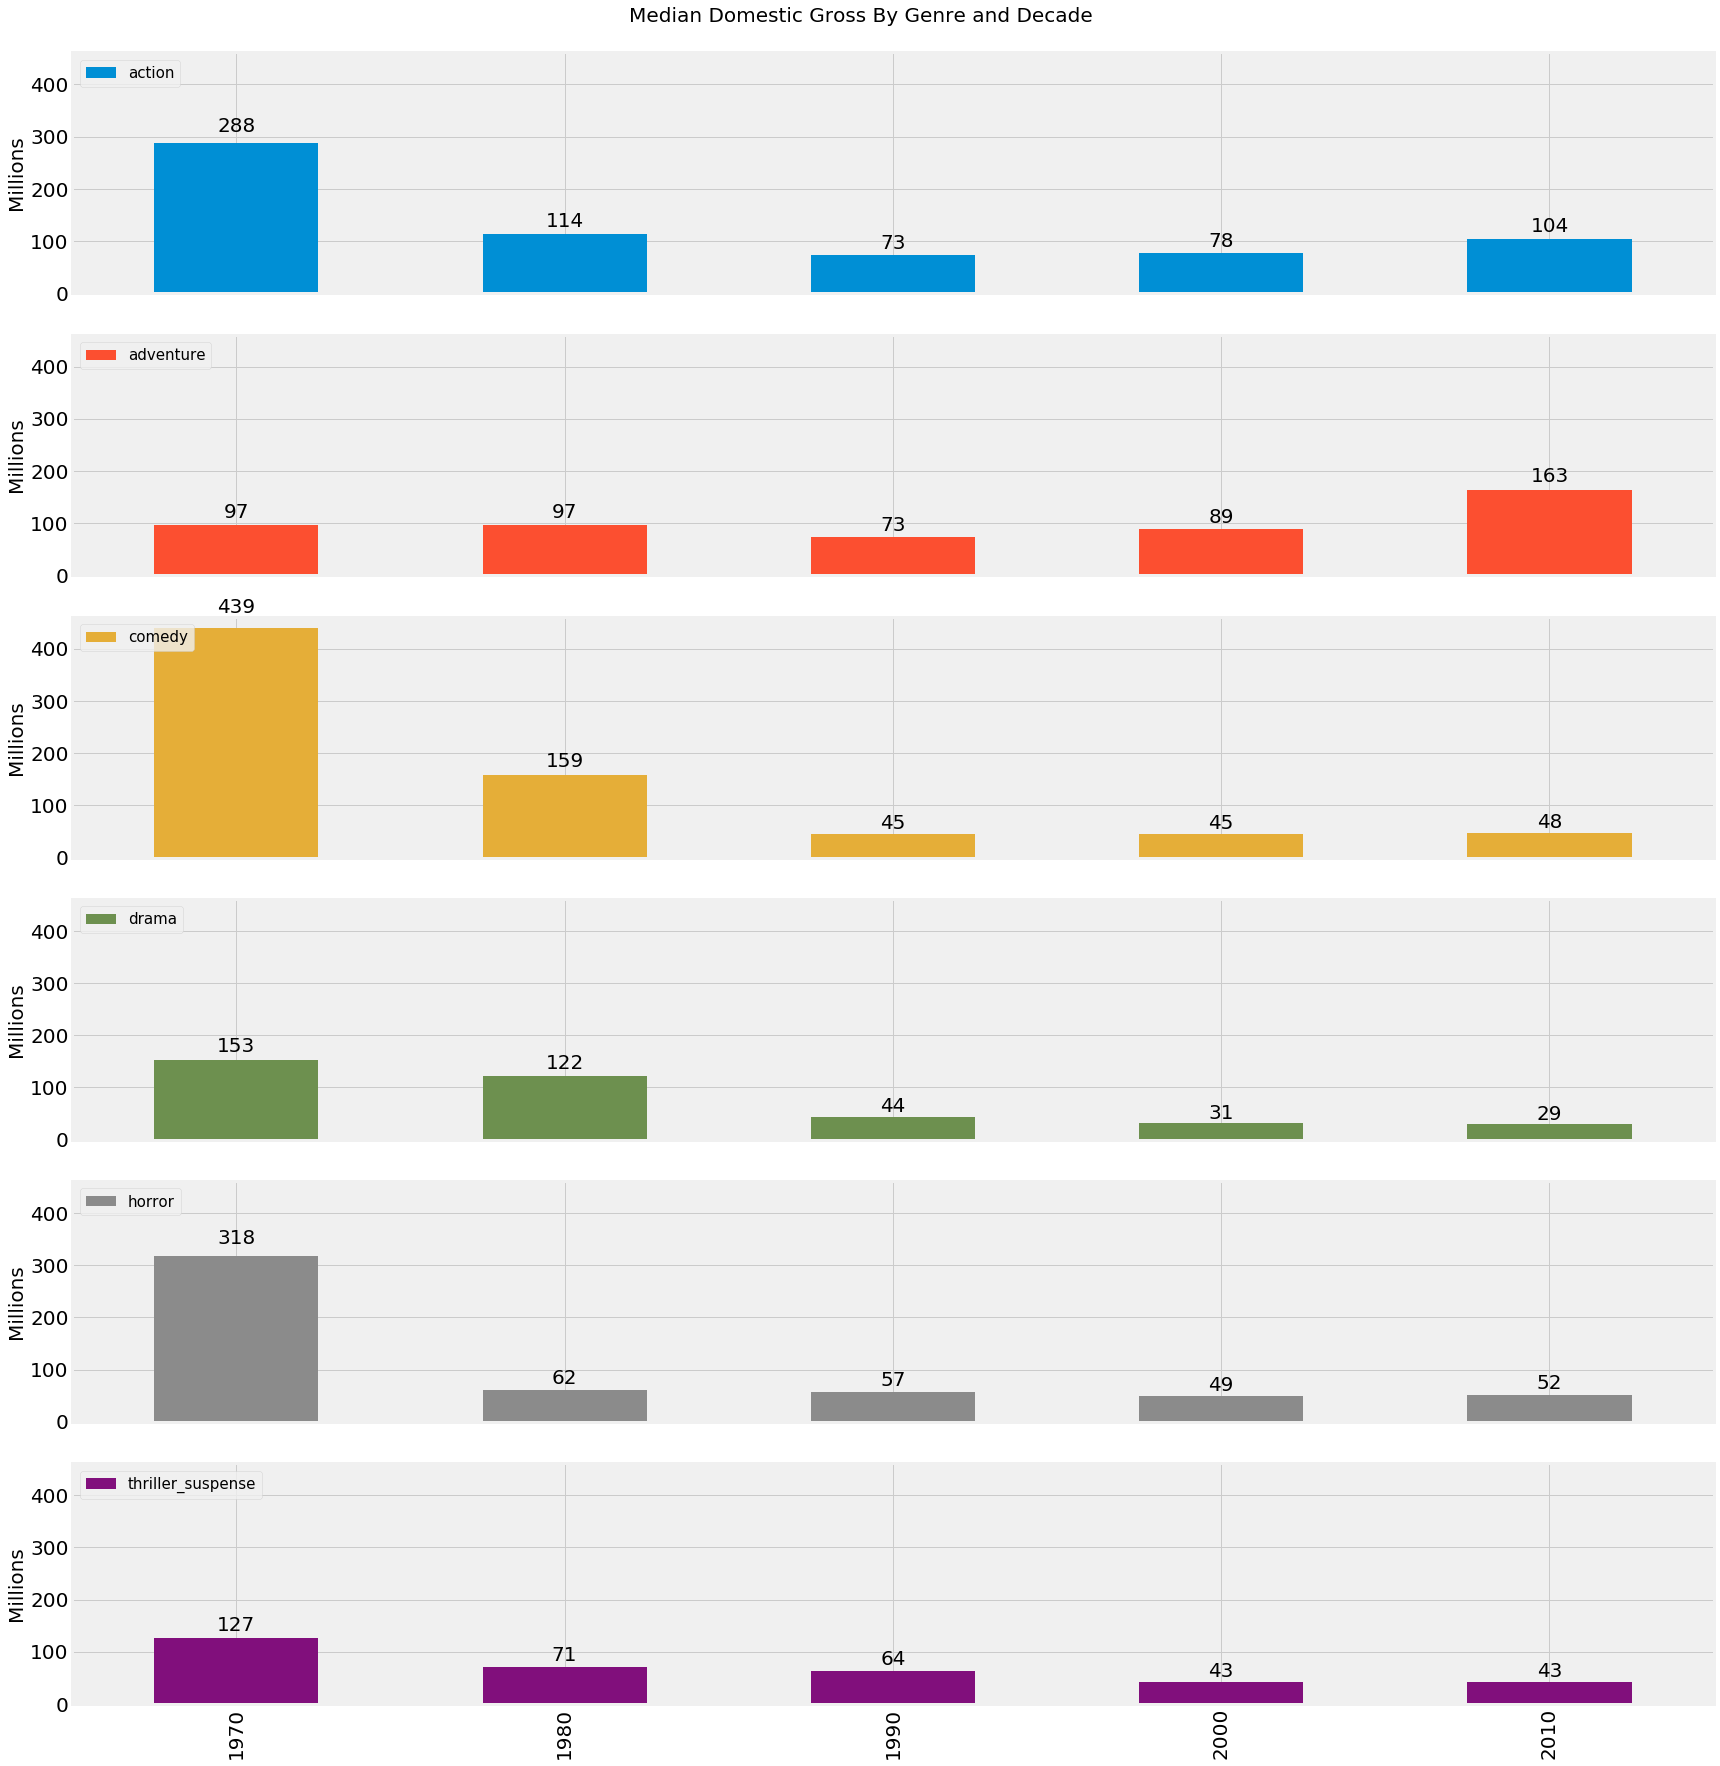

In [64]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Median Domestic Gross By Genre and Decade', figsize=(24,24), 
                                      colors=colors, groupby_column='release_decade', stat_column='domestic_adj', 
                                      aggregation_function='median', apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      xtick_values=range(1970, 2020, 10), y_label='Millions', axhline_needed=False, axhline_value='')    

### Quick Takeaways:

**From the 1990s to 2000s**
  - Adventure, Action, and Comedy had increases in median gross.
  - The other genres had decreases in median gross.
  - These changes coincided with a huge increase in the number of movies released per genre.
  
**2000s to 2010s**
  - Every genre except Drama has seen an increase in median gross from the 2000s to 2010s.
  - Except for Action, this has coincided with a decrease in the number of movies per genre.

**Horror**
  - Horror has the third highest median gross with &#0036;52 million.

## Budgets

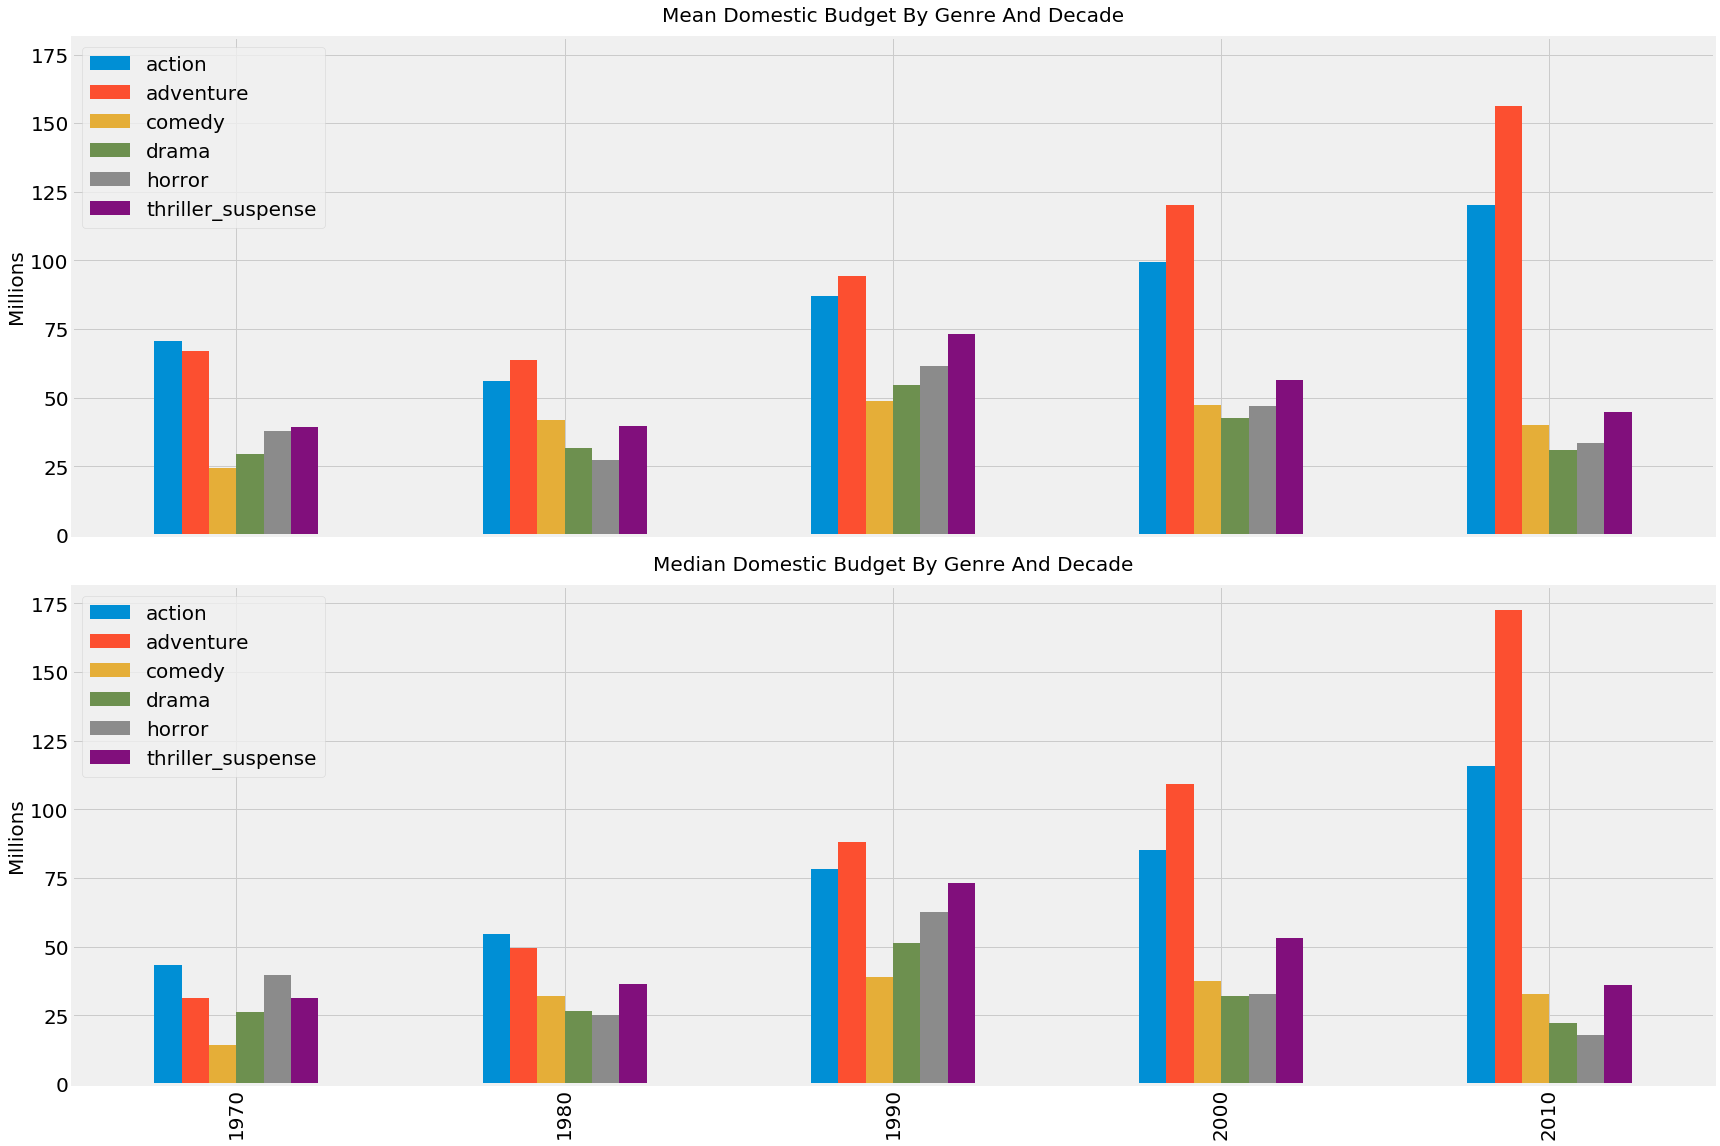

In [65]:
plot_mean_and_median_by_time_and_stat(data=data, genres=genres, groupby_column='release_decade', 
                                      stat_columns=budget_columns, stat_name_for_title='Domestic Budget', 
                                      apply_needed=True, apply_function=lambda x: x / 1000000, y_label='Millions', y_ticks_needed=False, y_ticks='')

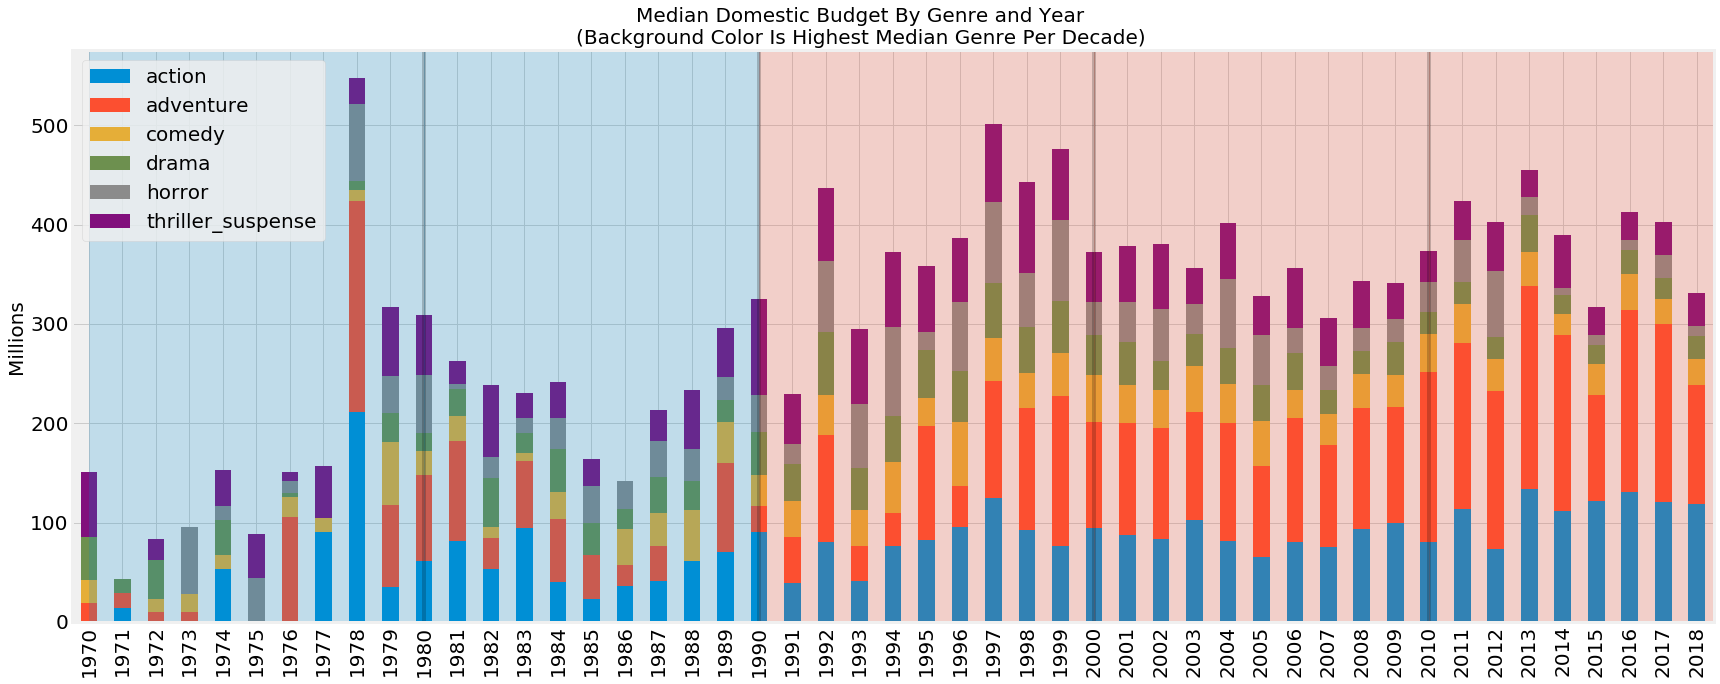

In [66]:
plot_stat_by_year_and_highlight_decade_winner(data=data, genres=genres, 
                                              title='Median Domestic Budget By Genre and Year\n(Background Color Is Highest Median Genre Per Decade)', 
                                              stat_columns=budget_columns, aggregation_function='median',
                                              apply_function=lambda x: x / 1000000, y_label='Millions')

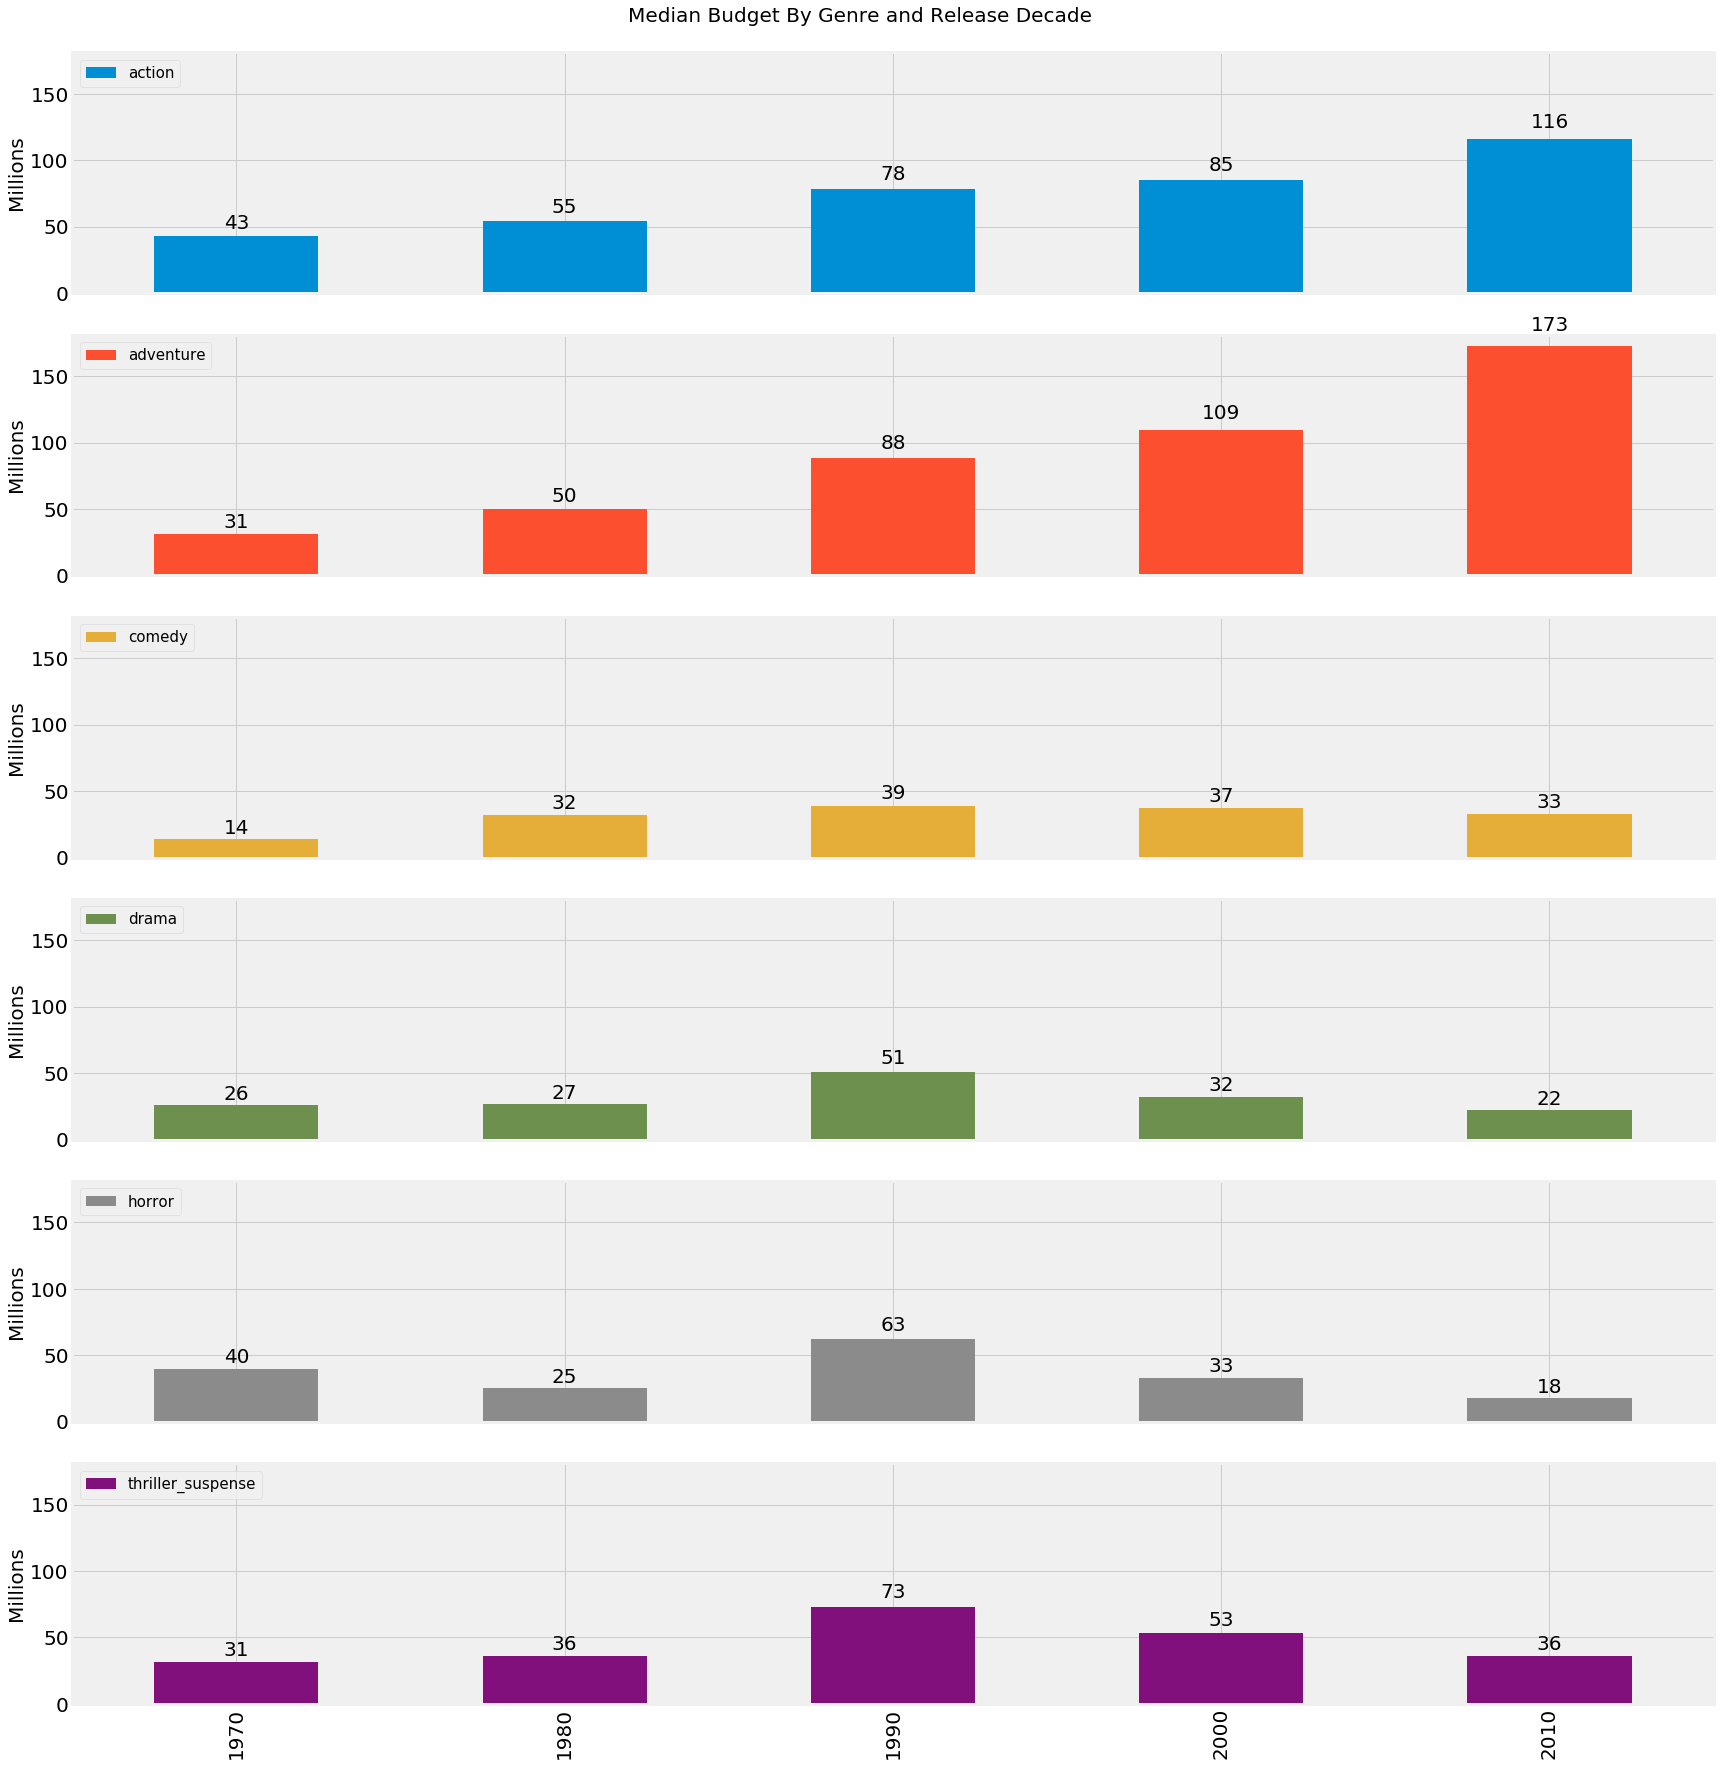

In [67]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Median Budget By Genre and Release Decade', figsize=(24,24), 
                                      colors=colors, groupby_column='release_decade', stat_column='budget_adj', 
                                      aggregation_function='median', apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      xtick_values=range(1970, 2020, 10), y_label='Millions', axhline_needed=False, axhline_value='')

## Quick Takeaways 

**Mean and median pretty much the same**
  - There's not much difference between the shapes of the mean and median in terms of budgets.
  
**Action and Adventure**
  - Action had the highest median budget in the 1970s and 1980s.
  - Adventure has had the highest median budget from the 1990s onwards.
  - Both Action and Adventure's median budget has increased every decade.

**The Other Four**
  - The remaining genres share the same basic budget trajectory: median budget increasing until the 1990s, then decreasing into the current decade.

## Profits

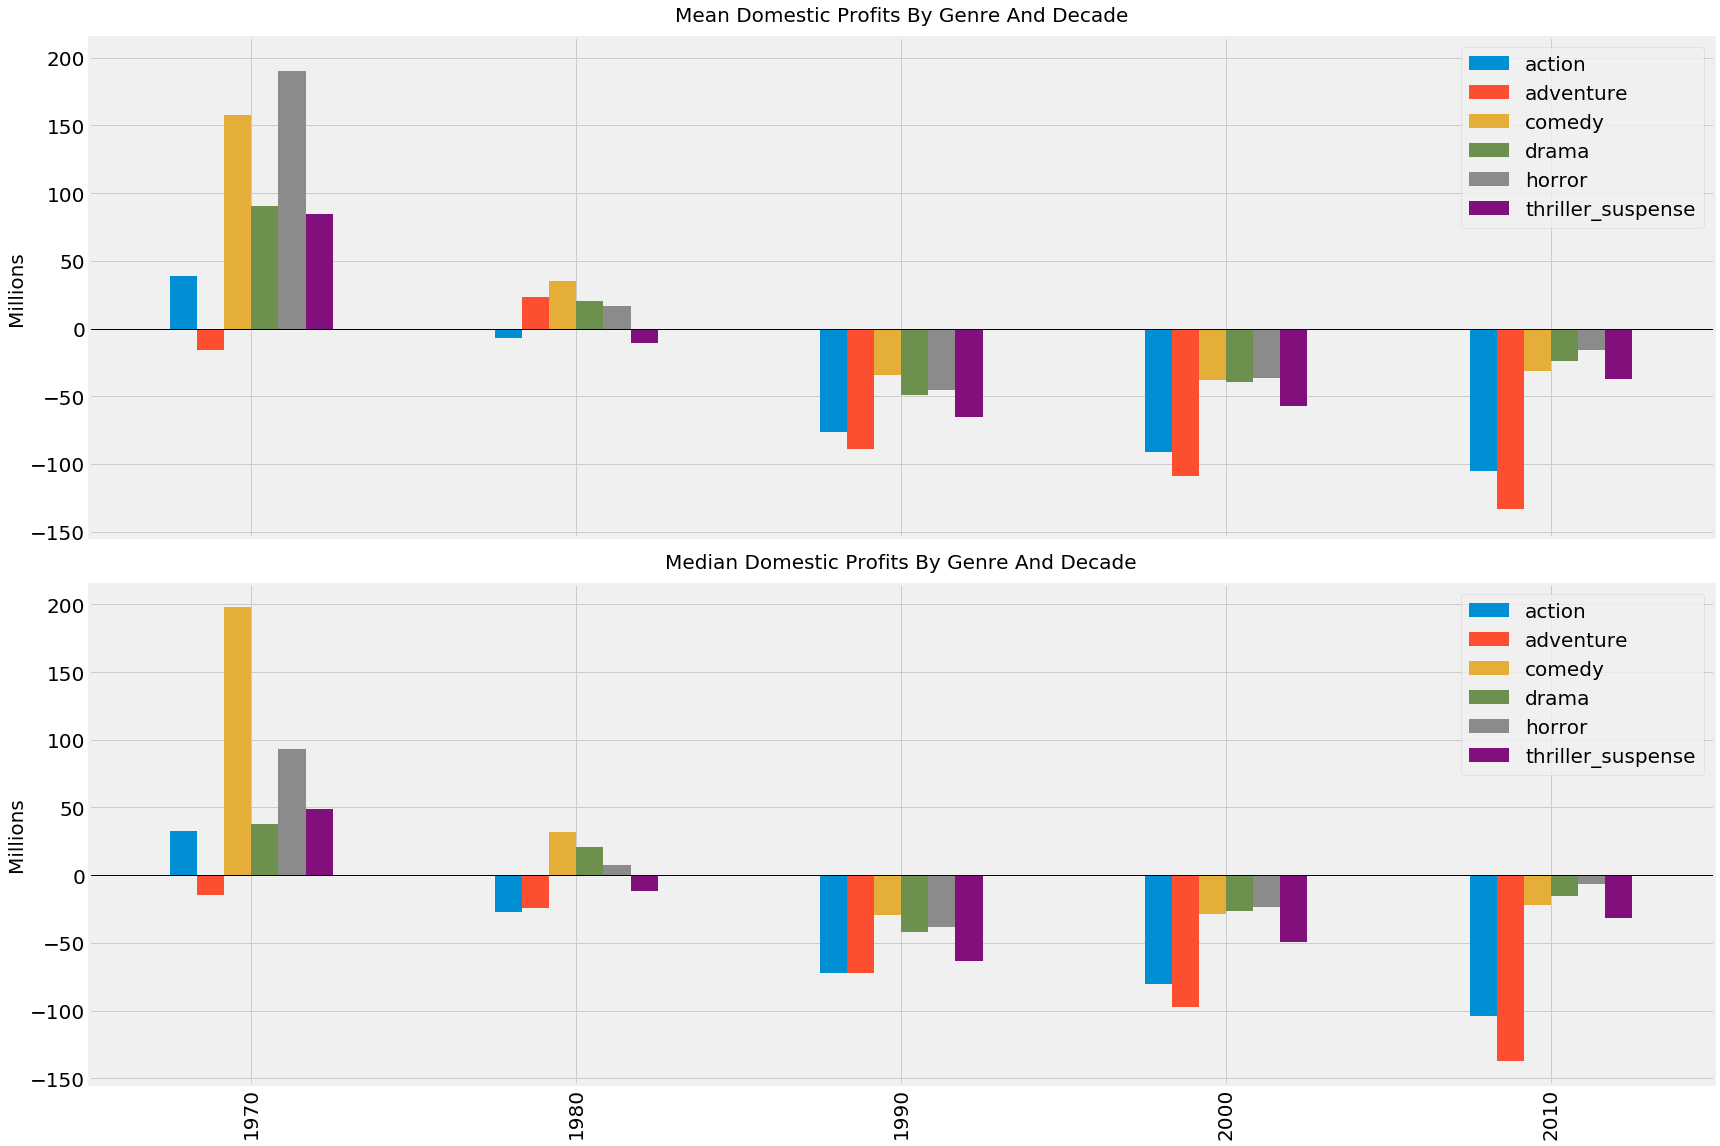

In [68]:
plot_mean_and_median_by_time_and_stat(data=data, genres=genres, groupby_column='release_decade', 
                                      stat_columns=profit_columns, stat_name_for_title='Domestic Profits', 
                                      apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      y_label='Millions', y_ticks_needed=False, y_ticks='', axhline_needed=True, axhline_value=0)

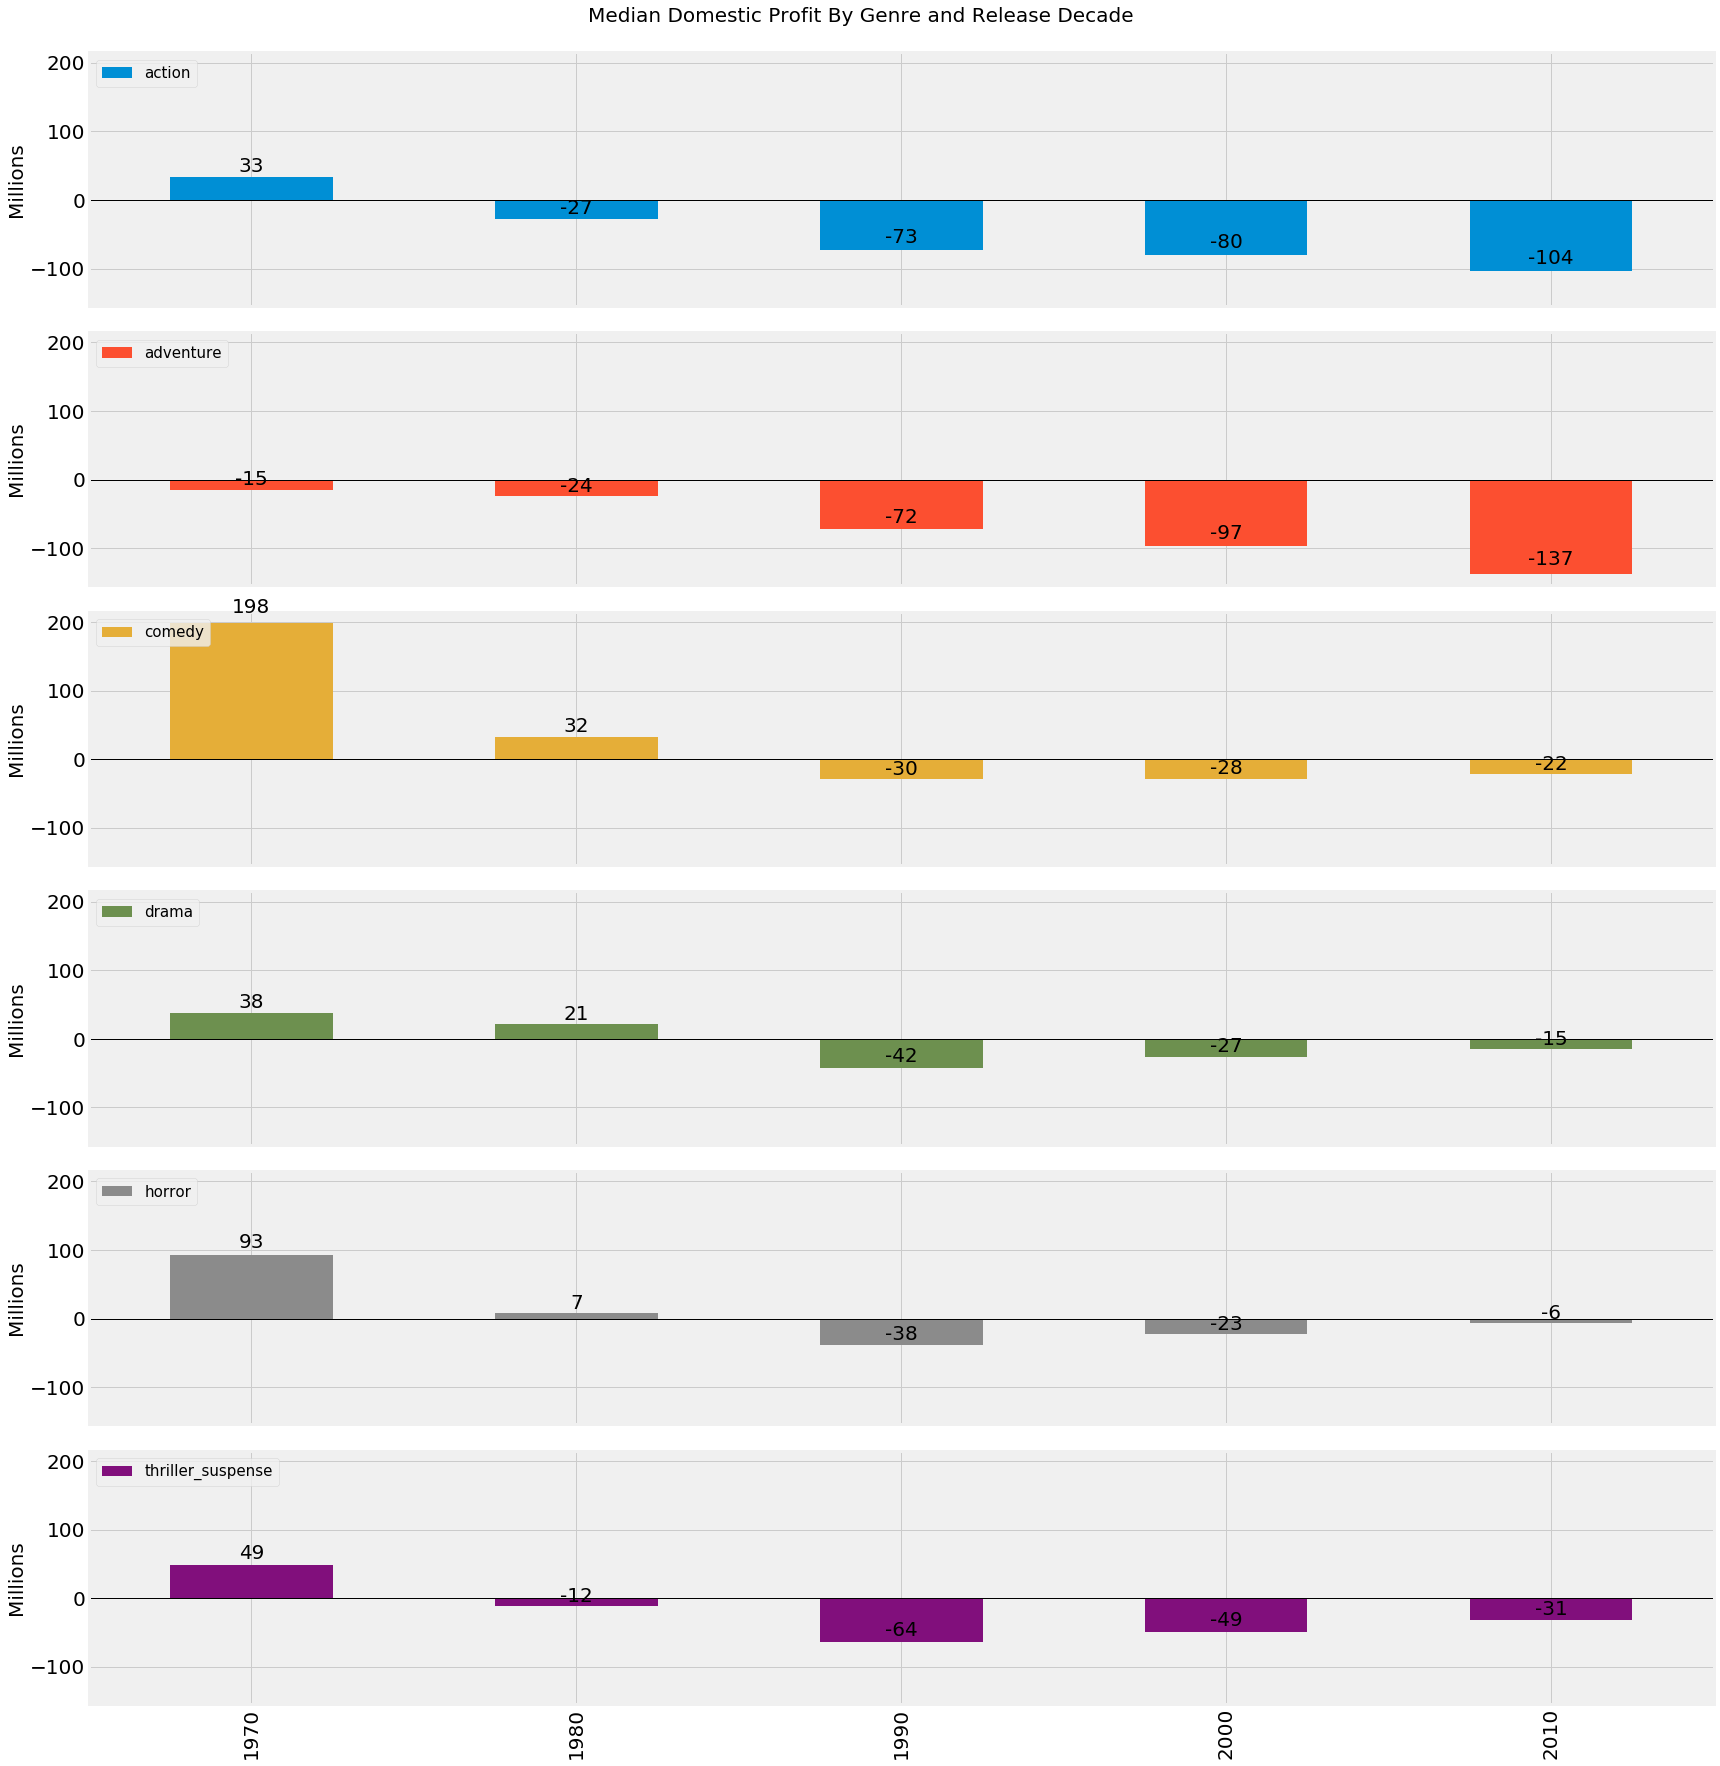

In [69]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Median Domestic Profit By Genre and Release Decade', figsize=(24,24), 
                                      colors=colors, groupby_column='release_decade', stat_column='profit', 
                                      aggregation_function='median', apply_needed=True, apply_function=lambda x: x / 1000000, 
                                      xtick_values=range(1970, 2020, 10), y_label='Millions', axhline_needed=True, axhline_value=0)

## Quick Takeaways

**The average movie is not a domestic winner**
  - From the 1990s onwards, no genre has a postive domestic median profit. 
  - Movies must be relying on other revenue streams to generate profitability: international box office, DVDs, rentals, TV airings, etc.

## Breakeven Percentage

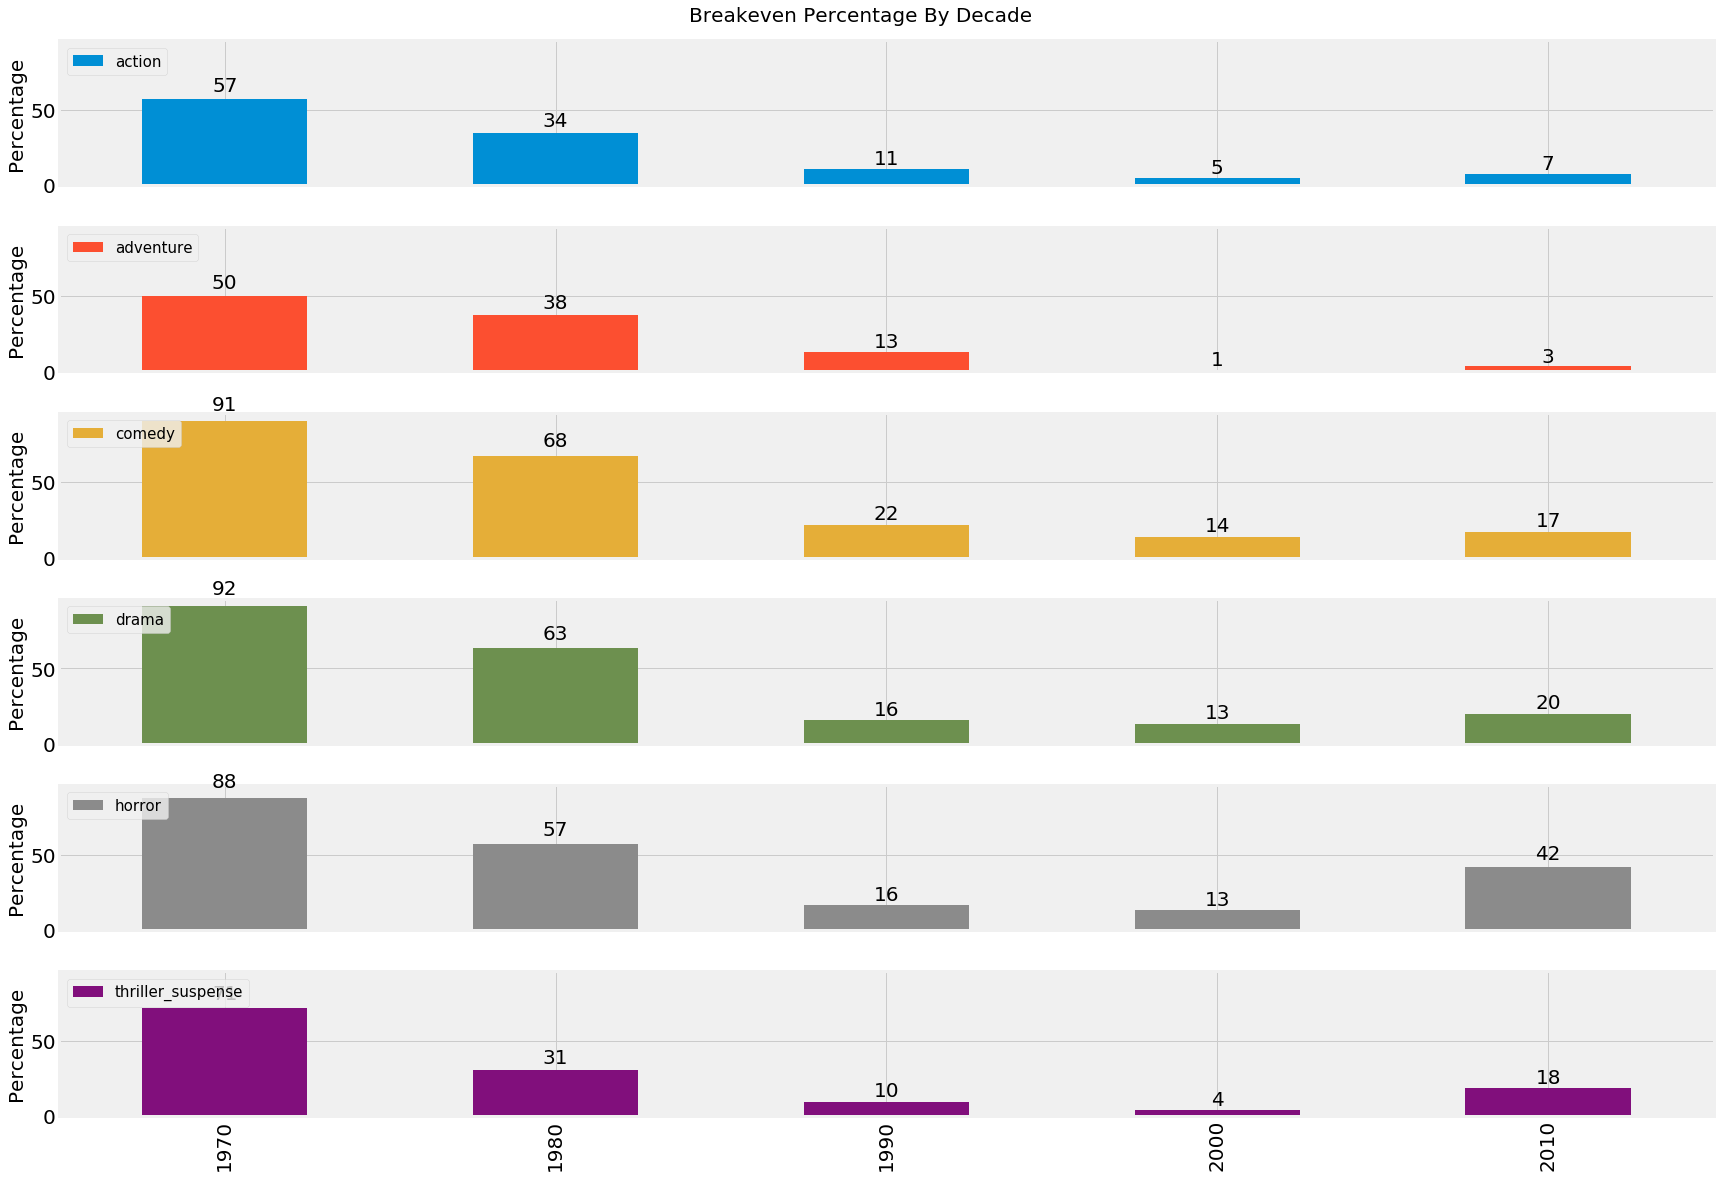

In [70]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Breakeven Percentage By Decade', figsize=(24,16), 
                                      colors=colors, groupby_column='release_decade', stat_column='domestic_breakeven', 
                                      aggregation_function='mean', apply_needed=True, apply_function=lambda x: x * 100, 
                                      xtick_values=range(1970, 2020, 10), y_label='Percentage', axhline_needed=False, axhline_value='')

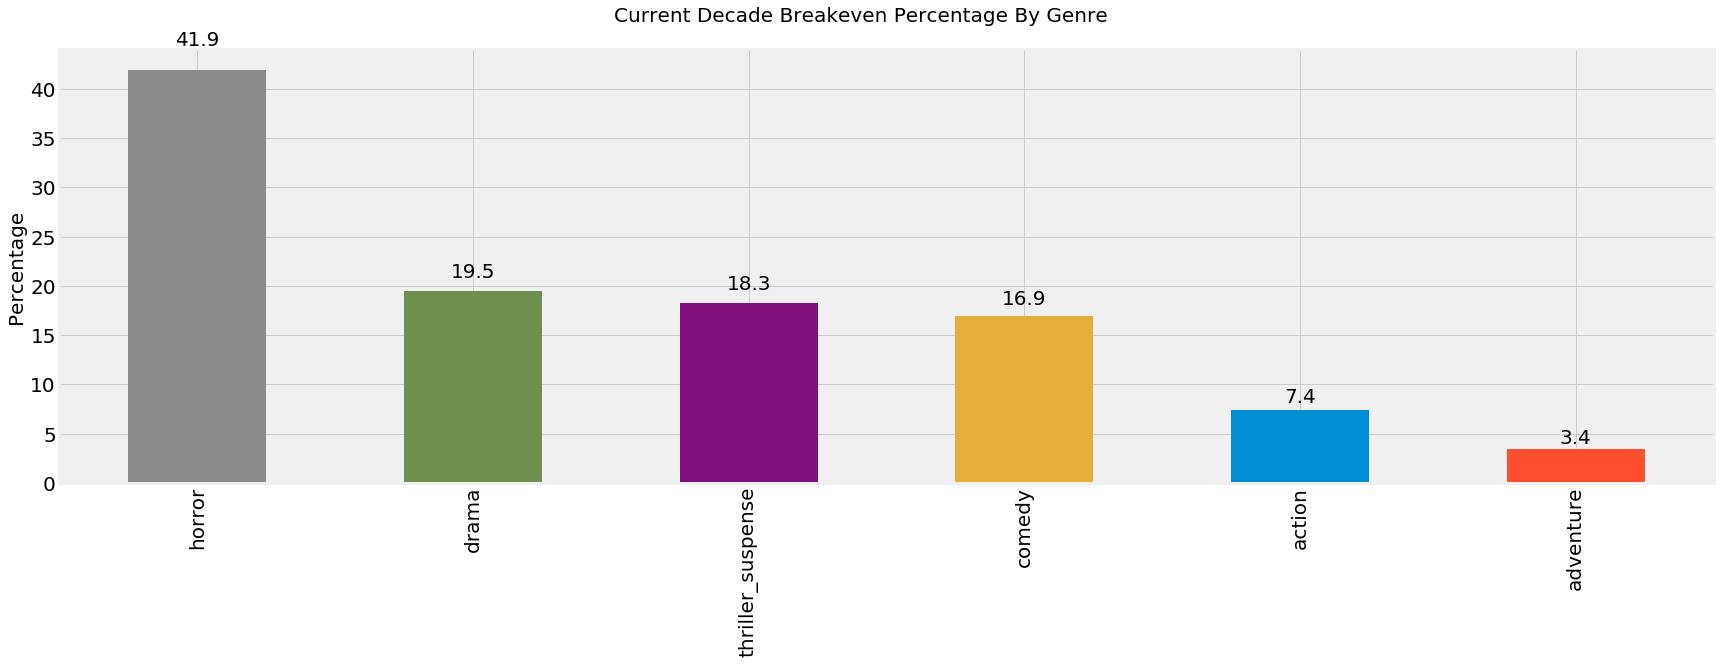

In [71]:
plot_summary_dataframe(summary=summary, 
                       sort_column='current_decade_breakeven_percentage',
                       plot_columns='current_decade_breakeven_percentage', 
                       title='Current Decade Breakeven Percentage By Genre', 
                       colors_needed=1, 
                       legend_needed=False, 
                       legend_text=[], 
                       y_label='Percentage', 
                       num_decimals=1)

## Quick Takeaways

**1970s to 2000s**
  - A movie's chance of breaking even in the domestic box office plummeted from the 1970s to the 2000s.
  - Drama: 92% to 13%
  - Comedy: 91% to 14%
  - Horror: 88% to 13%
  - Thriller/Suspense: 71% to 4%
  - Action: 57% to 5%
  - Adventure: 50% to 1%
  
**2000s to 2010s**
  - All genres have seen an increase in their chance of breaking even from the 2000s to the 2010s.
  - The largest jump has been Horror from 13% to 42%.
  - Action and Adventure have the smallest increases (about 2% each).

**Safest current genres**
  - Horror is by far the safest domestic release genre with a 42% chance of breaking even.
  - The next safest is Drama at 19.5%, then Thriller/Suspense at 18.3%.
  - Action and Adventure are by far the riskiest domestic release genres.
  
**Movies are risky today**
  - From a breakeven standpoint, domestic movies are safer today than they were in the 2000s.
  - However, the best chance a movie has to breakeven in aggregate is still only 42% for Horror.
  - Movies are still a big risk.

## Breaking Down By Subgenres

The movie business is so variable that looking at trends within subgenres probably doesn't yield much actionable insight.

But we shall look at mean and median profitability of subgenres by decade just in case.

In [72]:
# Function to plot mean and median profitability by subgenre by decade
def subgenre_profitability_by_decade(genre, colors):
    subgenres = data[data[genre.lower()]].groupby('genres_mojo').count().index
    num_subgenres = len(subgenres)
    
    figure, axes = plt.subplots(nrows=num_subgenres, ncols=1, figsize=(24, 50), sharex=True)
    figure.suptitle('Mean and Median Profit By {} Subgenre And Decade'.format(genre.title()), fontsize=20, y=1.02)

    for subgenre, axis in zip(subgenres, axes.flat):
            grp = (data[data['genres_mojo'] == subgenre].groupby('release_decade').agg(['mean', 'median']) / 1000000)['profit']

            # If the series is missing a decade, add it as an index and set the value to zero
            for decade in range(1970, 2020, 10):
                if decade not in grp.index:
                    grp.loc[decade] = 0

            # Sort the series by its index to have the decades in chronological order                
            grp.sort_index(ascending=True, inplace=True)
 
            grp.plot(kind='bar', xticks=range(1970, 2020, 10), color=colors, linewidth=3, ax=axis)

            axis.set_ylabel('Millions', fontsize=20)
            axis.set_title(subgenre, fontsize=20)
            axis.legend(['Mean', 'Median'], loc='lower left', fontsize=15)
            axis.set_xlabel('')
            axis.tick_params(labelsize=20)
            axis.axhline(0, color='k', linewidth=1)

            autolabel(axis)

    plt.tight_layout()

### Action Subgenres By Decade

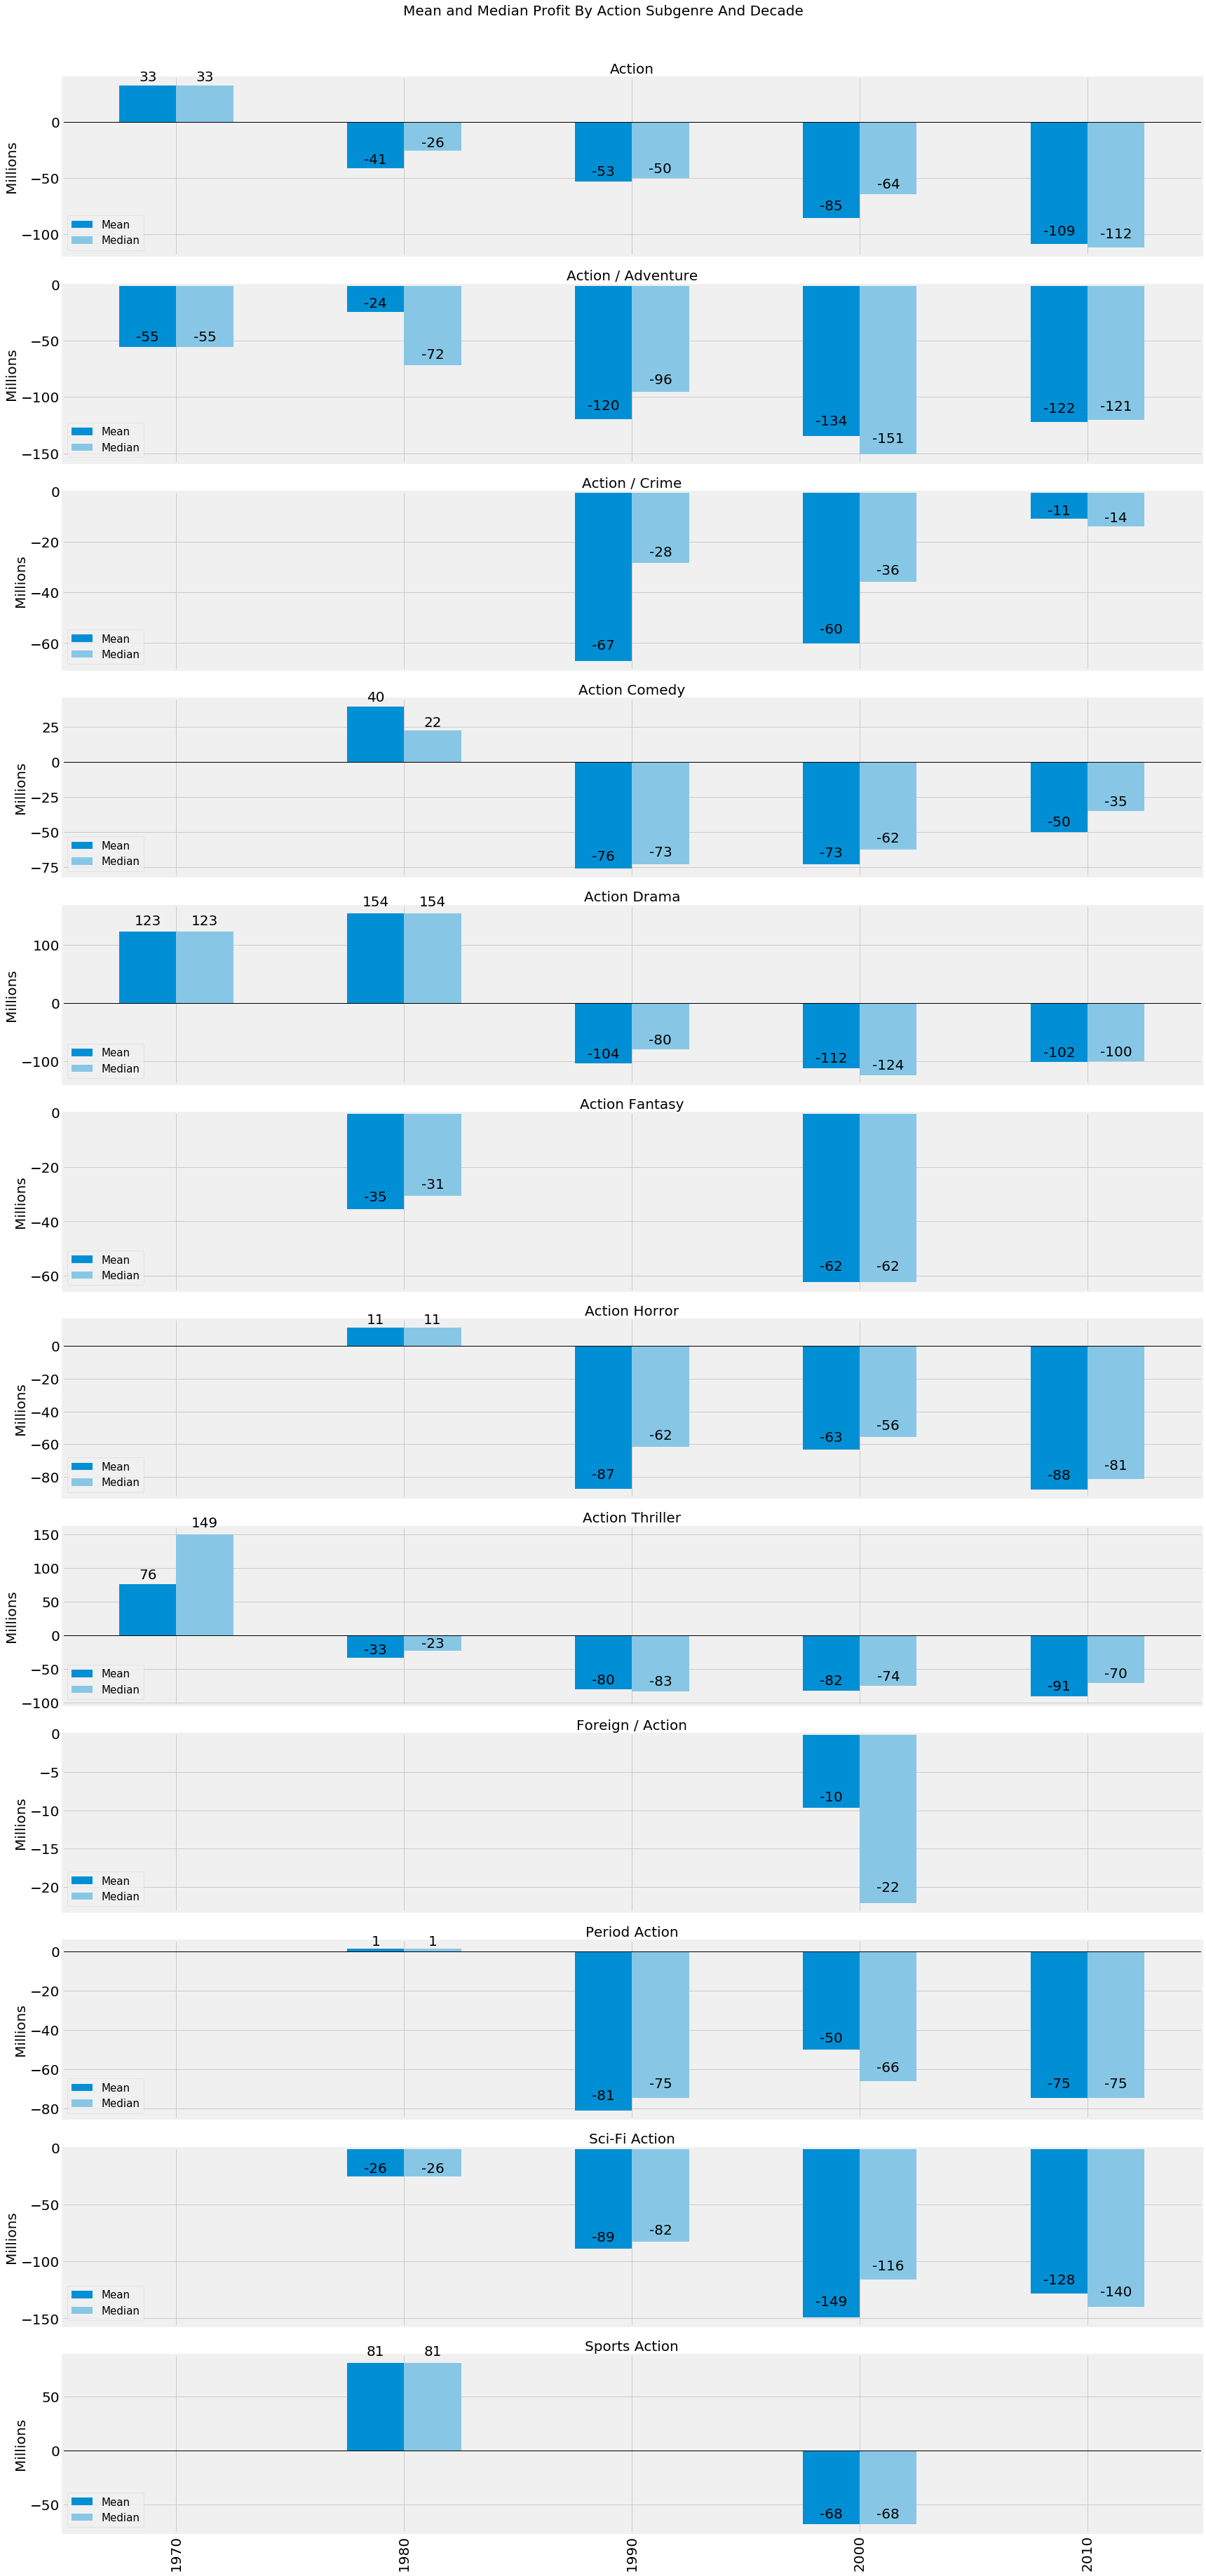

In [73]:
subgenre_profitability_by_decade('action', [genres_dict['action']['color1'], genres_dict['action']['color2']])

### Quick Takeaways

- There's no clear best subgenre. 
- A few subgenres were median profitable in the 1970s or 1980s.
- There hasn't been an Action subgenre that was median profitable in the 1990s, 2000s, or 2010s.

### Adventure Subgenres By Decade

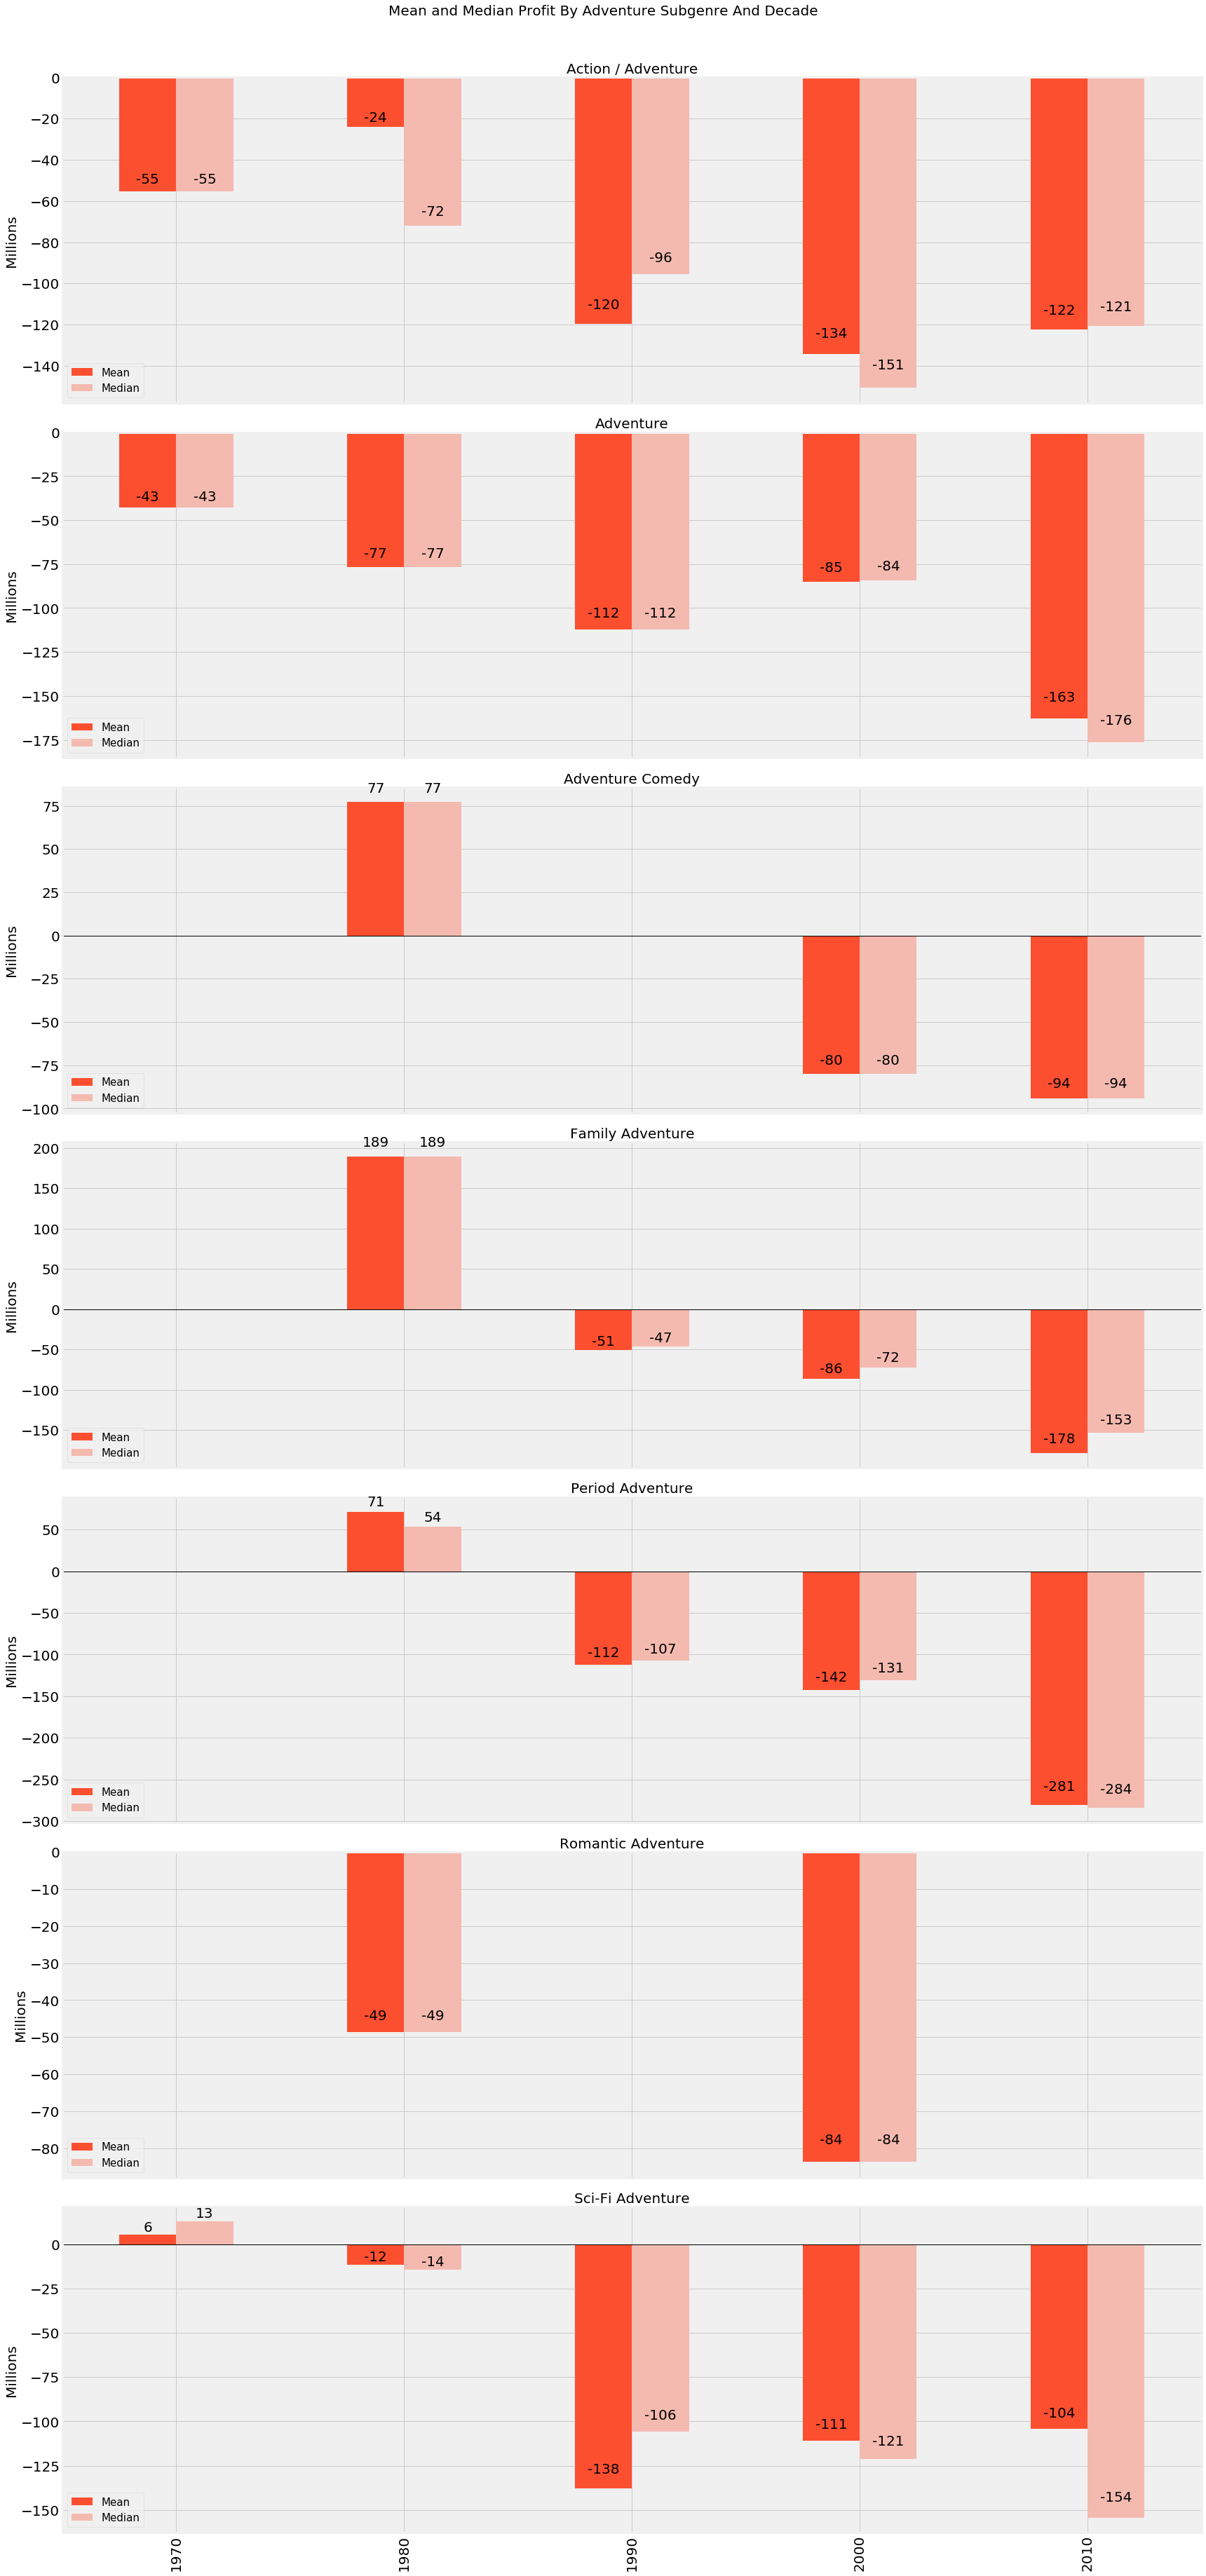

In [74]:
subgenre_profitability_by_decade('adventure', [genres_dict['adventure']['color1'], genres_dict['adventure']['color2']])

### Quick Takeaways

- Similar to Action, there hasn't been an Adventure subgenre that was median profitable in the 1990s, 2000s, or 2010s.

### Comedy Subgenres By Decade

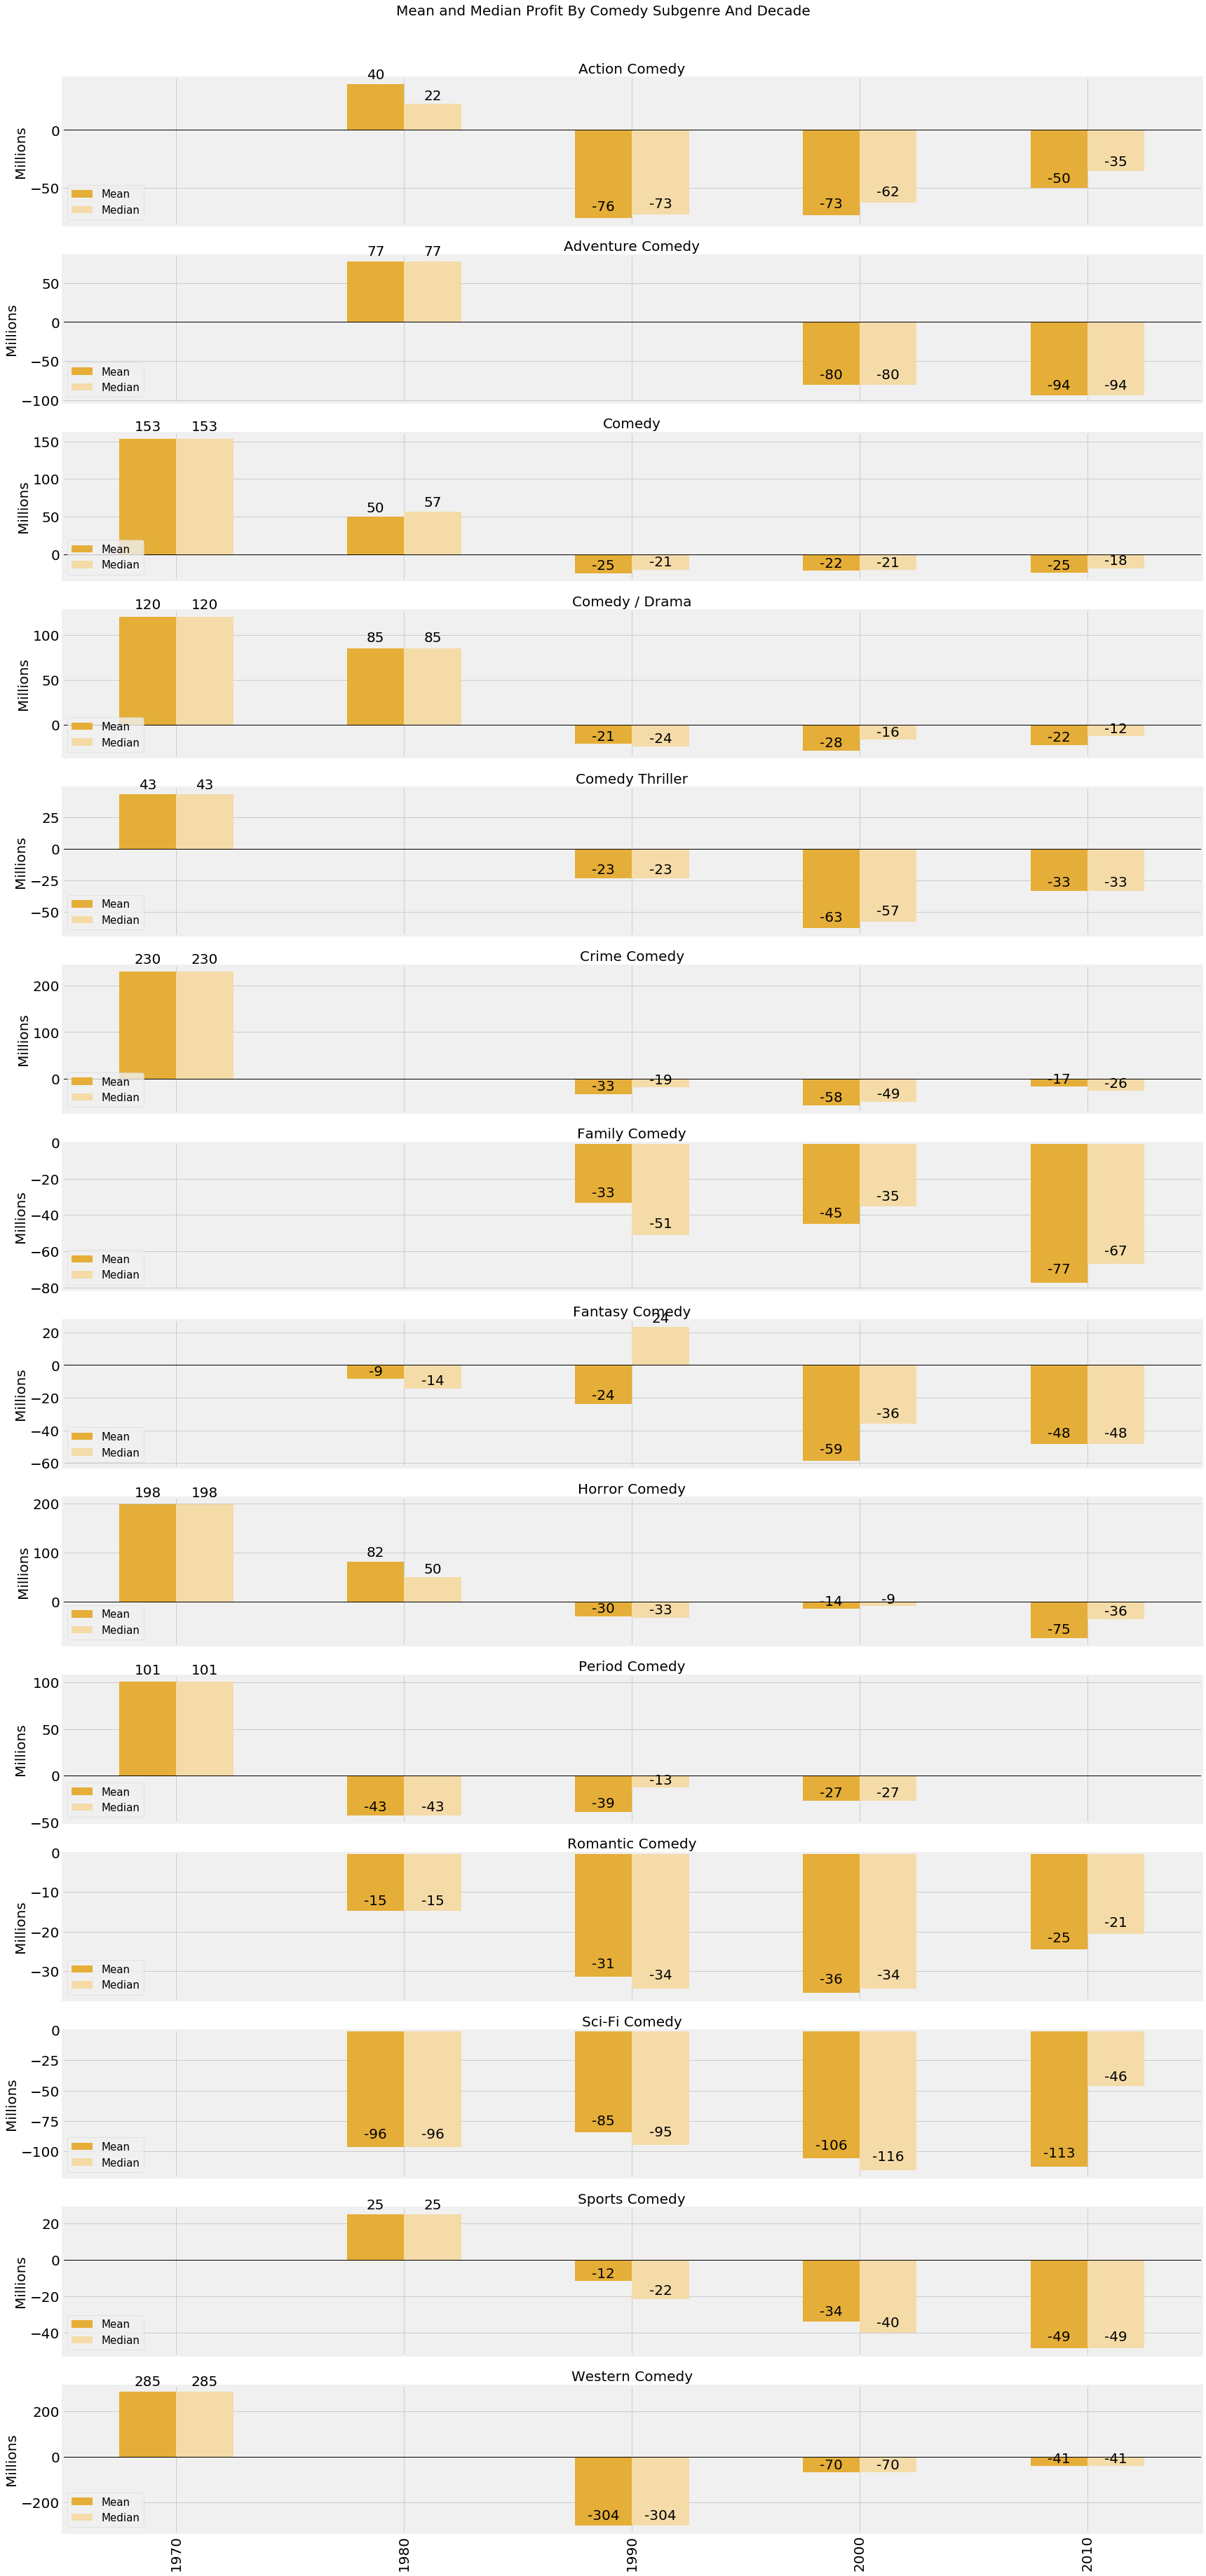

In [75]:
subgenre_profitability_by_decade('comedy', [genres_dict['comedy']['color1'], genres_dict['comedy']['color2']])

### Quick Takeaways

- Fantasy Comedies were median profitable in the 1990s. (This was due to their being three Fantasy Comedies, only one of which lost money. However, the loss in that was so large as to render the subgenre a net loser in terms of mean profitability.)
  - Mystery Men: <span style='color:red'>-\\$131 million</span>
  - Groundhog Day: \\$23.5 million
  - Liar Liar: \\$36 million
  
- No other subgenre has been median profitable in the 1990s, 2000s, or 2010s.

### Drama Subgenres By Decade

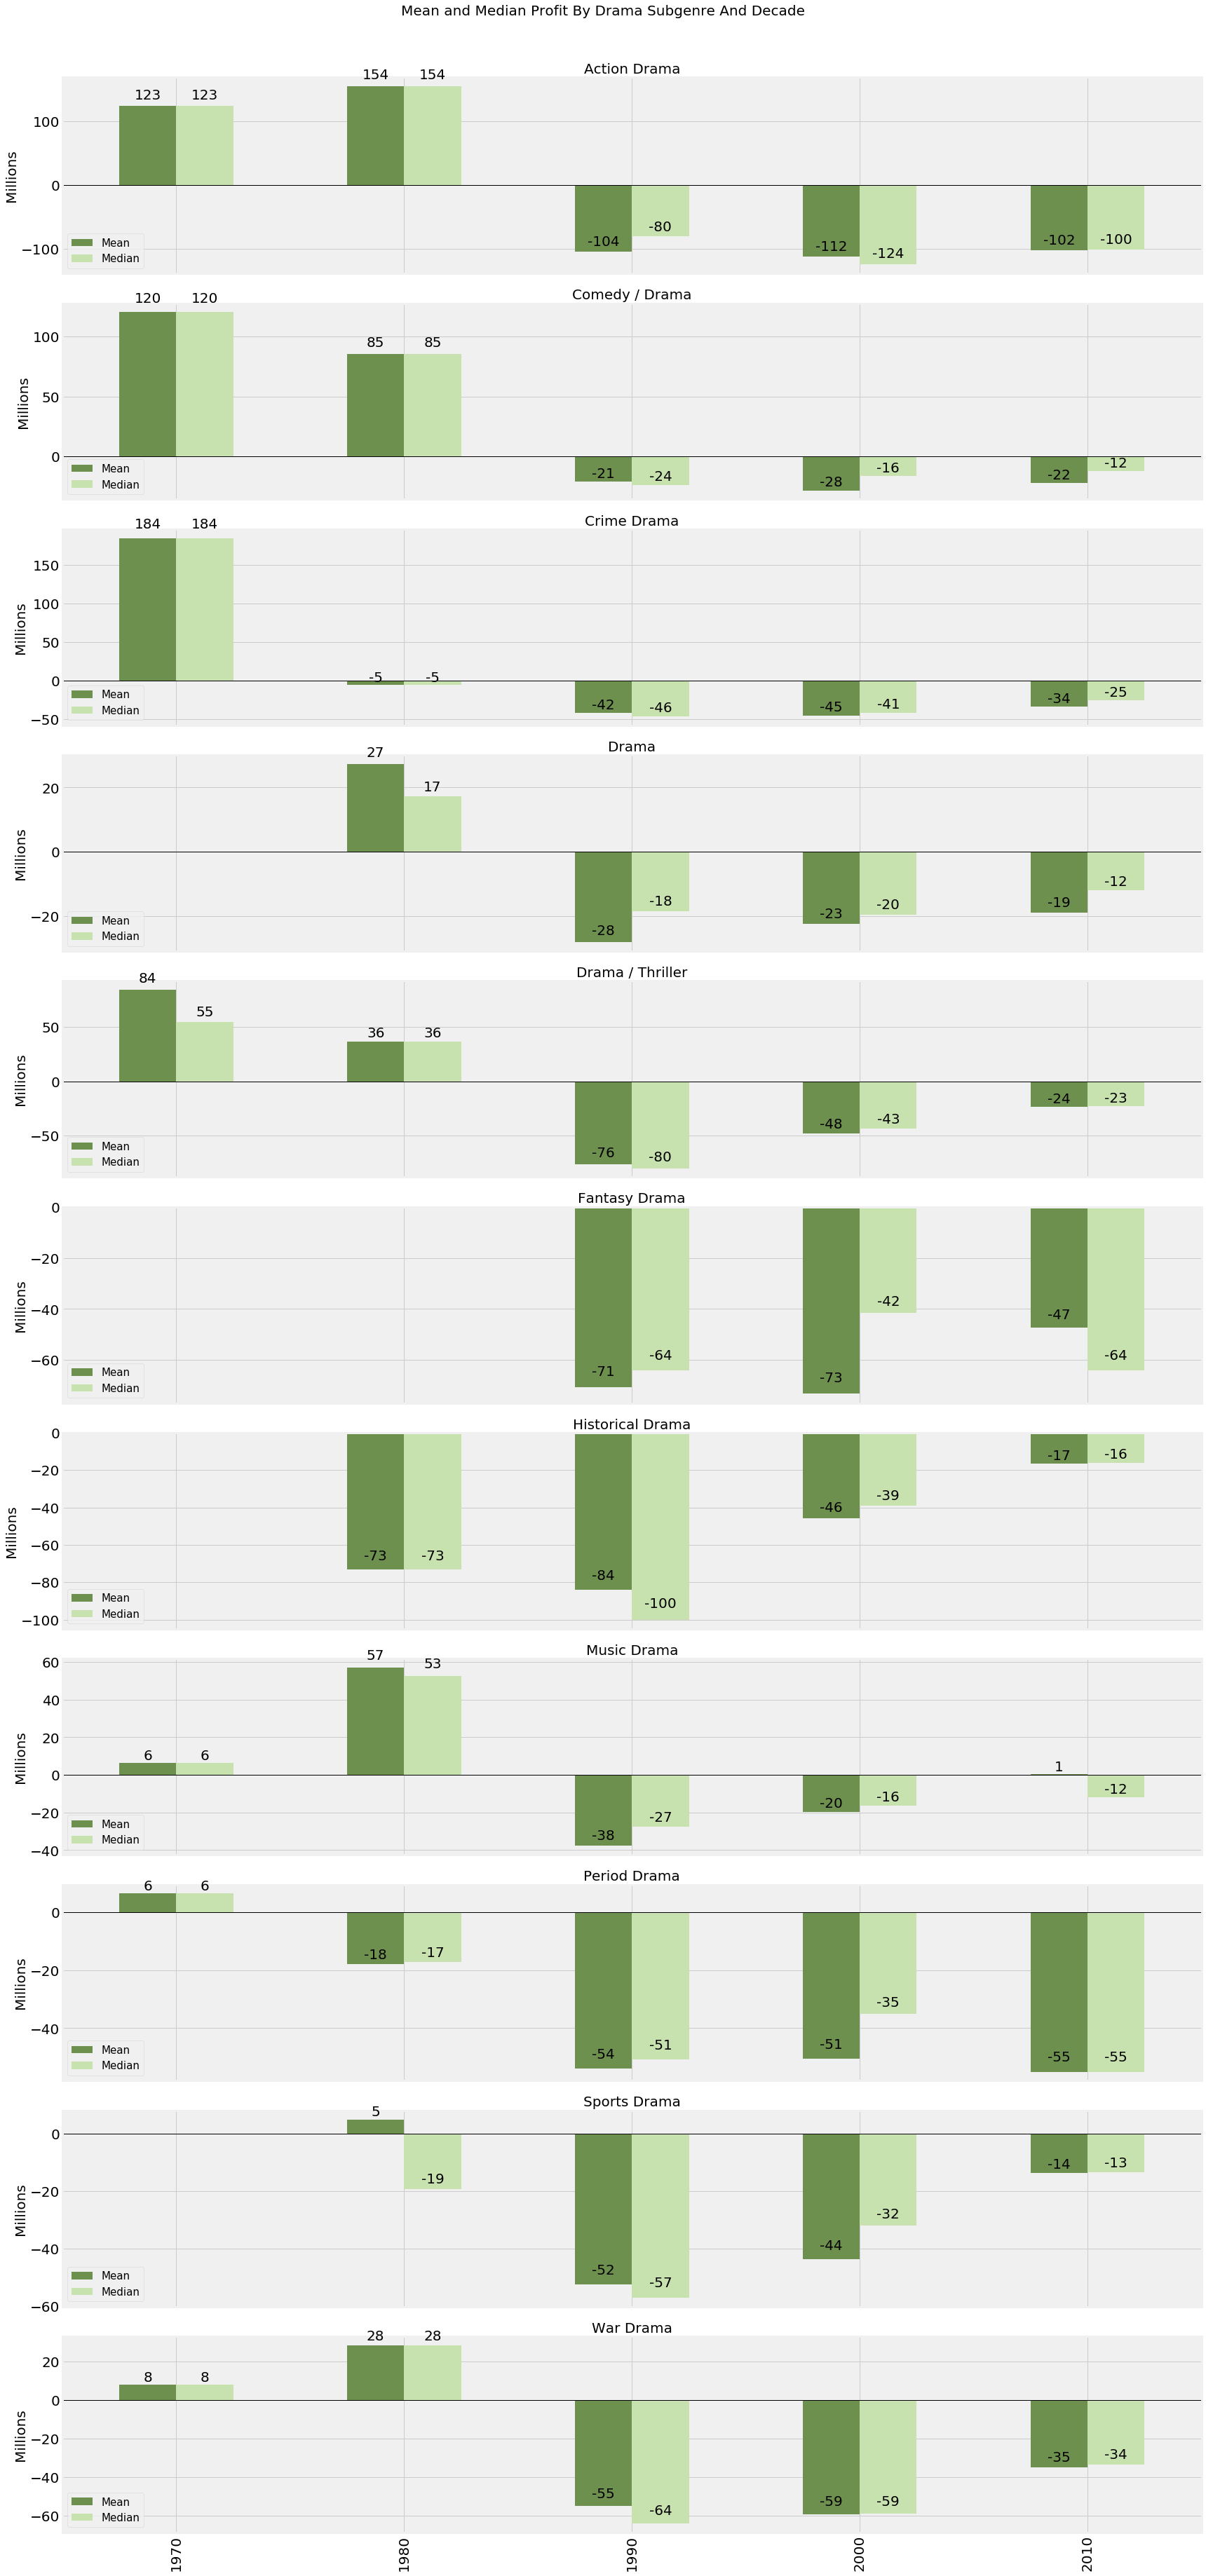

In [76]:
subgenre_profitability_by_decade('drama', [genres_dict['drama']['color1'], genres_dict['drama']['color2']])

### Quick Takeaways

- No Drama subgenre has been median profitable in the 1990s, 2000s, or 2010s.

### Horror Subgenres By Decade

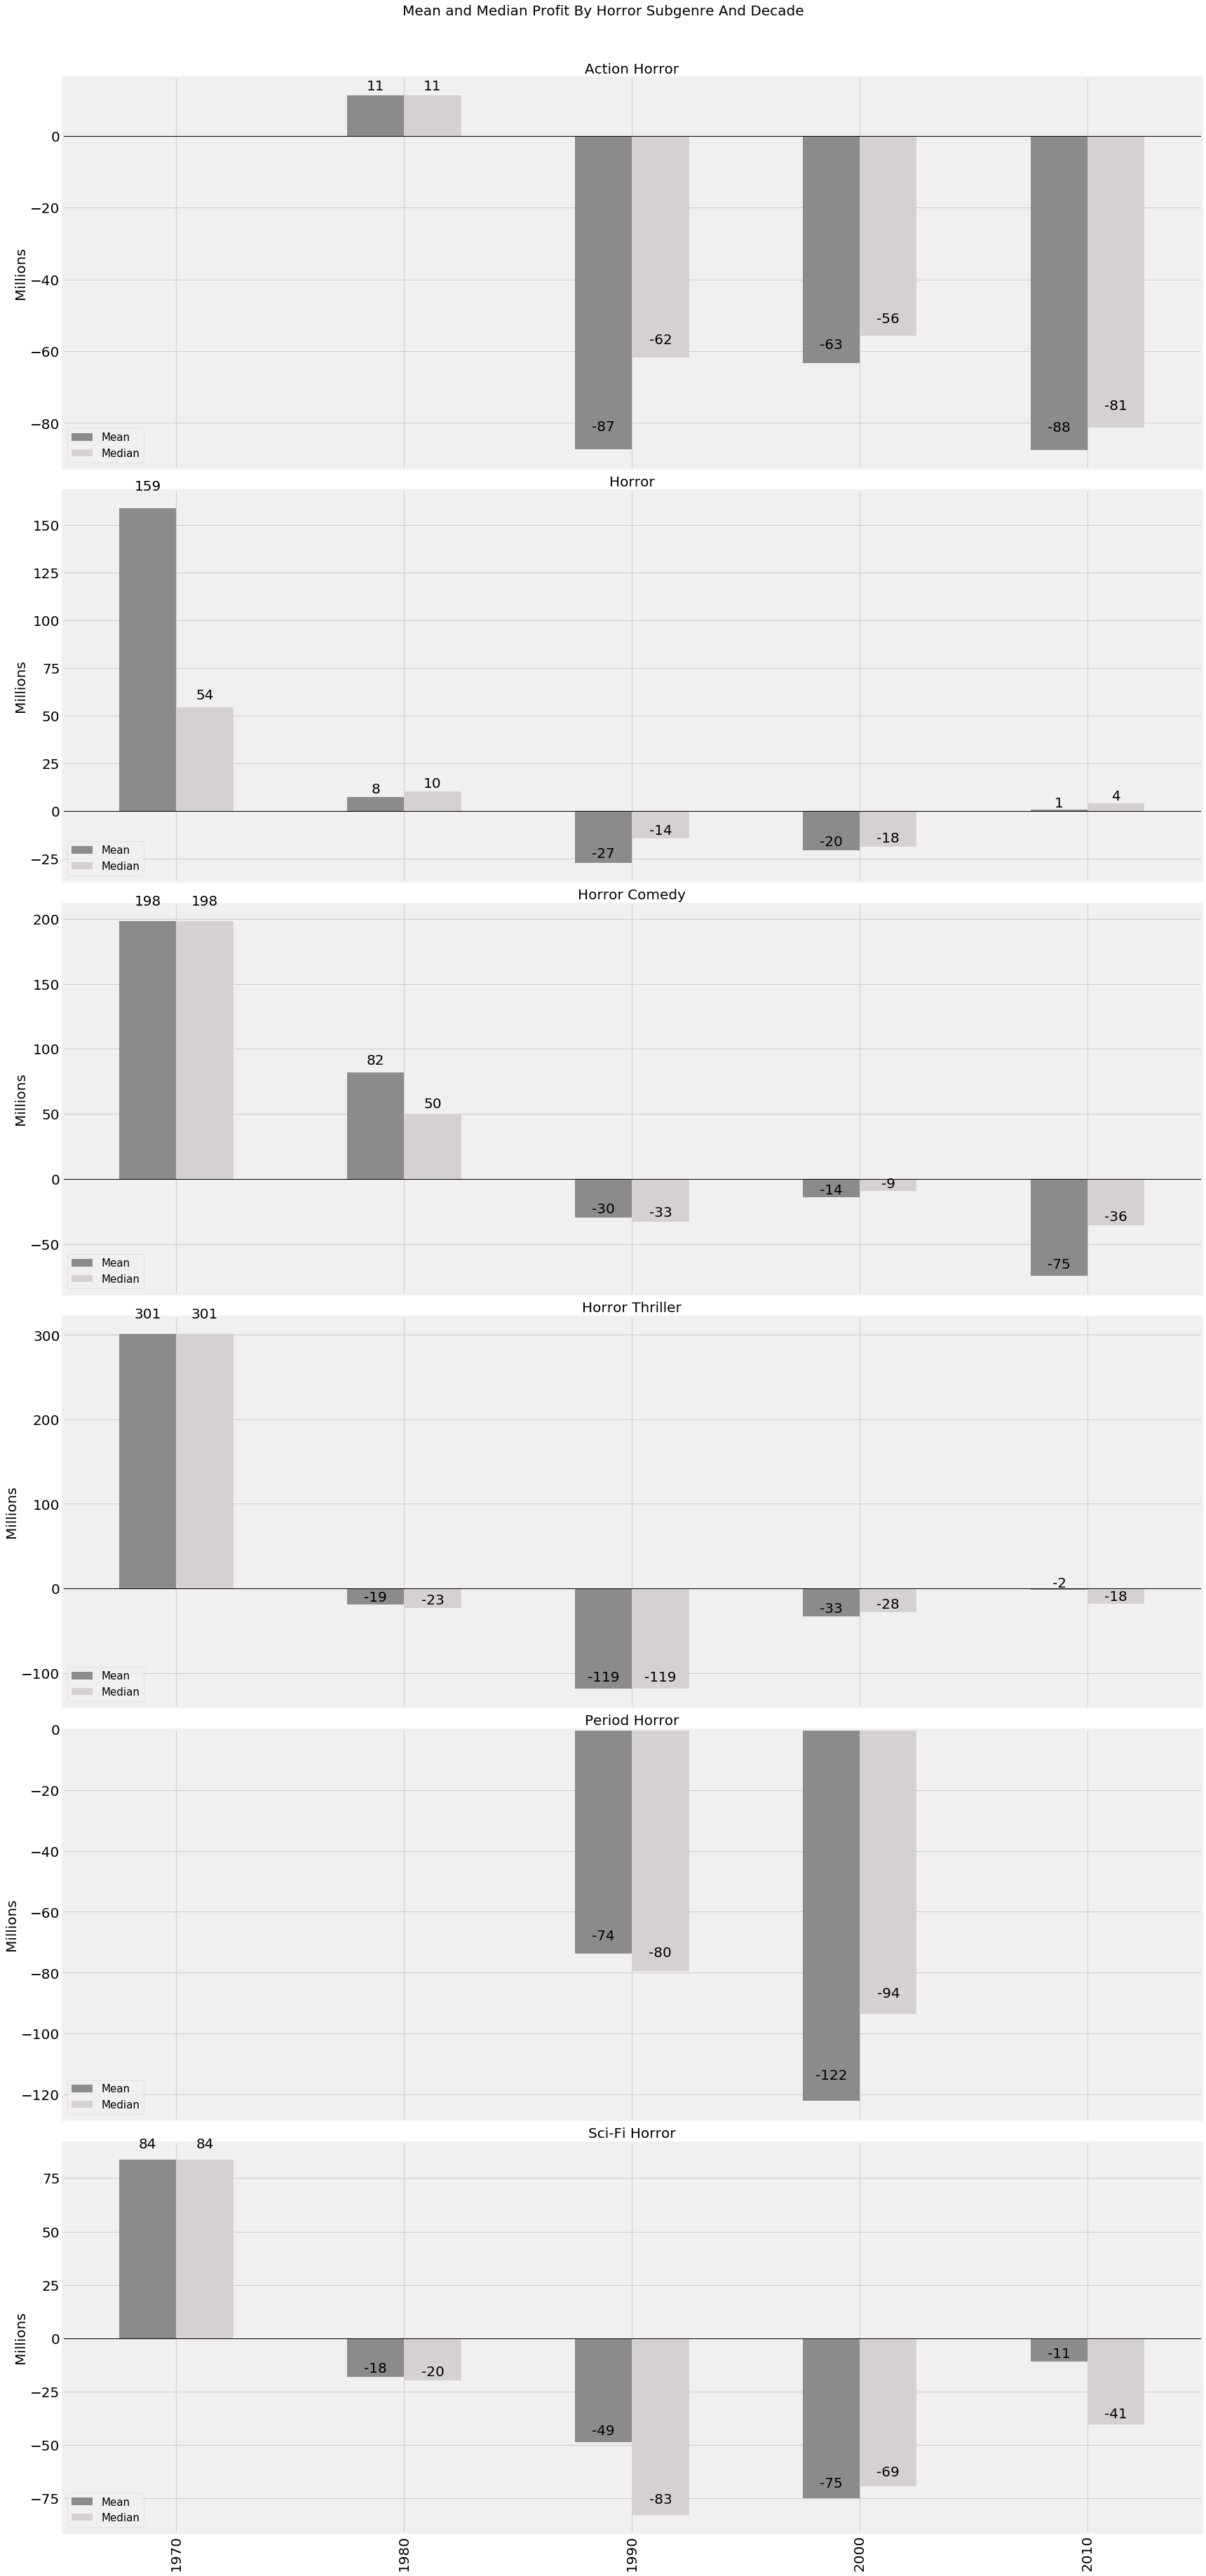

In [77]:
subgenre_profitability_by_decade('horror', [genres_dict['horror']['color1'], genres_dict['horror']['color2']])

### Quick Takeaways

- Horror movies whose only label is Horror (meaning it doesn't have a subgenre) are median profitable in the 2010s (\\$4 million).
- All other Horror subgenres are median losers in the 1990s, 2000s, and 2010s.

### Thriller/Suspense Subgenres By Decade

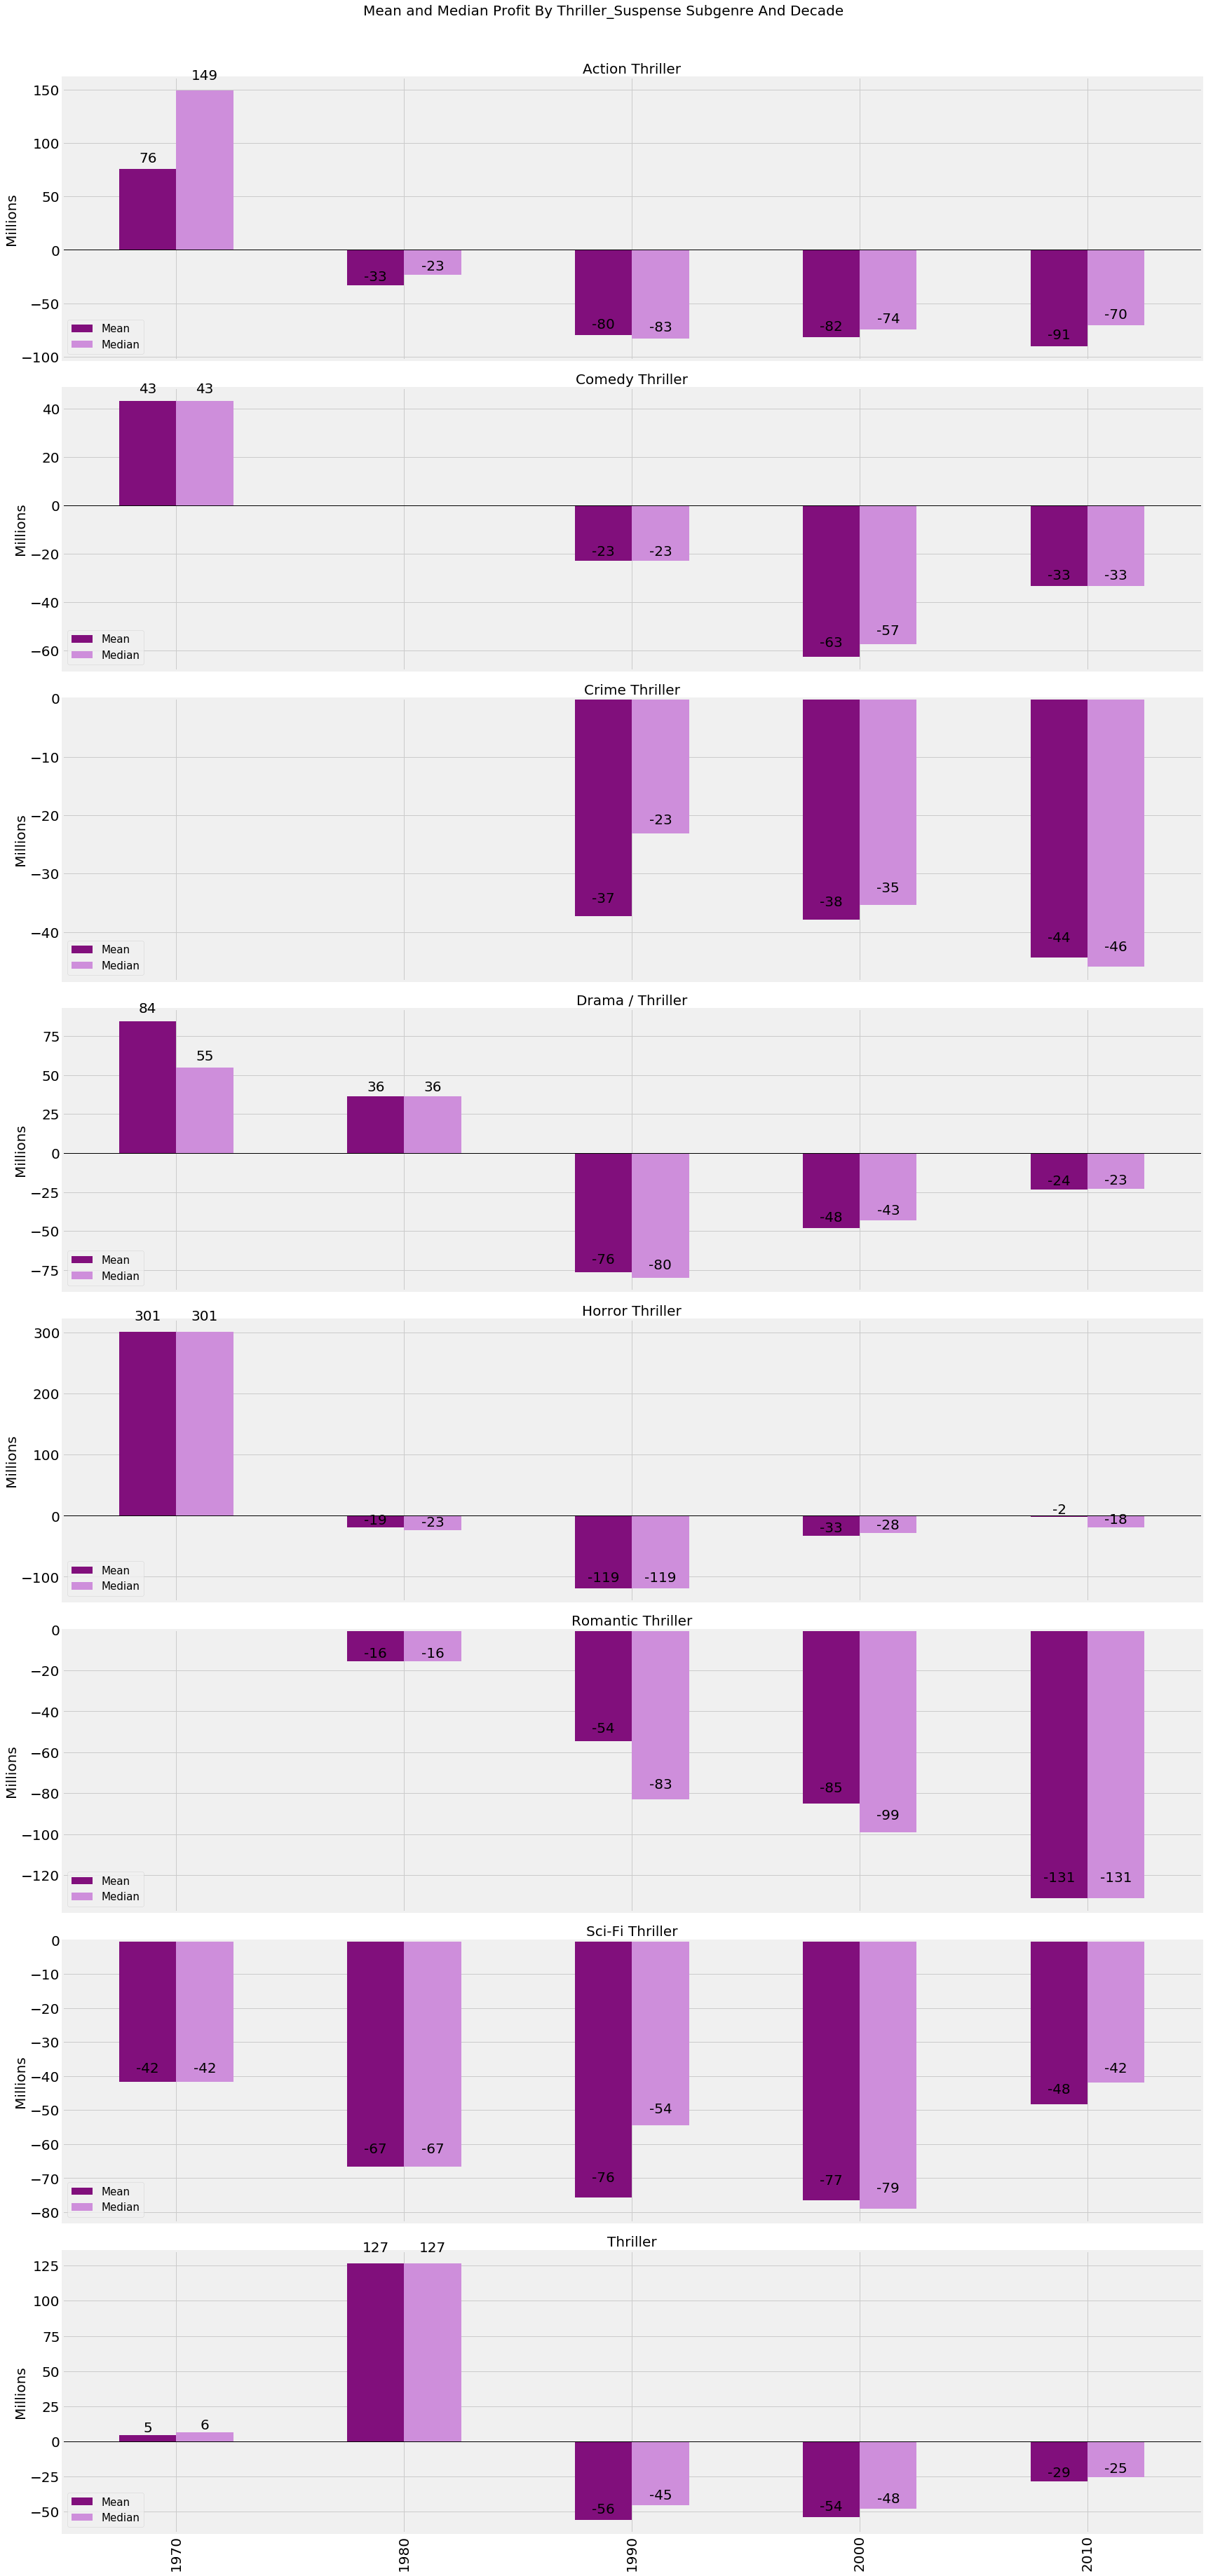

In [78]:
subgenre_profitability_by_decade('thriller_suspense', [genres_dict['thriller_suspense']['color1'], genres_dict['thriller_suspense']['color2']])

### Quick Takeaways

- No Thriller/Suspense subgenres are median profitable in the 1990s, 2000s, or 2010s.

### Summary

There aren't any stellar subgenres in the domestic market.

It seems that for the most part, both the main genres and their subgenres are on average unprofitable at the domestic box office.

The movie industry has changed quite a bit since the 1970s. This has been a nice overview of the industry over the past 50 years, but now we will focus on just the current decade. 

We might be able to find some useful insights about the state of the industry as it is now.

# Current Decade

We will now dive into the performance of movies in this current decade (2010 - 2018).

- 16.1 Look at the breakeven percentage for all genres this decade. 
- 16.2 Summarize our findings.
- 16.3 Look at the domestic profits for all genres this decade. 
- 16.4 Summarize our findings.
- 16.5 Create a new column `budget_bins` that categorizes each movie by budget size. The options are '0 - 1m', '1 - 5m', '5 - 10m', '10 - 25m', '25 - 50m', '50 - 100m', '100 - 200m', '200 - 300m', and '300 - 400m'. These represent where each movie's production budget falls (in millions of dollars). Then we create some custom functions to display domestic profits, breakeven percentage, and the number of movies released for all genres when subdivided by budget size.
- 16.6 Look at Action movies by budget size.
- 16.7 Summarize our findings.
- 16.8 Look at Adventure movies by budget size.
- 16.9 Summarize our findings.
- 16.10 Look at Action/Adventure movies by budget size.
- 16.11 Summarize our findings.
- 16.12 Look at Comedy movies by budget size.
- 16.13 Summarize our findings.
- 16.14 Look at Drama movies by budget size.
- 16.15 Summarize our findings.
- 16.16 Look at Horror movies by budget size.
- 16.17 Summarize our findings.
- 16.18 Look at Thriller/Suspense movies by budget size.
- 16.19 Summarize our findings.
- 16.20 Look at a boxplot showing the domestic profits for all genres this decade.
- 16.21 Summarize our findings.

## Breakeven

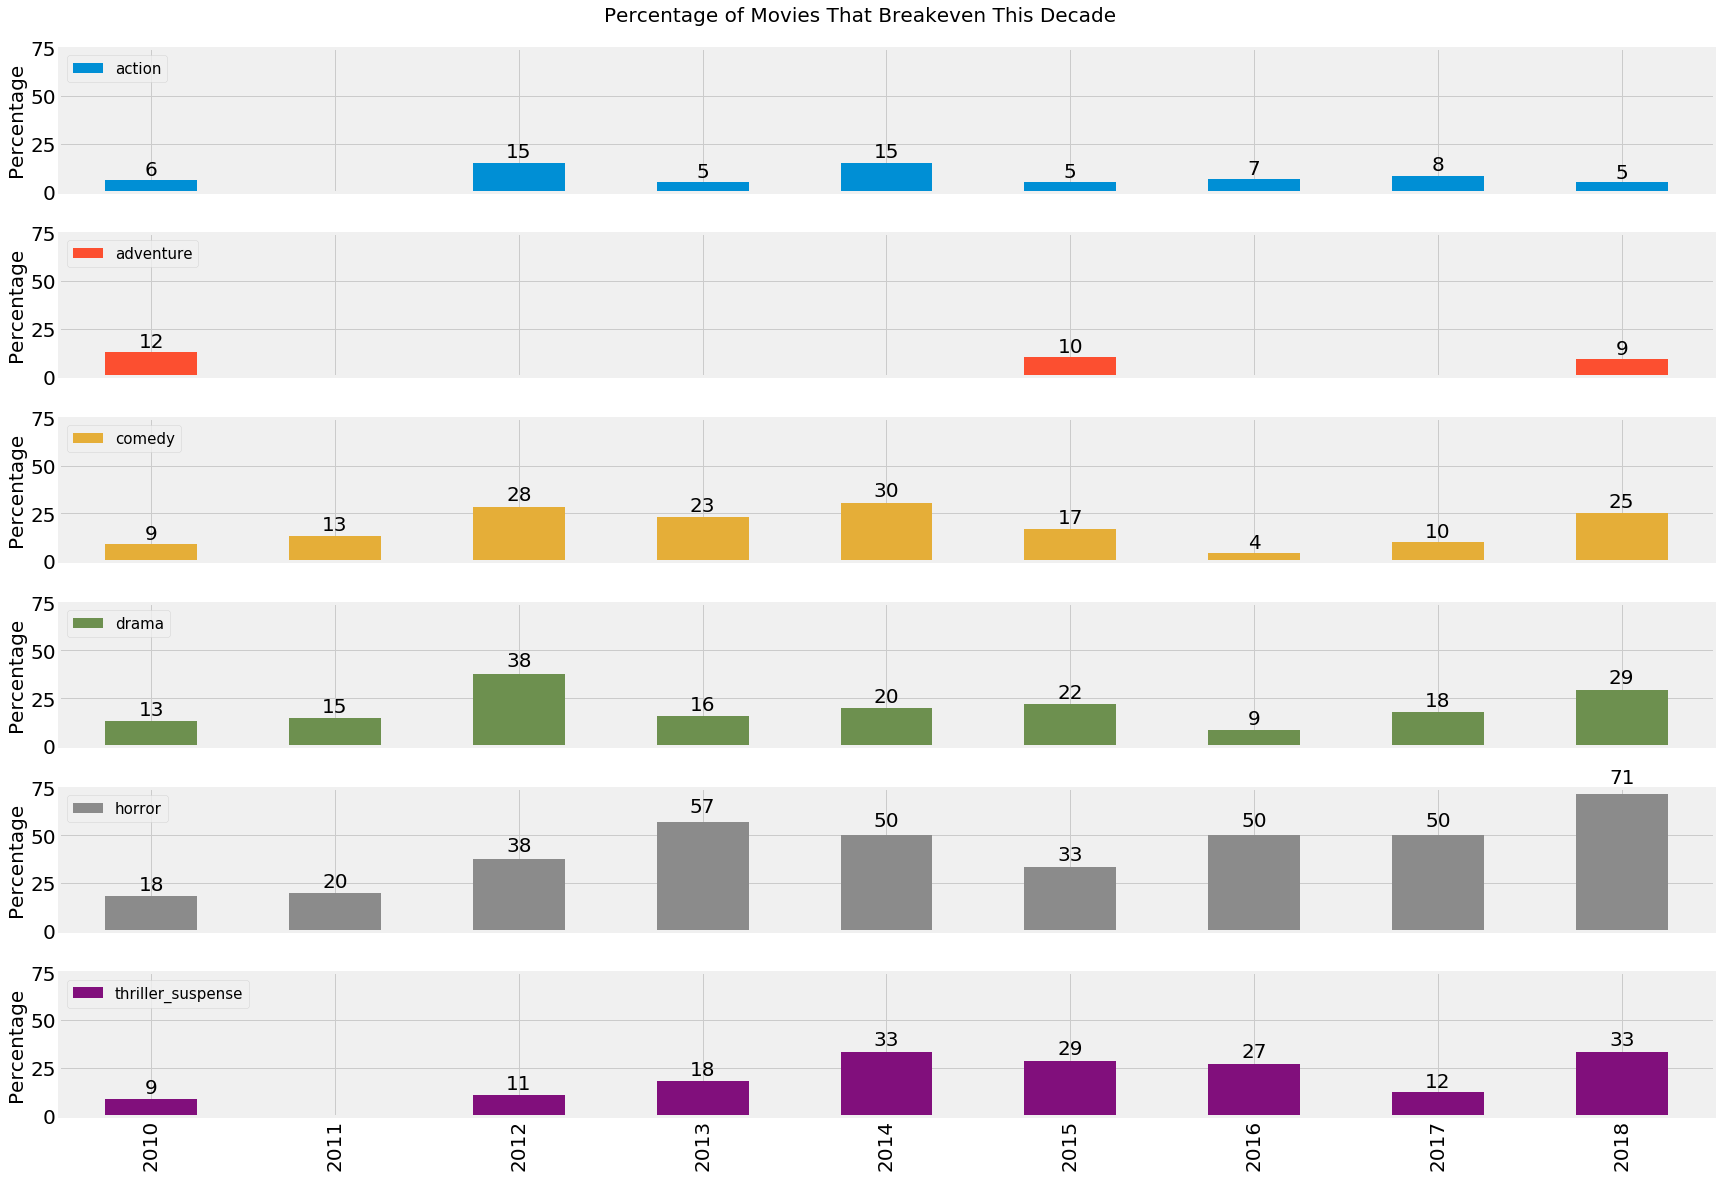

In [79]:
one_stat_over_time_in_separate_graphs(data=data, genres=genres, title='Percentage of Movies That Breakeven This Decade', figsize=(24,16), 
                                      colors=colors, groupby_column='release_year', stat_column='domestic_breakeven', 
                                      aggregation_function='mean', starting_year=2010, apply_needed=True, apply_function=lambda x: x * 100, 
                                      xtick_values=range(2010, 2019, 1), y_label='Percentage', axhline_needed=False, axhline_value='')

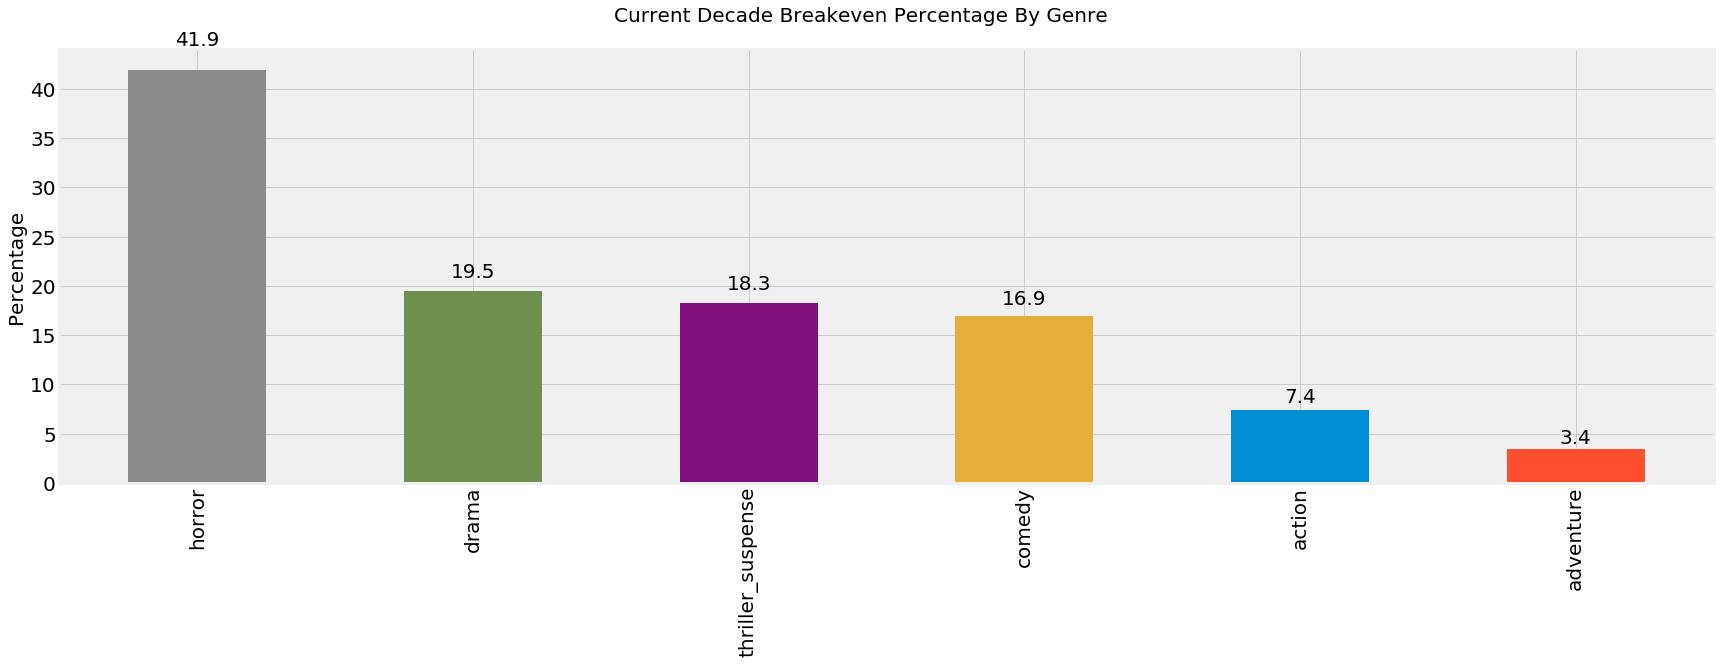

In [80]:
plot_summary_dataframe(summary=summary, sort_column='current_decade_breakeven_percentage', 
                       plot_columns='current_decade_breakeven_percentage', title='Current Decade Breakeven Percentage By Genre', 
                       colors_needed=1, legend_needed=False, legend_text=[], y_label='Percentage', num_decimals=1)

## Quick Thoughts

**Year by year takeaways**
  - There is a great deal of variety in box office results on a year by year basis.
  - For the past decade, the strongest performing genre from a breakeven perspective is Horror.
  - Action and Adventure are the least likely genres to break even at the domestic box office.

## Profitability

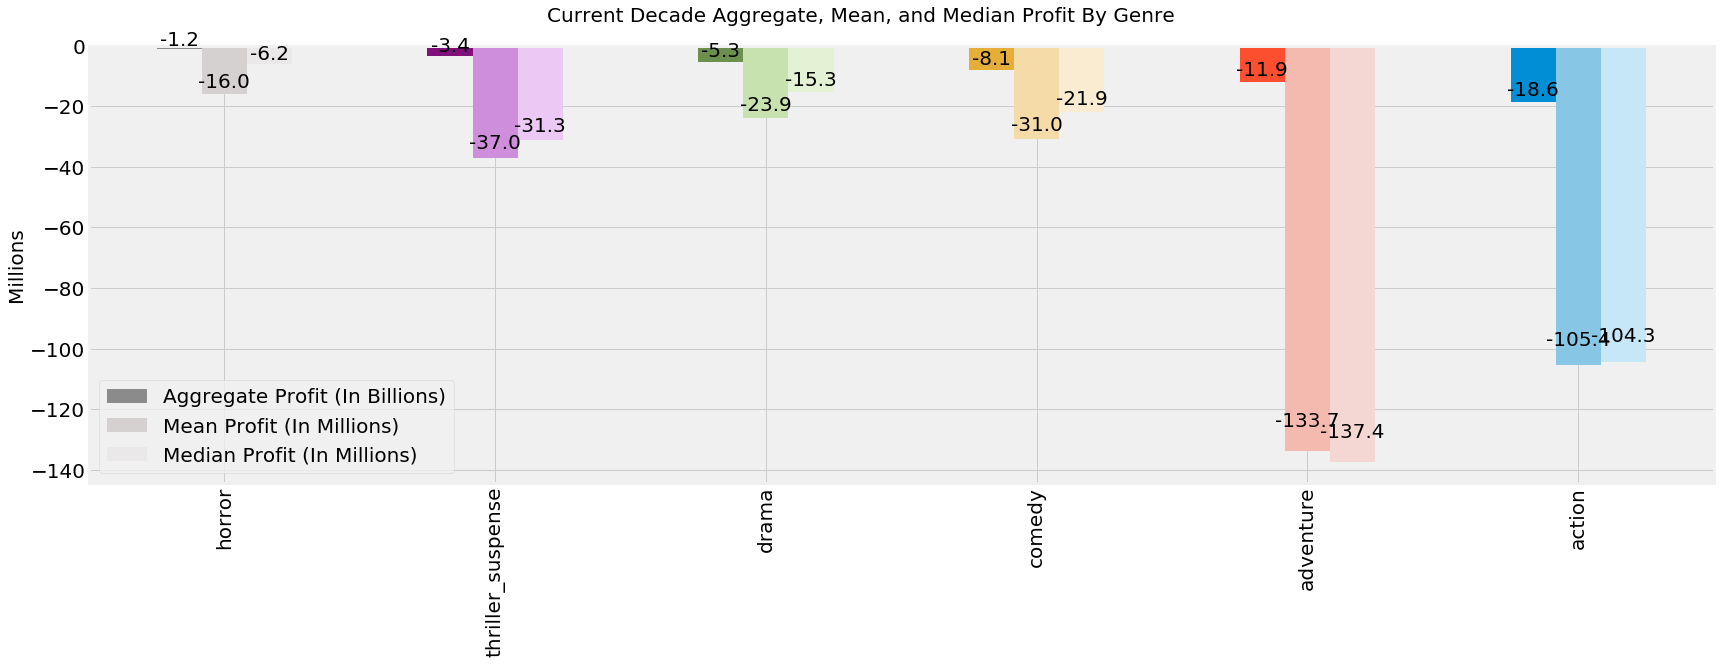

In [81]:
plot_summary_dataframe(summary=summary, sort_column='current_decade_profit', 
                       plot_columns=['current_decade_profit', 'current_decade_mean_profit', 'current_decade_median_profit'], 
                       title='Current Decade Aggregate, Mean, and Median Profit By Genre', colors_needed=3, 
                       legend_needed=True, legend_text=['Aggregate Profit (In Billions)', 'Mean Profit (In Millions)', 'Median Profit (In Millions)'], 
                       y_label='Millions', num_decimals=1)

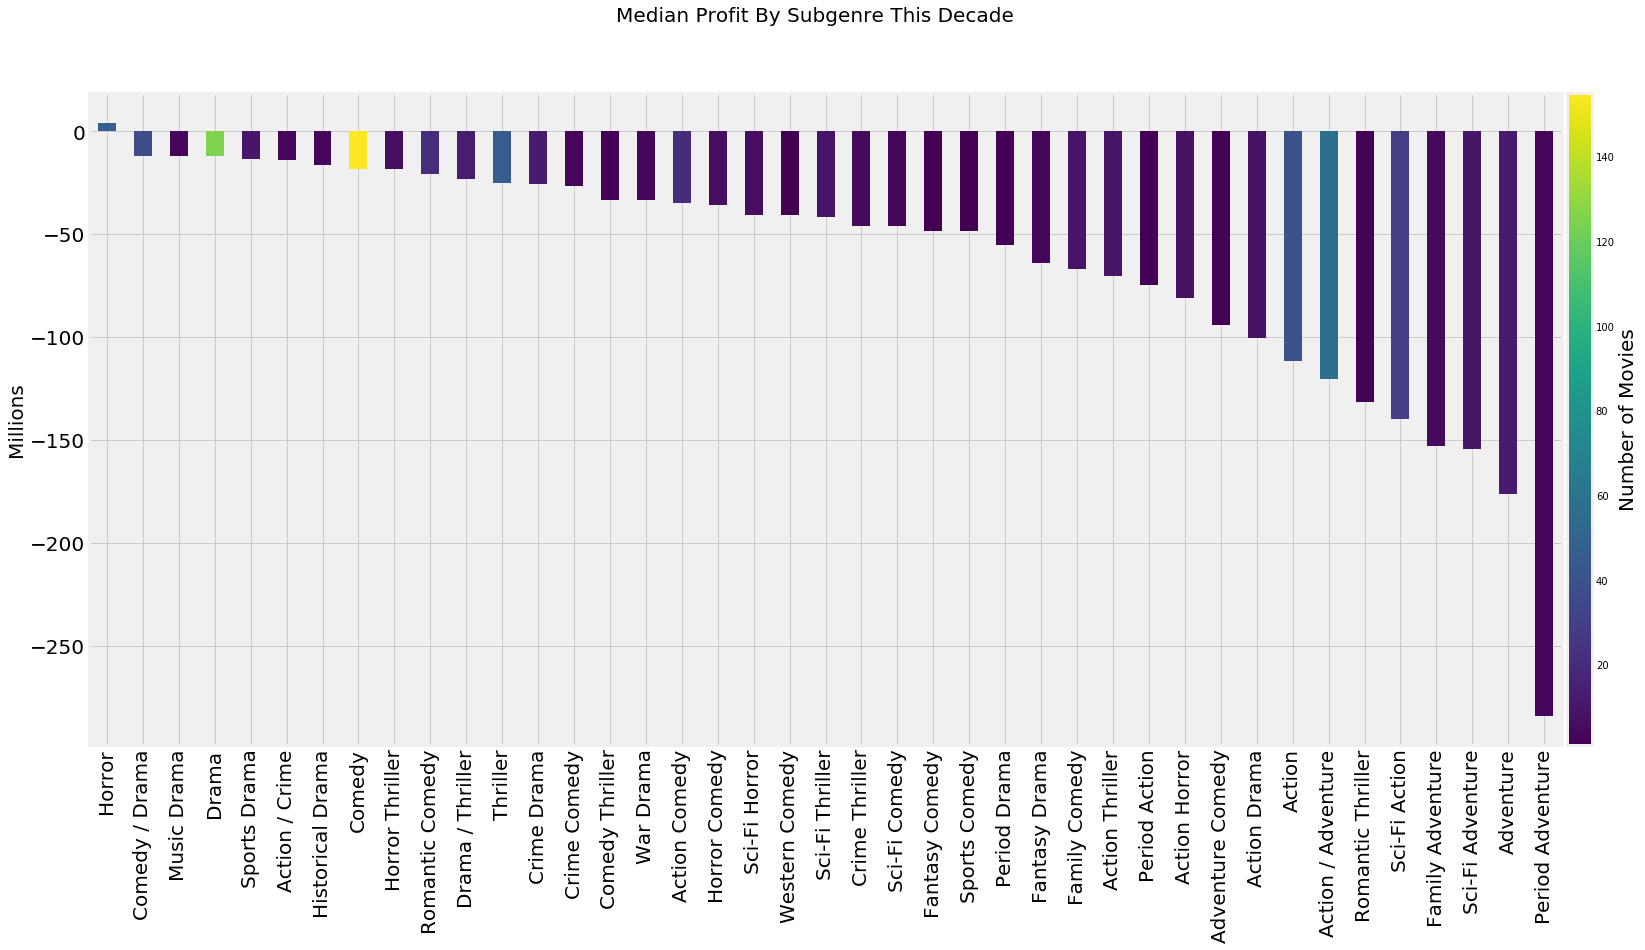

In [82]:
# https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
# https://stackoverflow.com/questions/1735025/how-to-normalize-a-numpy-array-to-within-a-certain-range
# https://matplotlib.org/users/gridspec.html#gridspec-and-subplotspec

# Import colormap functionality from matplotlib
import matplotlib.cm as cm

# To scale our counts array from [0,1] create custom colormap
from sklearn.preprocessing import minmax_scale

figure = plt.figure(figsize=(24,12))
figure.suptitle('Median Profit By Subgenre This Decade', fontsize=20)

gs = matplotlib.gridspec.GridSpec(50, 50)
ax1 = plt.subplot(gs[:, :-1])
ax2 = plt.subplot(gs[:, -1:])

grp = data[data['release_year'] >= 2010].groupby('genres_mojo')['profit'].agg(['median', 'count']).sort_values(by='median', ascending=False)

# Use 'viridis' colormap
viridis = cm.get_cmap('viridis')

# Normalize our counts series
scaled_counts = minmax_scale(grp['count'].astype(float), feature_range=(0,1))

# List of colors using rescaled count values
new_cmap = [viridis(item) for item in scaled_counts]

(grp['median'] / 1000000).plot(kind='bar', ax=ax1, color=new_cmap)

norm = matplotlib.colors.Normalize(vmin=grp['count'].min(), vmax=grp['count'].max())

cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=viridis, norm=norm, orientation='vertical')
ax2.set_ylabel('Number of Movies', fontsize=20)
ax1.set_xlabel('')
ax1.set_ylabel('Millions', fontsize=20)
ax1.tick_params(labelsize=20)

## Quick Takeaways

**Aggregate Profit**
  - This is just adding up the profits (or losses) of each movie in each category in this decade.
  - The most profitable genre in aggregate is Horror with <span style='color:red'>-\\$1.2 billion</span>.
  - Like we've seen before, the domestic market alone is insufficient for most movies to be profitable.
  
**Mean Profit**
  - All genres have negative mean profit this decade.
  - Horror loses the least amount of money, with a mean profit of <span style='color:red'>-\\$16 million</span>.
  - Action is at <span style='color:red'>-\\$105.4 million</span>.  
  - Adventure is at <span style='color:red'>-\\$133.7 million</span>.
    
**Median Profit**
  - Horror loses the least amount of money, with a median profit of <span style='color:red'>-\\$6.2 million</span>.
  - Action is at <span style='color:red'>-\\$104.3 million</span>.
  - Adventure is at <span style='color:red'>-\\$137.4 million</span>.
  
**Subgenres**
  - The only subgenre with a positive median profitability is Horror (yes, the subgenre is Horror within the main genre of Horror. Basically, this doesn't include all the movies we consider Horror movies, only those whose genre label is specifically "Horror".). 
  - It's important to keep in mind the relatively low number of movies produced in most of these subgenres this decade. That could be indicative of a contraction in output or simply having a time window too brief to allow enough data points. 

## Breakdown By Budget

It might help to further subdivide our genres by their budgets to look for patterns there.

In [83]:
bins = [0, 1000000, 5000000, 10000000, 25000000, 50000000, 100000000, 200000000, 300000000, 400000000]
group_names = ['0 - 1m', '1 - 5m', '5 - 10m', '10 - 25m', '25 - 50m', '50 - 100m', '100 - 200m', '200 - 300m', '300 - 400m']
subgenre_colors = ['#8d6a9f', '#006494', '#fcfc62', '#2d4739', '#bb342f', '#6eeb83', '#e56399', '#ffe8d4', '#57886c', '#ff7700', '#16f4d0', '#bfae48', '#90c290', '#330f0a']

data['budget_bins'] = pd.cut(data['budget_adj'], bins, labels=group_names)

In [84]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to add blue if a majority of the films break even 
def background_color_blue_if_greater_than_fifty_percent(val):    
    if val > 0.5:
        return 'background-color: {}'.format('#87C7E5')
    
    return ''

In [85]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
# Custom function to highlight the max value in a series
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''), index=data.index, columns=data.columns)

## Action

In [86]:
# Create custom function to display profit and count information by genre and budget size for the current decade (2010s)
def current_decade_budget_sizes(data, genre):
    styler_object = (data[
        (data['release_year'] >= 2010) & 
        (data['genres_mojo'].str.contains(genre))
    ][['budget_bins', 'profit', 'domestic_breakeven']]
    .apply(lambda x: x / 1000000 if x.name == 'profit' else x)
    .sort_values(by=['budget_bins', 'profit'], ascending=False)
    .groupby('budget_bins')
    .agg(['mean', 'median', 'count', 'sum'])
    .drop([('profit', 'count'), ('profit', 'mean'), ('profit', 'sum'), ('domestic_breakeven', 'median')], axis=1)
    .dropna()
    .style
    .applymap(background_color_blue_if_greater_than_fifty_percent, subset=[('domestic_breakeven', 'mean')])
    .apply(highlight_max, subset=[('domestic_breakeven', 'count')])
    .background_gradient('winter', subset=[('profit', 'median')]))
    
    return styler_object

In [87]:
action_budget_info = current_decade_budget_sizes(data=data, genre='Action')
action_budget_info

## Quick Takeaways

**Most produced budget**
  - The 100-200m range has 73 movies produced but is not median profitable this decade.
  
**Most profitable budget**
  - The 10-25m range is the most "profitable" with a median loss of <span style='color:red'>-\\$12 million</span>.
  - As the budget size increases, Action movies lose more money at the domestic box office.
  
**Least profitable budget**
  - The 300-400m range has a median loss of <span style='color:red'>-\\$343 million</span>, but this stems from only one movie.
  - Perhaps more telling is the 200-300m range with a median loss of <span style='color:red'>-\\$201 million</span> with 0/24 movies breaking even. 
  
**Conclusions**
  - Seemingly no budget size in Action movies is a great bet for the domestic market.

## Adventure

In [88]:
adventure_budget_info = current_decade_budget_sizes(data=data, genre='Adventure')
adventure_budget_info

## Quick Takeaways

**Most produced budget**
  - The 100-200m range with 42 movies.
  
**Most profitable budget (descending order)**
  - Like with Action movies, the larger the budget size, the more money a given Adventure movie loses. 
  - The budget size that loses the least money is 10-25m.
  
**Least profitable budget**
  - The 200-300m range with 0/24 movies breaking even and a median loss of <span style='color:red'>-\\$215 million</span>.
  
**Conclusions**
  - Seemingly no budget size in Action movies is a great bet for the domestic market.

## Comedy

In [89]:
comedy_budget_info = current_decade_budget_sizes(data=data, genre='Comedy')
comedy_budget_info

## Quick Takeaways

**Most produced budget**
  - The 25-50m range with 92 movies, followed by the 10-25m range with 75 movies. Neither are median profitable this decade.
  
**Most profitable budget**
  - The 0-1m range with 2/3 profitable movies and a median profit of \\$0.3 million. Every other budget size is a median loser.
  
**Least profitable budget**
  - The 200-300m range has only 1 movie and it lost <span style='color:red'>-\\$271 million</span>.
  - The 100-200m range has 0/14 profitable movies and a median loss of <span style='color:red'>-\\$124 million</span>.
  
**Conclusions**
  - Much like the other genres so far, the larger the budget size, the more money the movie loses.

## Drama

In [90]:
drama_budget_info = current_decade_budget_sizes(data=data, genre='Drama')
drama_budget_info

## Quick Takeaways

**Most produced budget**
  - The 10-25m range with 77 movies, followed by the 25-50m range with 56 movies. Neither are median profitable this decade.
  
**Most profitable budget**
  - The 0-1m range had 3/3 movies profitable with a median profit of \\$0.3 milllion. 
  
**Least profitable budget**
  - The 100-200m range had 0/9 movies profitable with a median loss overall of <span style='color:red'>-\\$149 million</span>.
  
**Conclusions**
  - The same trend applies here as it does for the other genres so far.

## Horror

In [91]:
horror_budget_info = current_decade_budget_sizes(data=data, genre='Horror')
horror_budget_info

## Quick Takeaways

**Most produced budget**
  - The 5-10m, 10-25m, and 25-50m are all produced in roughly equal numbers.
  
**Most profitable budgets**
  - The 1-5m range had 5/5 movies profitable with a median profit of \\$27.5 million.
  - The 5-10m range had 13/17 movies profitable with a median profit of \\$19 million.
  - 0-1m range had 1/1 movies profitable with a median profit of \\$11.9 million.
  
**Least profitable budget**
  - Any movie with a budget of \\$25 million or higher is a median loser.
  - The 100-200m range had 0/3 movies profitable with a median loss of <span style='color:red'>-\\$202.5 million</span>.
  
**Conclusions**
  - Horror movies with budgets less than \\$25 million are median profitable.
  - The most succesful movies have a budget somewhere in the \\$1-10 million range.

## Thriller/Suspense

In [92]:
thriller_suspense_budget_info = current_decade_budget_sizes(data=data, genre='Thriller|Suspense')
thriller_suspense_budget_info

## Quick Takeaways

**Most produced budget**
  - The 25-50m range with 29 movies, followed by the 50-100m range with 24 movies. Both are median losers.
  
**Most profitable budget**
  - The 1-5m range has 3/4 movies profitable with a median profit of \\$14 million.
  
**Least profitable budget**
  - The 200-300m range has 0/1 movies profitable with a median loss of <span style='color:red'>-\\$185.6 million</span>.
  - The 100-200m range has 0/7 movies profitable with a median loss of <span style='color:red'>-\\$133.8 million</span>.
  
**Conclusions**
  - Thriller/Suspense movies budgeted from \\$1-10 million have the best chance to succeed in the domestic market.

## Profit Boxplot For The Current Decade

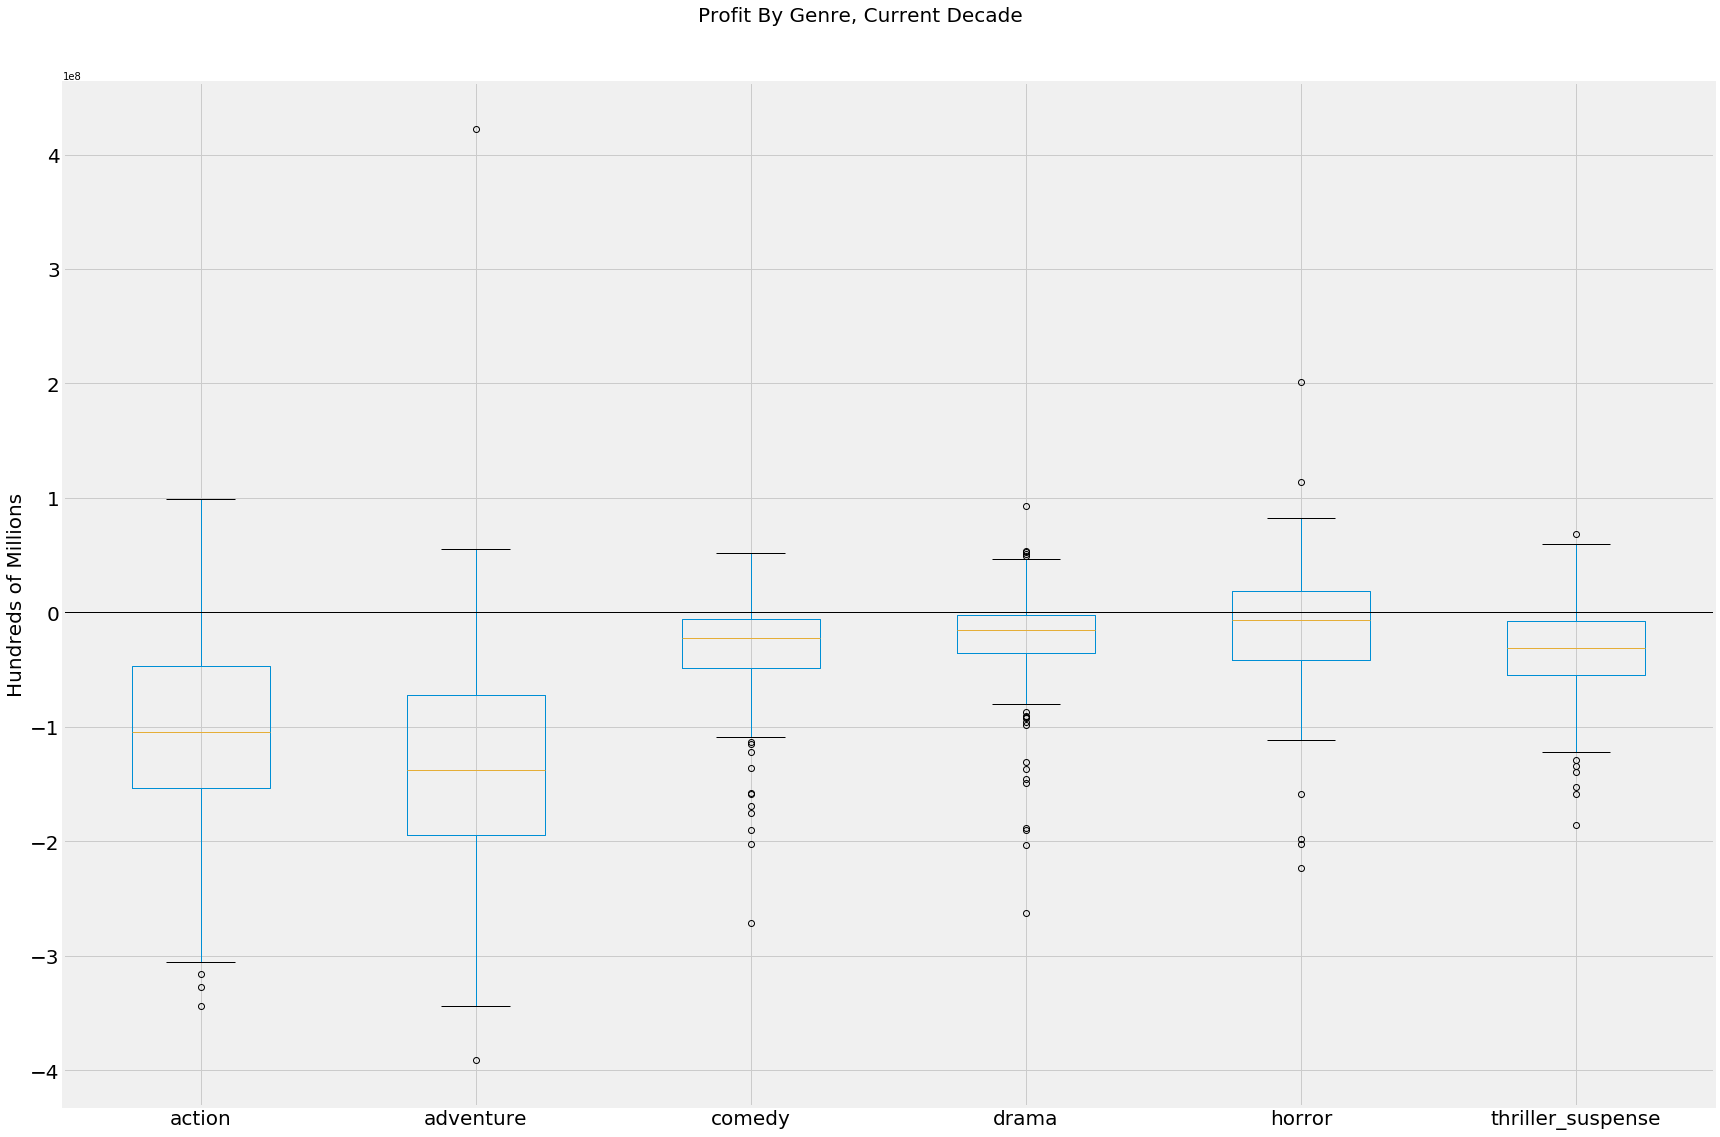

In [93]:
plot_boxplot(data=data, genres=genres, title='Profit By Genre, Current Decade', columns=profit_columns, starting_year=2010, y_label='Hundreds of Millions')

## Summary

The boxplot helps shed some light on each genre's strengths and weaknesses.

The horizontal black represents the point where a movie breakes even domestically.

The yellow line in each box is the median profit/loss value for that genre at the domestic box office this decade.

The two T-shapes (one above and one below each box, also called "whiskers") represent the highest and lowest "normal" values for the genre this decade. These represent the highest and lowest values that movies in each genre can have that we wouldn't consider unusual. 

The circles on the outside of these whiskers represent outliers. These are either mega-hits or mega-bombs at the domestic box office. 

**The average movie in any genre is not domestically profitable**
  - The median profit/loss value for all genres this decade is negative.
  - That means that more than half of all movies in all genres lost money at the domestic box office this decade.
  
**Action and Adventure**
  - They have the largest median loss of all six genres.
  - Their whiskers also have the largest spread. This means the vast majority of all movies in these genres lose money at the domestic box office.
  
**Comedy, Drama, Horror, and Thriller/Suspense**
  - Their boxplots have similar shapes: much tighter spreads and negative medians much closer to zero.
  - Horror movies have the best chance to break even.
  - Comedy and Drama have many outliers that are mega-bombs.
  
**Recommendation**
  - If we had to select a genre to make, we should pick Horror. But no genre is a great investment when only looking at the domestic box office. 
  
**Final step**
  - Let's examine each genre's performance by its release week and see if we learn anything interesting. 

# Analyze By Release Week

We will now dive into the performance of movies by their release week in the calendar year (e.g. 1 - 53 (some years stretch into a 53rd week)).

- 17.1 Look at the number of movies in every release week. 
- 17.2 Summarize our findings.
- 17.3 Look at the number of movies in every release week in separate bar graphs. 
- 17.4 Summarize our findings.
- 17.5 Look at the number of movies in every release week this decade in separate bar graphs. 
- 17.6 Summarize our findings. 
- 17.7 Look at the difference in median domestic box office gross amounts in every release week (all-time versus this decade).
- 17.8 Summarize our findings. 
- 17.9 Look at the difference in median domestic production budget amounts in every release week (all-time versus this decade).
- 17.10 Summarize our findings.
- 17.11 Look at the difference in median domestic profit amounts in every release week (all-time versus this decade).
- 17.12 Summarize our findings.
- 17.13 Look at breakeven percentages.
  - 17.13.1 In every release week for all-time.
  - 17.13.2 Summarize our findings.
  - 17.13.3 In every release week for this decade.
  - 17.13.4 Summarize our findings.
  - 17.13.5 By decade.
  - 17.13.6 Summarize our findings.
- 17.14 Summarize our findings.

## Number of Movies

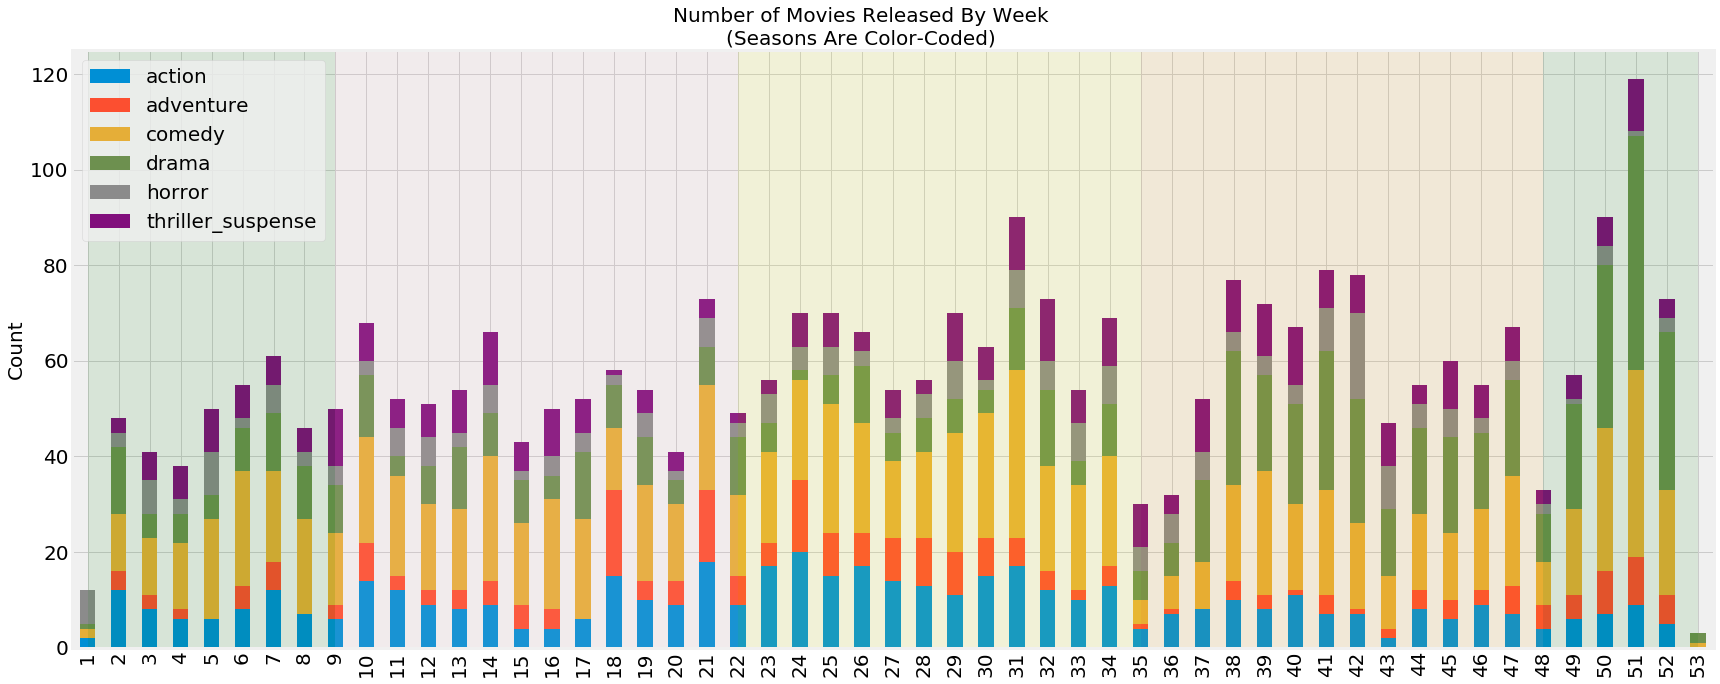

In [94]:
figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Movies Released By Week\n(Seasons Are Color-Coded)', fontsize=20, y=1.05)

grp = data.groupby('release_week')[genres].sum()
grp.plot(kind='bar', stacked=True, ax=axis)
axis.set_ylabel('Count', fontsize=20)
axis.set_xlabel('')
axis.tick_params(labelsize=20)
axis.legend(genres, fontsize=20)

# Subtract one from axvspan ranges to account for it being a bar chart and not a line chart (e.g. Spring is weeks 9-22)
axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
axis.axvspan(47, 52, alpha=0.1, facecolor='green')
axis.axvspan(0, 8, alpha=0.1, facecolor='green')

plt.tight_layout()

## Quick Takeaways

Other than a few weeks, there have been a healthy amount of movies being released on every possible week.

Let's subdivide by genre to get a better look.

## All-Time

In [95]:
def num_movies_released_by_release_week_by_genre(data, title, starting_year=1970, genres=genres, colors=colors):
    figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(24, 16), sharex=True, sharey=True)
    figure.suptitle(title, fontsize=20, y=1.02)

    for genre, axis, color in zip(genres, axes.flat, colors):
        grp = data[(data['release_year'] >= starting_year) & (data[genre])].groupby('release_week')['title'].count()

        # If the series is missing a decade, add it as an index
        # Then set the value to 0
        for week in range(1, 54):
            if week not in grp.index:
                grp.loc[week] = 0

        grp.sort_index(inplace=True, ascending=True)

        grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
        axis.set_ylabel('Count', fontsize=12)
        axis.set_xlabel('')
        axis.legend([genre], loc=2, fontsize=15)

        # Subtract one from axvspan ranges to account for it being a bar chart and not a line chart
        axis.axvspan(8, 21, alpha=0.1, facecolor='pink')
        axis.axvspan(21, 34, alpha=0.1, facecolor='yellow')
        axis.axvspan(34, 47, alpha=0.1, facecolor='orange')
        axis.axvspan(47, 52, alpha=0.1, facecolor='green')
        axis.axvspan(0, 8, alpha=0.1, facecolor='green')

    plt.tight_layout() 

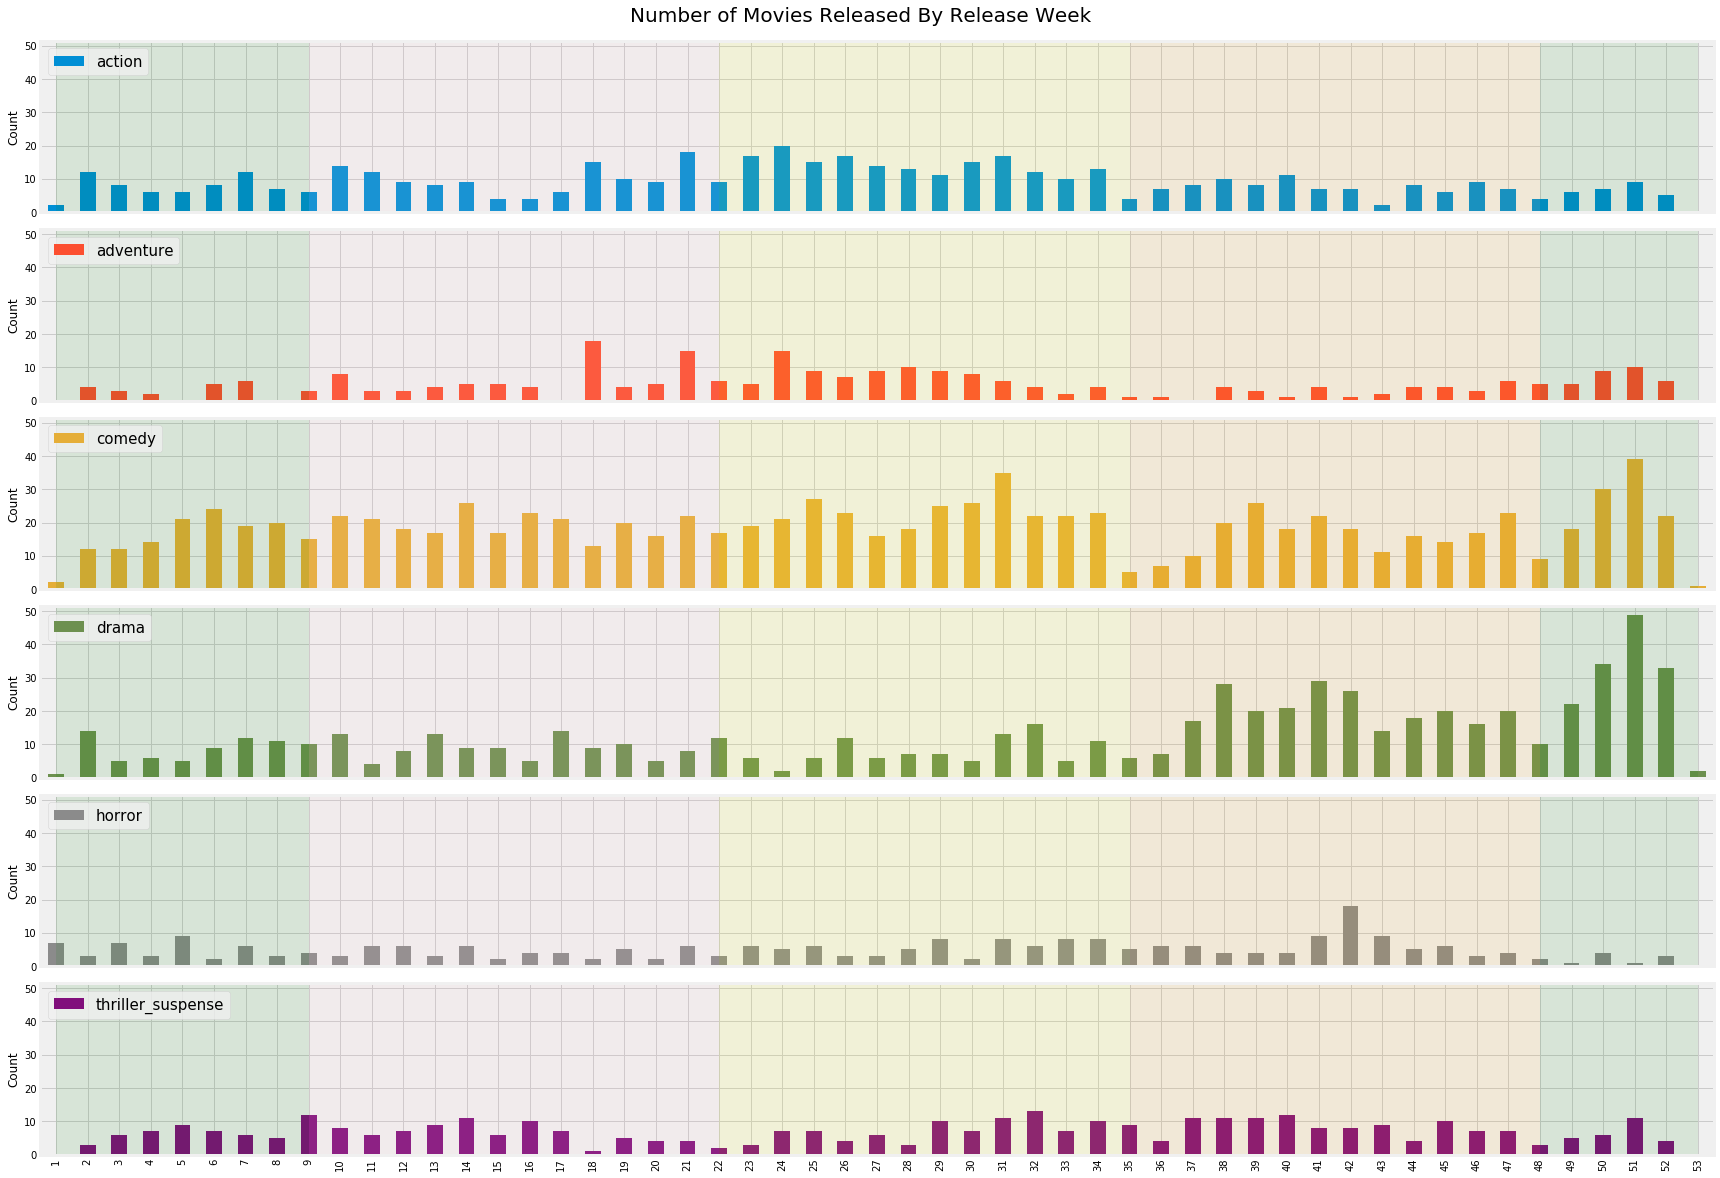

In [96]:
num_movies_released_by_release_week_by_genre(data=data, title='Number of Movies Released By Release Week', 
                                             starting_year=1970, genres=genres, colors=colors)

## Quick Takeaways

Comedy has been released in good numbers in practically every week.

Drama is released the most in Fall and Winter. 

Action and Adventure are released the most in Summer.

Horror and Thriller/Suspense don't really have clear patterns.

## This Decade

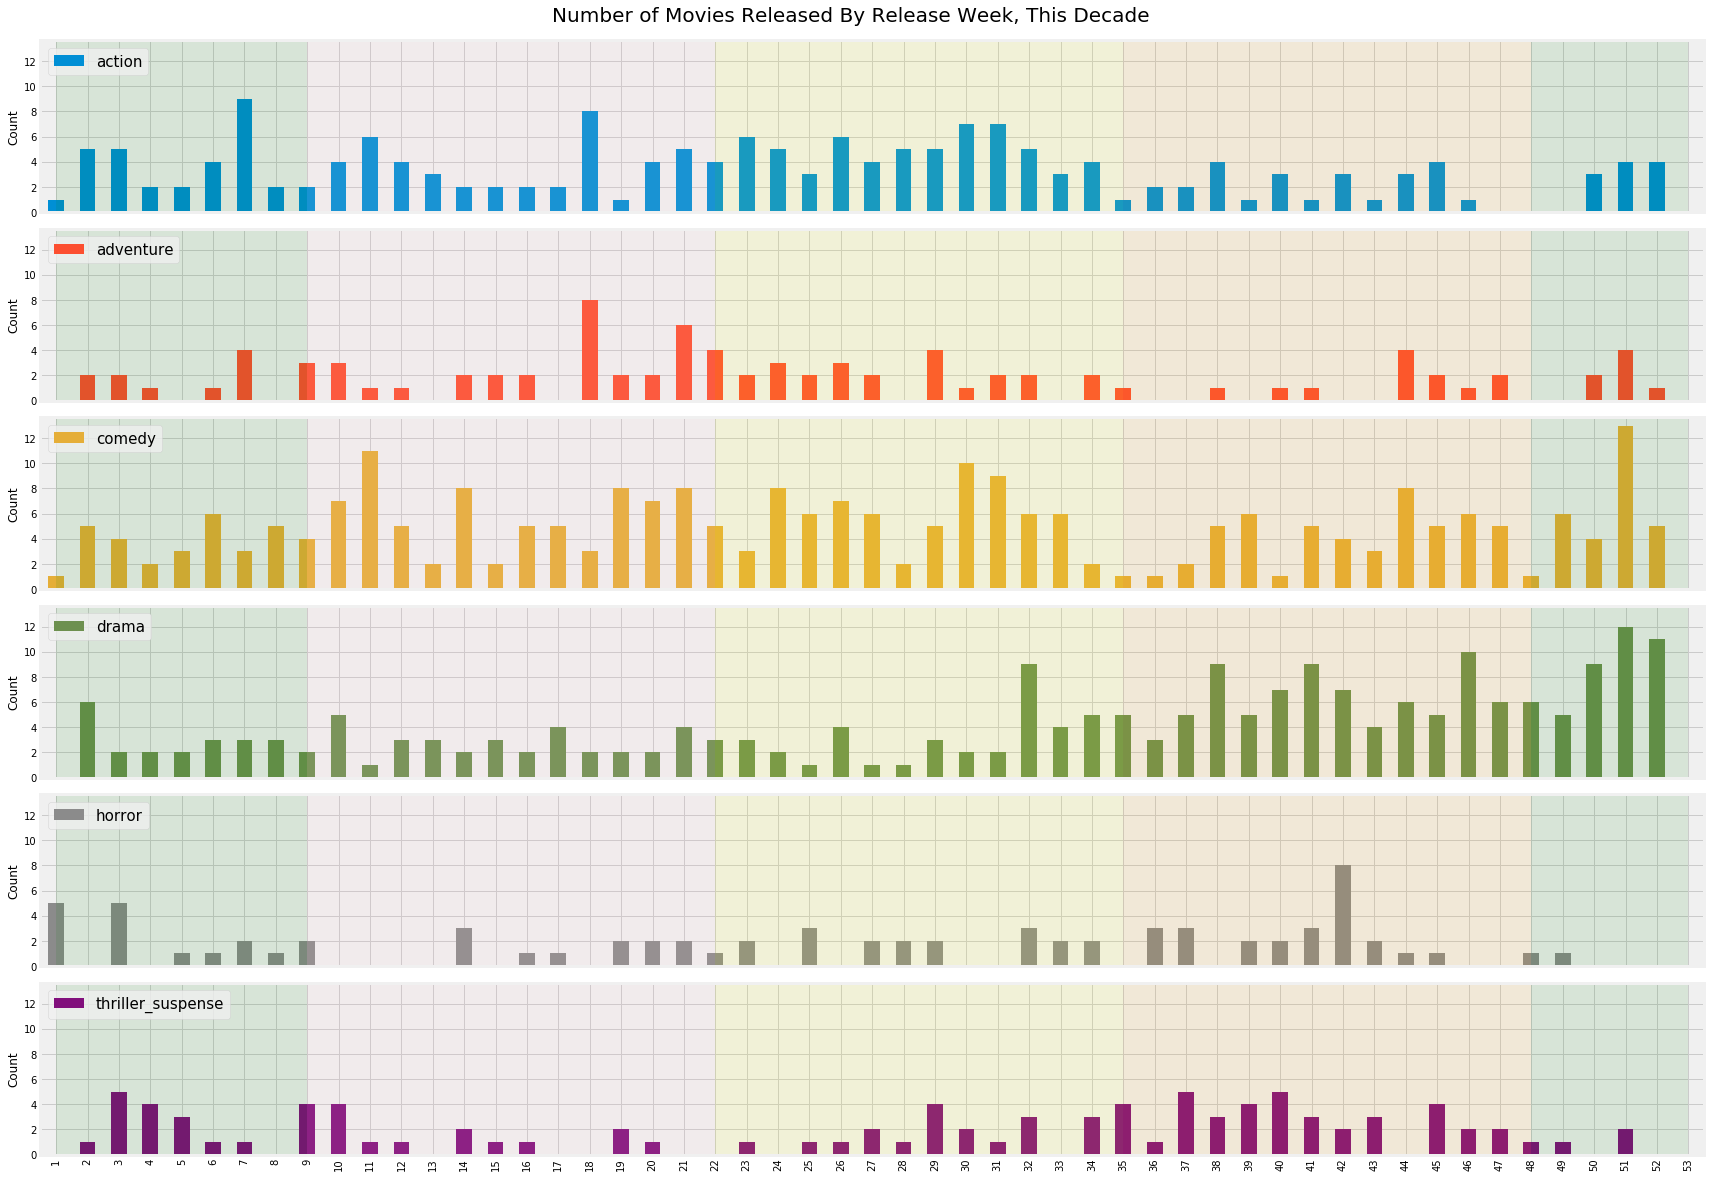

In [97]:
num_movies_released_by_release_week_by_genre(data=data, title='Number of Movies Released By Release Week, This Decade', 
                                             starting_year=2010, genres=genres, colors=colors)

## Quick Takeaways

Comedy is released consistently in more weeks than any other genre.

Drama is still weighted towards Fall and Winter weeks.

Action is concentrated on Summer releases.

Adventure, Horror, and Thriller/Suspense have less clear patterns.

## Median Gross

In [98]:
# Custom function to graph a fill_between line graph of a stat's performance by release week in two ways: all-time and the current decade 
def fill_between_by_release_week(data, title, stat, genres=genres, colors=colors, y_label='Millions'):
    figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
    figure.suptitle(title, fontsize=20, y=1.05)

    for genre, axis, color in zip(genres, axes.flat, colors):
        grp1 = data[(data['release_year'] < 2010) & (data[genre])].groupby('release_week')[stat].median() / 1000000
        grp2 = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')[stat].median() / 1000000

        for year in range(1, 54, 1):
            if year not in grp1.index:
                grp1.loc[year] = 0

            if year not in grp2.index:
                grp2.loc[year] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp1.sort_index(ascending=True, inplace=True)
        grp2.sort_index(ascending=True, inplace=True)

        axis.plot(range(1,54), grp1, color=colors[0], label='1970-2009')
        axis.plot(range(1,54), grp2, color=colors[1], label='This Decade') 

        axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 <= grp1, facecolor=colors[0], interpolate=True, edgecolor='k')
        axis.fill_between(range(1, 54), y1=grp1, y2=grp2, where=grp2 > grp1, facecolor=colors[1], interpolate=True, edgecolor='k')

        axis.set_title(genre, fontsize=20)

        axis.set_ylabel(y_label, fontsize=12)
        axis.set_xlabel('')
        axis.legend(loc=2, fontsize=15)
        axis.axvspan(9, 22, alpha=0.2, color='pink')
        axis.axvspan(22, 35, alpha=0.2, color='yellow')
        axis.axvspan(35, 48, alpha=0.2, color='orange')
        axis.axvspan(48, 53, alpha=0.2, color='green')
        axis.axvspan(1, 9, alpha=0.2, color='green')

    plt.tight_layout() 

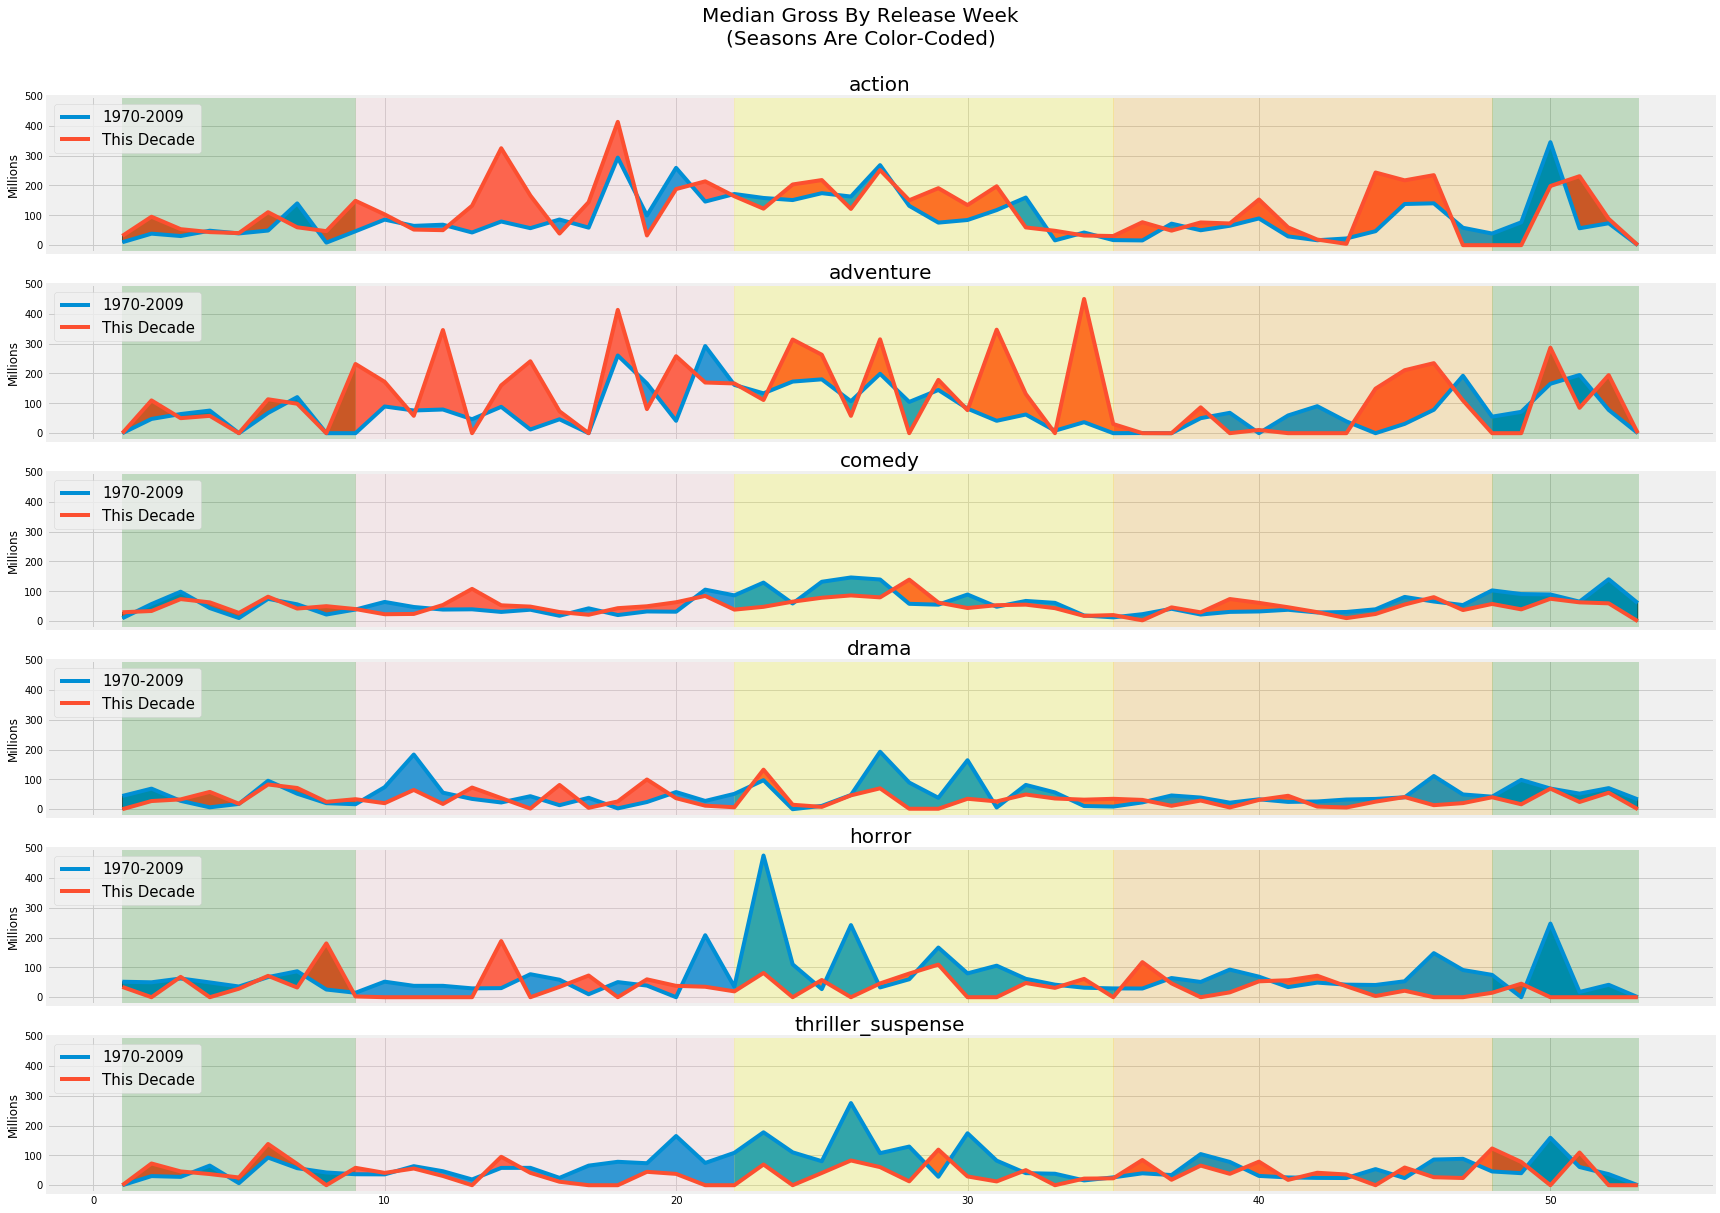

In [99]:
fill_between_by_release_week(data=data, title='Median Gross By Release Week\n(Seasons Are Color-Coded)', 
                             stat='domestic_adj', genres=genres, colors=colors, y_label='Millions')

## Quick Takeaways

**Action**
  - Has higher median grosses on almost every release week this decade compared to its historical numbers.
  - The biggest increases occur in Spring and Fall.
  - Summer in general is higher this decade than it has been as well.
  
**Adventure**
  - Has higher median grosses on almost every release week this decade compared to its historical numbers.
  - The biggest increases occur in Spring and Summer.
  
**Comedy and Drama**
  - Has a dropoff in Summer and Winter compared to historically.
  
**Horror**
  - Has a huge dropoff in Summer and Winter compared to historically. 
  
**Thriller/Suspense**
  - Has a huge dropoff from end of Spring through Summer compared to historically.

## Budgets

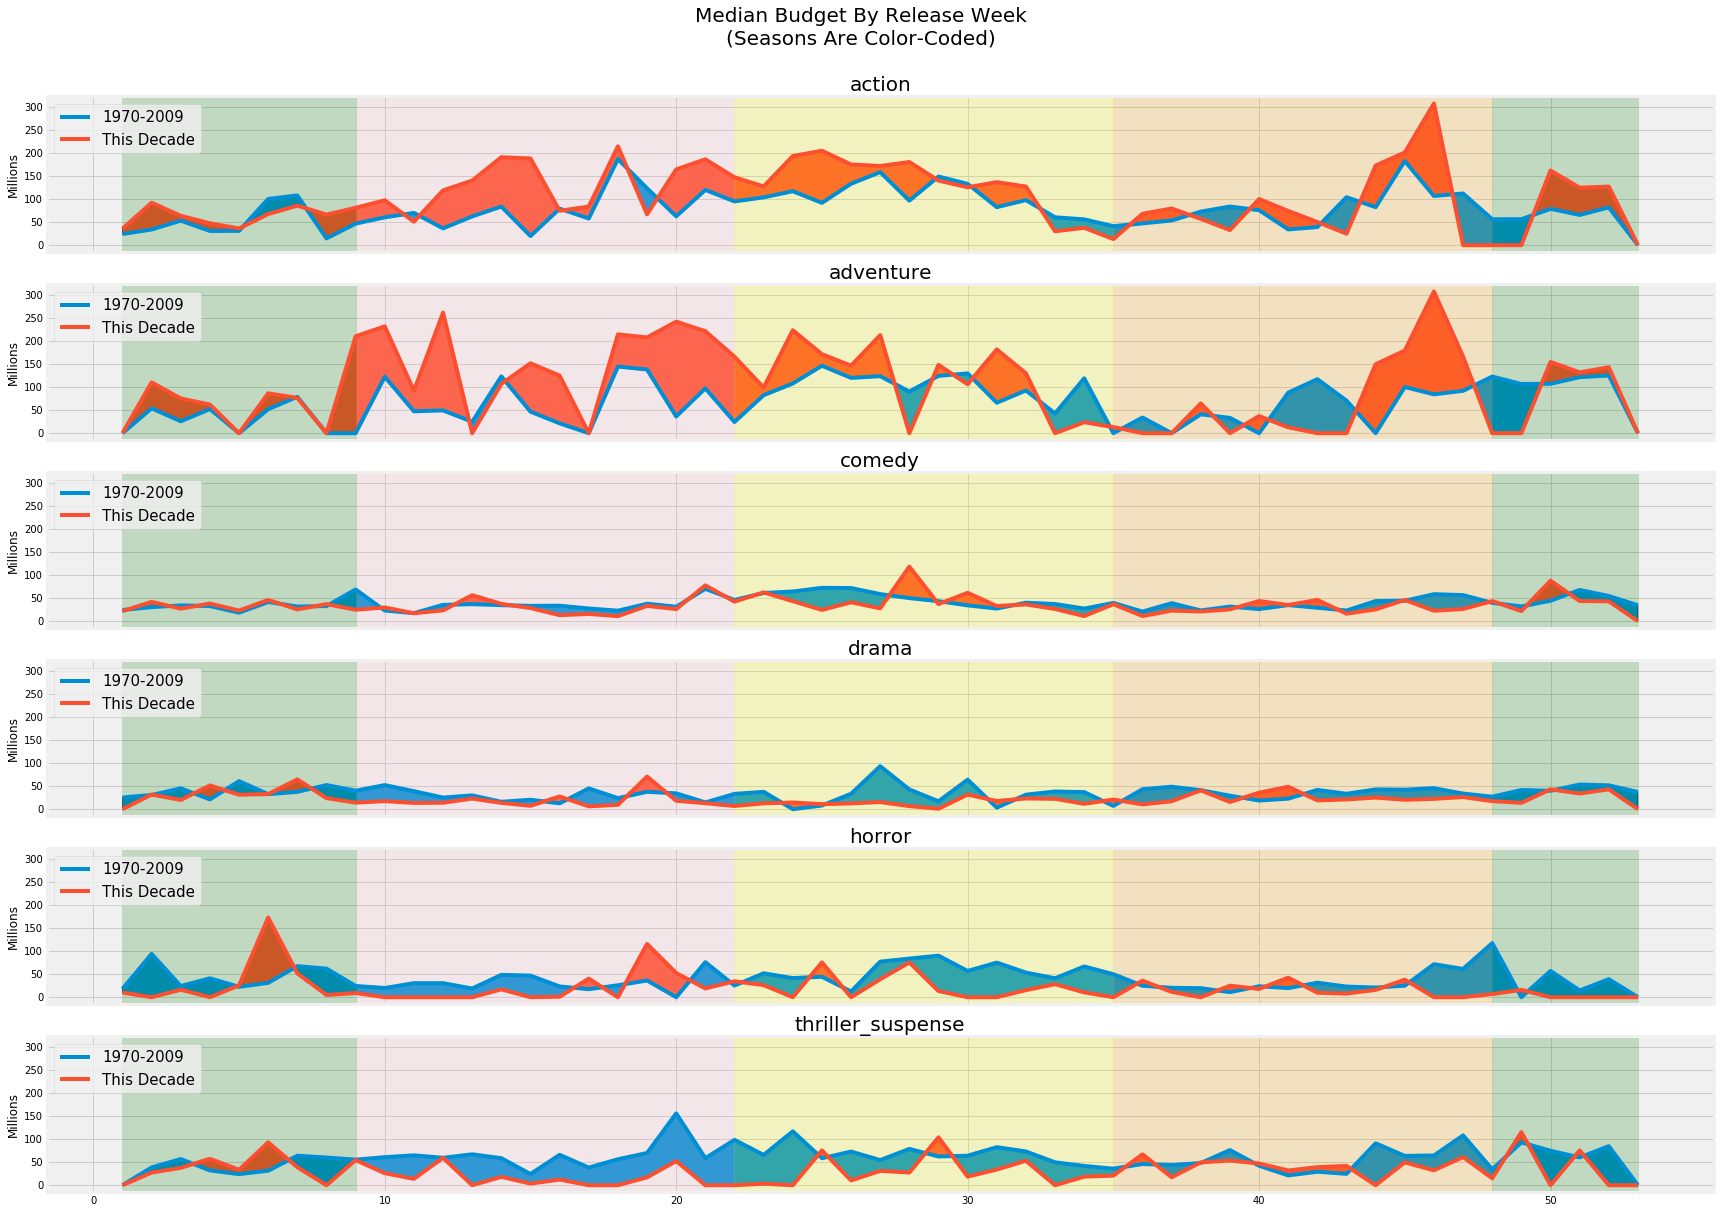

In [100]:
fill_between_by_release_week(data=data, title='Median Budget By Release Week\n(Seasons Are Color-Coded)', 
                             stat='budget_adj', genres=genres, colors=colors, y_label='Millions')

## Quick Takeaways

  - Action and Adventure have higher median budgets for pretty much every release week.
  - Comedy and Drama seem to have moderately lower budgets overall this decade in most release weeks.
  - Horror and Thriller/Suspense have steep drops in budget this decade for almost every release week.

## Median Profit

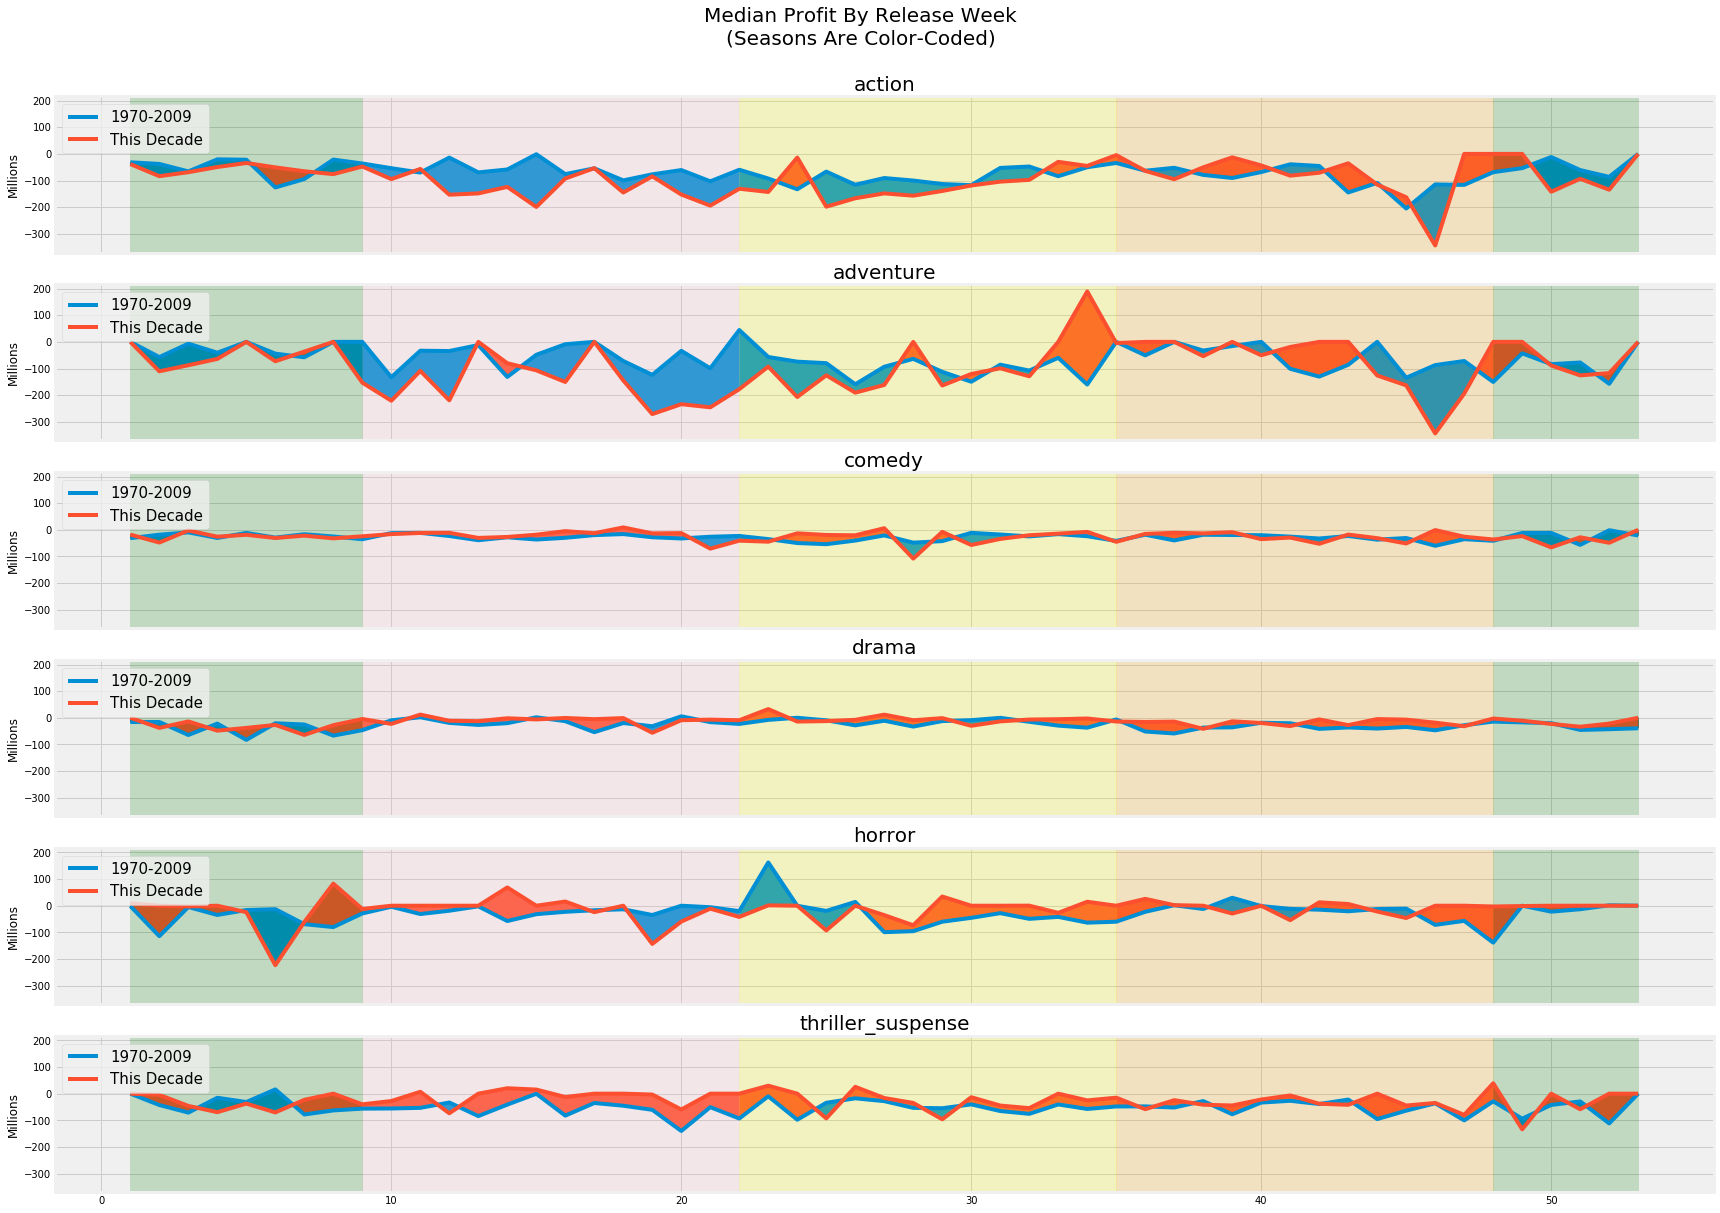

In [101]:
fill_between_by_release_week(data=data, title='Median Profit By Release Week\n(Seasons Are Color-Coded)', 
                             stat='profit', genres=genres, colors=colors, y_label='Millions')

## Quick Takeaways

  - Action and Adventure seem less profitable in Spring and Summer this decade, yet slightly more proftiable in Fall this decade.
  - Comedy and Drama are a little more profitable in most release weeks this decade.
  - Horror and Thriller/Suspense, in general, seem to be more profitable this decade than they were historically.

## Breakeven Percentage

### All-Time

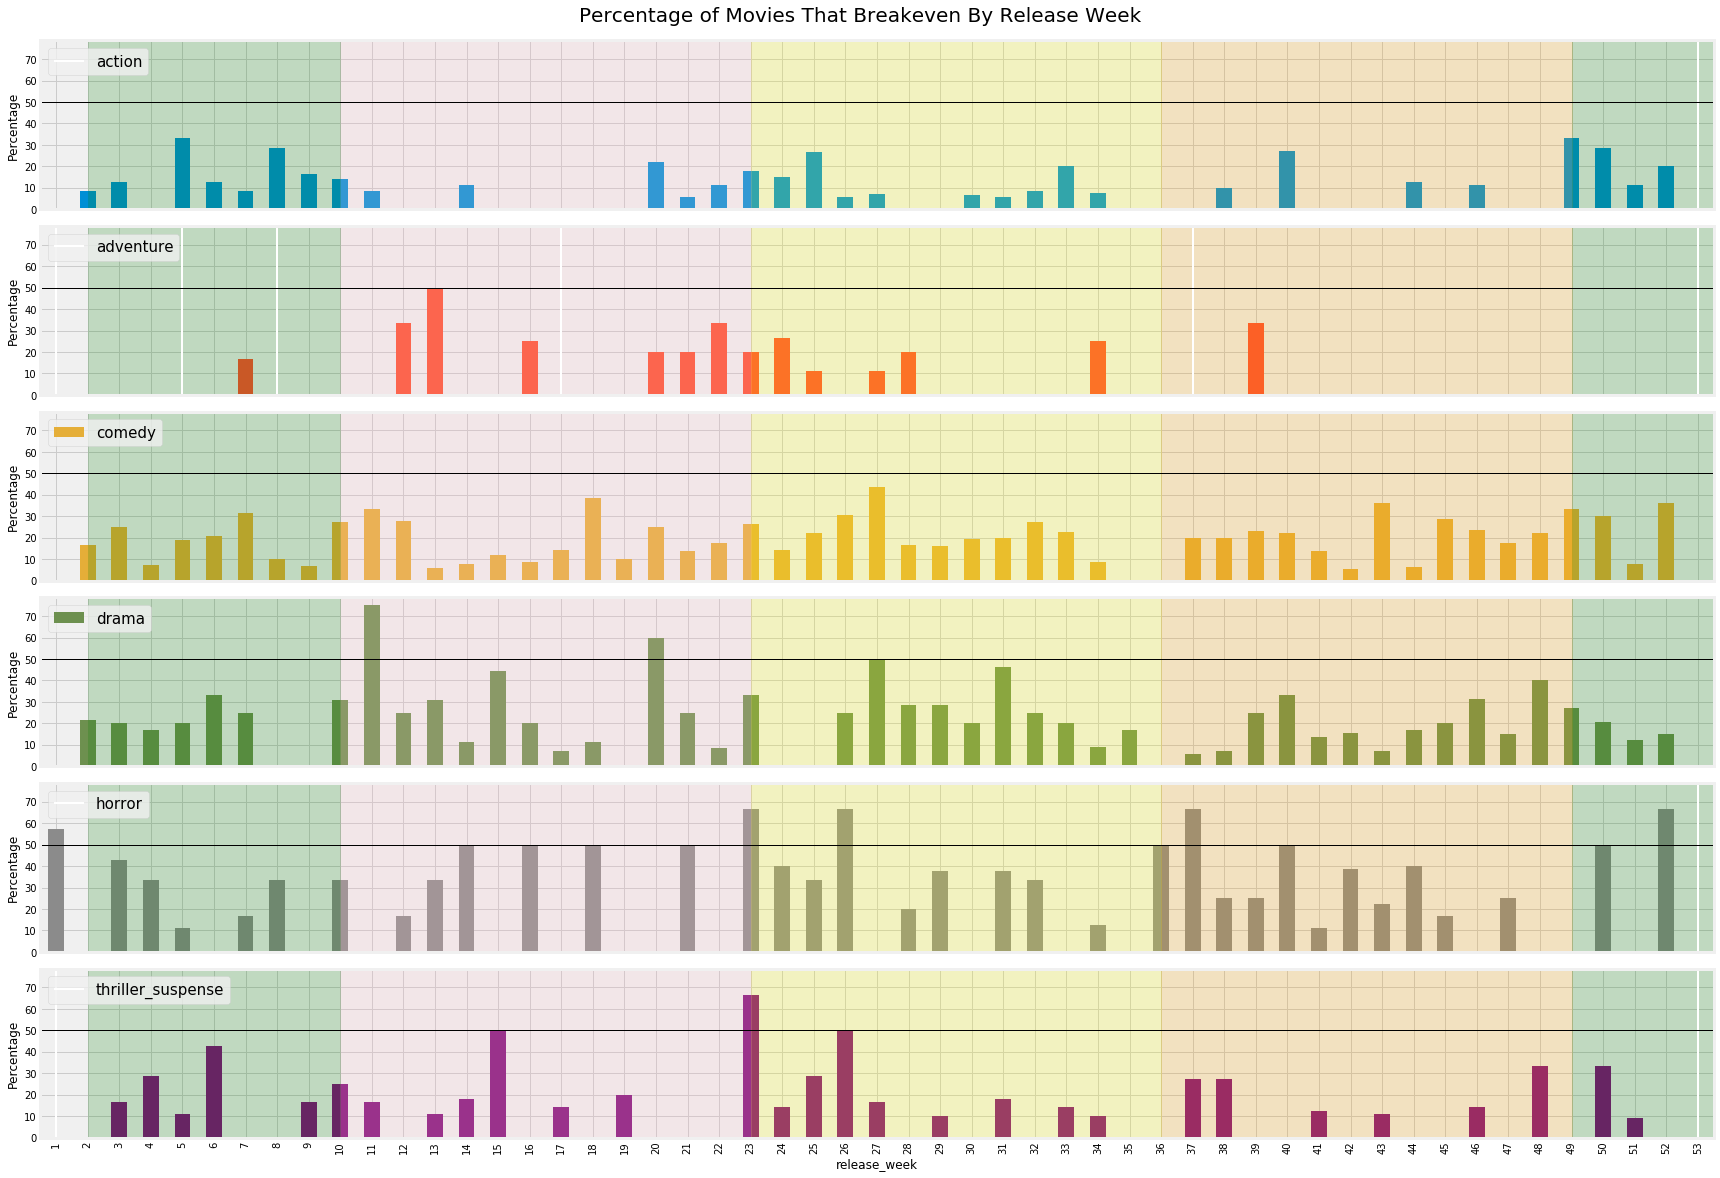

In [102]:
release_weeks_with_no_movies_all_time = [0] * 6
counter = [0, 1, 2, 3, 4, 5]

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week', fontsize=20, y=1.02)

for genre, axis, color, count in zip(genres, axes.flat, colors, counter):
    # Create two series with decades as indexes and count and sum as values
    #grp_count = data[data[genre]].groupby('release_week')['worldwide_breakeven'].count().copy()
    #grp_sum = data[data[genre]].groupby('release_week')['worldwide_breakeven'].sum().copy()
    grp = data[data[genre]].groupby('release_week')['domestic_breakeven'].mean() * 100
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
            axis.axvline(week - 1, color='white', linewidth=2)
            release_weeks_with_no_movies_all_time[count] += 1

    # Sort the series by their index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Show 50% breakeven line
    axis.axhline(50, color='k', linewidth=1)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')
    
plt.tight_layout() 

<div class="alert alert-block alert-info">
    <b>The white vertical lines mean that no movies of that genre have ever been released on that week (in our dataset).</b>
    <br>
    <br>
    <b>The black horizontal line marks the 50% breakeven percentage.</b>
</div>

### Quick Takeaways

There doesn't appear to be any clear patterns with respect to release week and a movie's chance to break even.

### This Decade

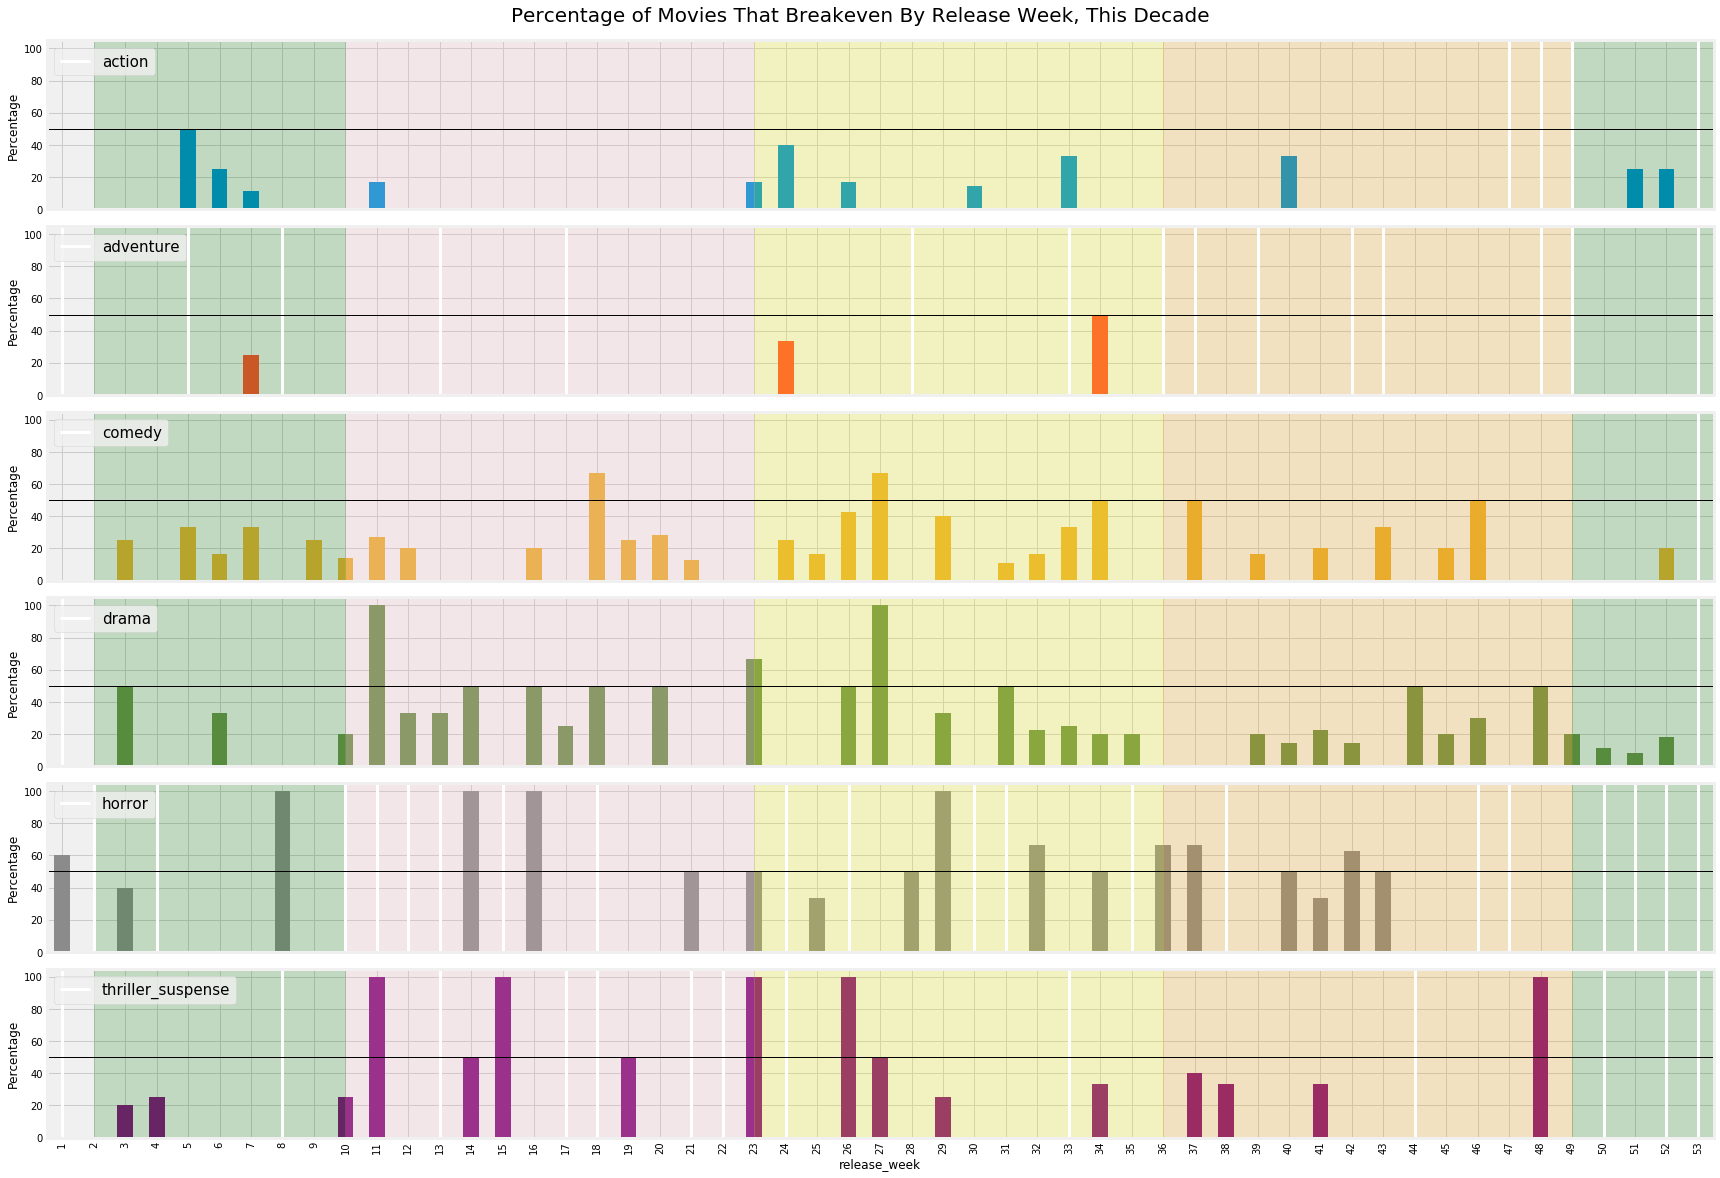

In [103]:
release_weeks_with_no_movies_this_decade = [0] * 6
counter = [0, 1, 2, 3, 4, 5]

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Release Week, This Decade', fontsize=20, y=1.02)

for genre, axis, color, count in zip(genres, axes.flat, colors, counter):
    # Create two series with decades as indexes and count and sum as values
    grp = data[(data['release_year'] >= 2010) & (data[genre])].groupby('release_week')['domestic_breakeven'].mean() * 100
    
    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for week in range(1, 54):
        if week not in grp.index:
            grp.loc[week] = 0
            axis.axvline(week - 1, color='white', linewidth=3)
            release_weeks_with_no_movies_this_decade[count] += 1

    # Sort the series by their index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)

    grp.plot(kind='bar', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Show 50% breakeven line
    axis.axhline(50, color='k', linewidth=1)
    
    axis.axvspan(9, 22, alpha=0.2, color='pink')
    axis.axvspan(22, 35, alpha=0.2, color='yellow')
    axis.axvspan(35, 48, alpha=0.2, color='orange')
    axis.axvspan(48, 53, alpha=0.2, color='green')
    axis.axvspan(1, 9, alpha=0.2, color='green')
    
plt.tight_layout() 

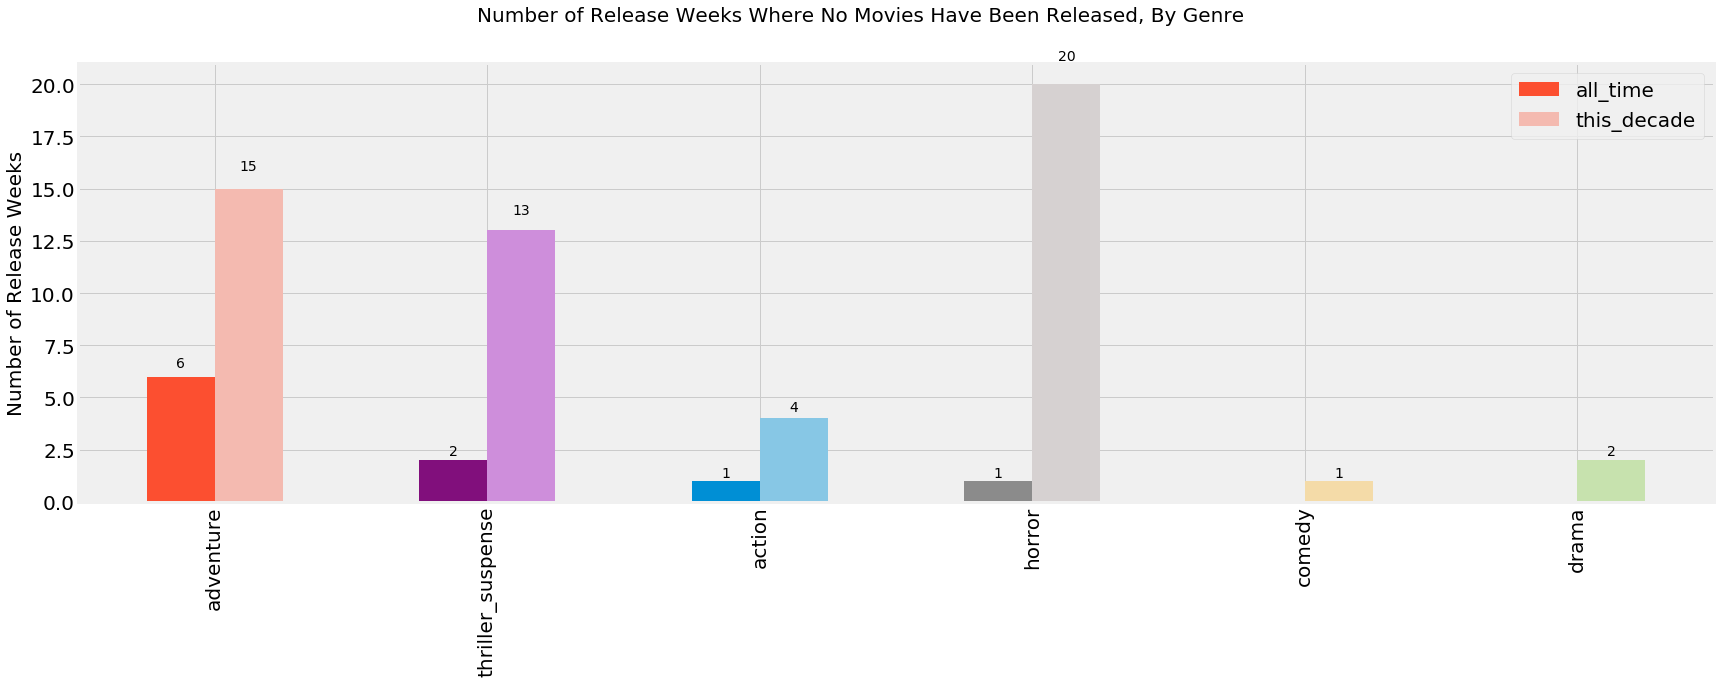

In [104]:
release_week = pd.DataFrame({'all_time': release_weeks_with_no_movies_all_time, 'this_decade': release_weeks_with_no_movies_this_decade}, index=genres)
release_week.sort_values(by='all_time', ascending=False, inplace=True)

color_list = generate_color_list(colors_needed=2, order_list=release_week.index)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Number of Release Weeks Where No Movies Have Been Released, By Genre', fontsize=20, y=1.05)
release_week.plot(kind='bar', ax=axis, color=color_list)
axis.set_ylabel('Number of Release Weeks', fontsize=20)
axis.tick_params(labelsize=20)
axis.legend(fontsize=20)

autolabel(axis, fontsize=14)

plt.tight_layout()

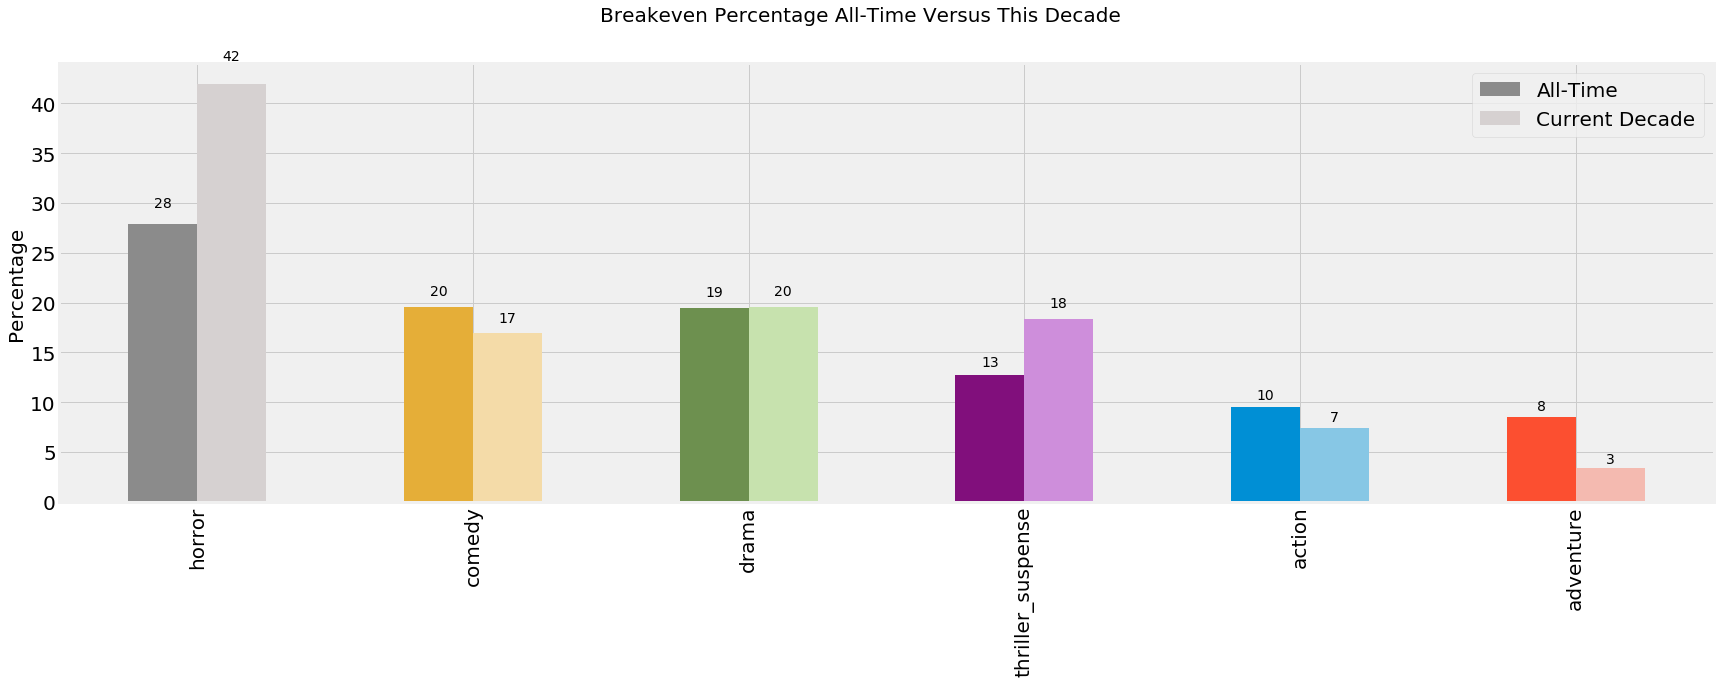

In [105]:
sorted_genres = sorted([{'genre': genre, 'amount': (summary['breakeven_percentage'][genre])} for genre in genres], key=lambda k: k['amount'], reverse=True)
genres_list = [item['genre'] for item in sorted_genres]
color_list = generate_color_list(colors_needed=2, order_list=genres_list)

figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 9))
figure.suptitle('Breakeven Percentage All-Time Versus This Decade', fontsize=20, y=1.05)
summary.reindex(genres_list).plot(y=['breakeven_percentage', 'current_decade_breakeven_percentage'], kind='bar', color=color_list, ax=axis)

axis.set_ylabel('Percentage', fontsize=20)
axis.tick_params(labelsize=20)
axis.legend(['All-Time', 'Current Decade'], fontsize=20)

autolabel(axis, fontsize=14)

plt.tight_layout()

### Quick Takeaways

  - It seems fewer release weeks are being utilized for some genres.
  - This might be coincidence, or it might be that studios don't think certain weeks work for some genres. 
  - In this decade, there are 20 weeks out of the year where a Horror movie hasn't been released!
  - In second place is Adventure with 15 missing weeks, then Thriller/Suspense with 13.
  - Some genres have a better chance of breaking even at the domestic box office this decade compared to their historical levels. These include Horror, Drama, and Thriller/Suspense.
  - Action and Adventure have the lowest chances of breaking even at the domestic box office this decade.

### Breakeven Percentage By Decade

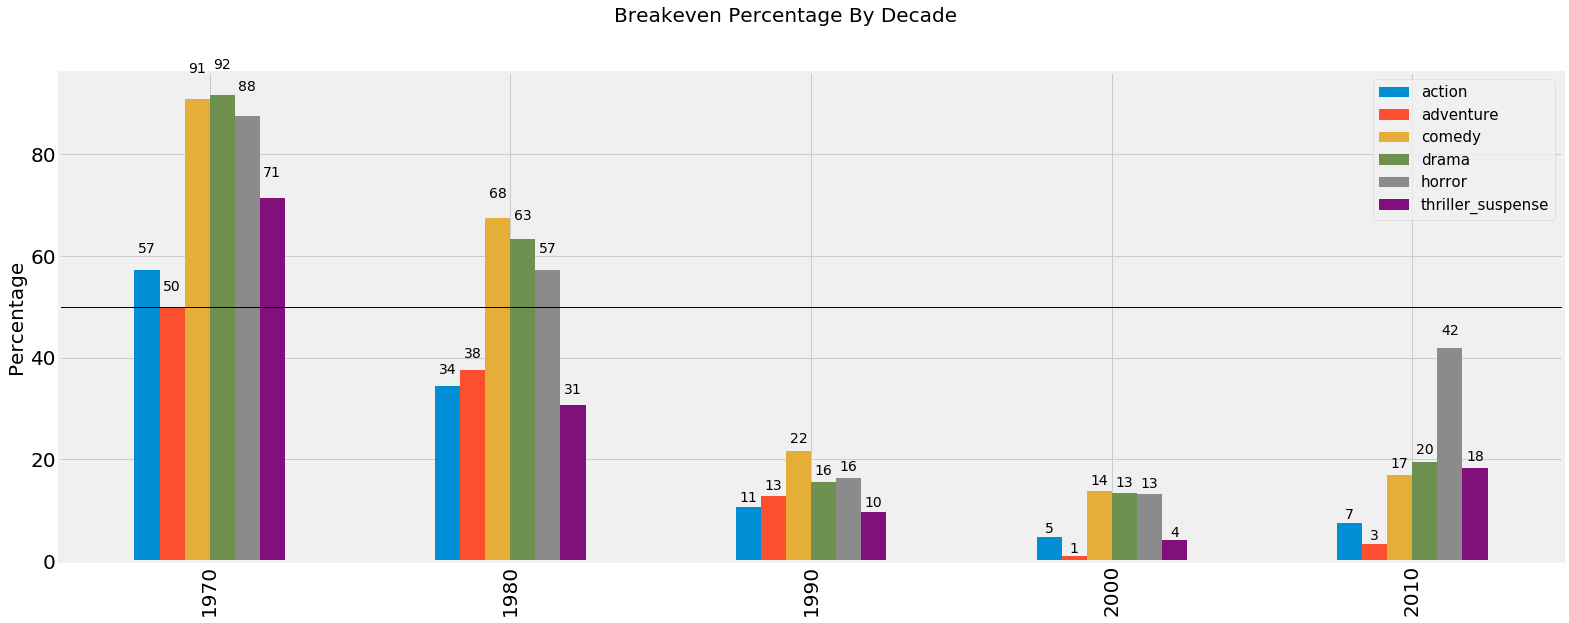

In [106]:
plot_by_time_and_stat(data=data, genres=genres, title='Breakeven Percentage By Decade', 
                      groupby_column='release_decade', stat_columns=breakeven_columns, 
                      aggregate_function='mean', apply_needed=True, apply_function=lambda x: x * 100, 
                      y_label='Percentage', y_ticks_needed=False, y_ticks='', legend_needed=True, 
                      legend_text=genres, color=colors, axhline_needed=True, axhline_value=50, autolabel_needed=True, autolabel_fontsize=14)

### Quick Takeaways

**Current Decade**

  - Every genre has seen an uptick in its probability of breaking even from the 2000s to the 2010s.
  - One explanation could be that since fewer movies are released overall, there's less competition at the theaters. If the same number of dollars chase fewer movies, then more movies will be profitable.
  - Horror went from a 13% chance of breaking even in the 2000s to a 42% chance in the 2010s. In the current decade, the next closest genre is Drama with a 20% chance of breaking even.

## Summary

  - Action and Adventure are currently performing worse this decade than they have historically across many release weeks.
    - They have higher median grosses for most release weeks, but also have higher median budgets as well. This results in lower median profits for most release weeks.
    - The exception for Action and Adventure is Fall, where both genres seem to be more profitable this decade compared to their historical levels.
    - Conversely, both Horror and Thriller/Suspense have lower median grosses and lower median budgets across most release weeks, yet still tend to perform better this decade than historically from a median profitability perspective.
  - Horror, Adventure, and Thriller/Suspense have been released on the fewest weeks this decade.
  - All genres have a higher breakeven percentage this decade than in the 2000s.

# Conclusions, Conclusions, Conclusions

## Summing Up

**Safest**
  - I would classify no genre as safe. All genres historically have negative median profit. 
  - Just looking at this decade, all genres still have negative median profit. The best performing genres in this regard are Horror (<span style='color:red'>-&#0036;6.2 million</span>), Drama (<span style='color:red'>-&#0036;15.3 million</span>), and Comedy (<span style='color:red'>-&#0036;21.9 million</span>). 
  - With a very low median production budget (&#0036;18 million) and the highest chance of breaking even this decade (42%), Horror seems like the safest genre to invest in.
  - Note that historically Horror is one of the least produced genres (including this decade with only 74 movies released). It has had the third highest median domestic gross since the 2000s. In this decade, the top three highest median grossers are Adventure (<span>&#0036;</span>163 million), Action (<span>&#0036;</span>104 million), then Horror (<span>&#0036;</span>52 million).
  - It doesn't seem like the Horror market is oversaturated. It has followed the same trajectory in terms of number of movies produced as any other genre. Perhaps studios intentionally limit their Horror exposure. For example, if people associate a studio with Horror movies, they might be less inclined to see its other movies due to Horror's reputation as a low quality product (bad writing, bad acting, low budget, bad visuals).

**Highest potential return per movie**
  - If our bosses want to maximize their return per movie, then either Action or Adventure are the best. They carry with them much higher production budgets, but also gross higher amounts than all other genres.

**Most calendar-friendly**
  - Comedies are the least affected by release week as they are released in solid numbers on practically every week of the year. If we want maximum flexibility there (for example, to avoid opening the same weekend as another big movie and thus incurring higher marketing costs), we can plug and play a Comedy into almost any week.
  - Most Dramas are released in Fall. 
  - Most Action movies are released in Summer.
  - Overall, across all release weeks, the best performers in terms of median gross this decade are Action/Adventure, then Comedy/Drama, then Horror/Thriller/Suspense. However, in terms of median profits by release week, the order is reversed. This is because the median budgets for Action/Adventure have increased by a fair margin this decade, whereas budgets for the other genres are either static (Comedy) or lower (Drama/Horror/Thriller/Suspense). 


## Final Recommendations

### If we don't mind being associated with Horror movies

Then Horror, Horror, Horror.

There's a pretty good reason [Blumhouse](https://en.wikipedia.org/wiki/Blumhouse_Productions) is doing so well. It makes high quality movies that are inexpensive to produce. It's basically impossible to do that with Action or Adventure movies, but it can be done with Horror. Other studios could mimic Blumhouse's business model with the least expensive genres.

**Median Budgets This Decade**
  - Horror: &#0036;18 million
  - Drama: &#0036;22 million
  - Comedy: &#0036;33 million
  - Thriller/Suspense: &#0036;36 million
  - Action: &#0036;116 million
  - Adventure: &#0036;173 million
  
How many movies could we make for the same price as a typical Action or Adventure movie (not including marketing costs)?

**Number of movies per one Action movie**
  - Horror: 6.4 movies
  - Drama: 5.3 movies
  - Comedy: 3.5 movies
  - Thriller/Suspense: 3.2 movies

**Number of movies per one Adventure movie**  
  - Horror:            9.6 movies
  - Drama:             7.9 movies
  - Comedy:            5.2 movies
  - Thriller/Suspense: 4.8 movies
  
Then what's the problem? Why can't we make these low to mid budget movies at a fraction of the cost and make money on them?

**The Streaming Problem**
  - It's entirely possible that Horror is the only inexpensive genre that audiences will still go to theaters for.
  - Many Drama, Comedy, and Thriller/Suspense movies that historically would have had a theatrical release are instead headed directly to streaming platforms like Netflix.
  - It might be that the concept and execution have to be much higher in these other genres than they do for Horror. After all, audiences seem willing to support a level of shlockiness in Horror movies that they won't in other genres. 
  - The financial upside may not be high enough to produce the other genres theatrically.
  
**Median Grosses This Decade**
  - Drama: &#0036;29 million
  - Thriller/Suspense: &#0036;43 million
  - Comedy: &#0036;48 million
  - Horror: &#0036;52 million
  - Action: &#0036;104 million
  - Adventure: &#0036;163 million
 
Currently, Drama, Comedy, and Thriller/Suspense might be too expensive theatrically but cheap enough for streaming. Even though they have much smaller budgets, the amount of marketing dollars to wide release a movie is substantial if you aren't great at viral marketing campaigns. Blumhose is particularly good at getting the most for their marketing dollar.

Studios may be shifting a lot of low budget fare to streaming platforms, where they get predetermined fees for their content and save big on marketing dollars. 

### If we don't want anything to do with Horror movies

The writing seems to be on the wall. Action and Adventure are the only other genres that are doing well this decade. They tend to travel well, which means the explosion in the foreign box office market bodes well for them. 

They are the most expensive genres to produce and market, but they are the big winners in terms of box office dollars.

## Parting Thoughts and Next Steps

Our dataset only includes revenue that movies generate from ticket sales, but that is only a slice of the movie revenue pie.

Stephen Follows has a [great article](https://stephenfollows.com/how-movies-make-money-hollywood-blockbusters/) detailing the revenue stream of movies nowadays. The following image comes from his article.

![Movie Revenue Stream](movie_money_chart.png)

To summarize, the release windows are:
  - Theatrical - movie theaters
  - Airlines and Hospitality - airplanes and hotels
  - Home Entertainment - purchase and rental of DVDs and Blu-ray
  - Video on Demand - these include several types
    - Transactional (TVOD) - purchase and rental of electronic copies from iTunes, Amazon, Google Play, etc.
    - Subscription (SVOD) - Netflix, HBO Now, YouTube TV, Amazon Video, Hulu Plus, etc.
    - Ad-funded (AVOD) - Hulu, Vudu, YouTube, etc.
  - Television - various forms
    - Pay TV (premium channels like HBO, Starz, Epix)
    - Free-to-air/Broadcast channels like BBC One, ABC, NBC, CBS, Fox, etc.
    - Syndication on digital channels like AMC, FX, TMC, TNT, etc.
  - Merchandising - products consumers buy like toys, games, clothes, etc.
  - Product Placement - charging brands to feature products in movies
  
Many of these later release windows gain higher license fees if a movie is successful at the box office, making the theatrical window very important. On the other hand, theatrical isn't the only moneymaker, and movies can make up for lackluster box office with future revenue streams.

Here are some next steps to spruce up our analyis: 
  - Getting access to data from other release windows to get the full financial scope of each movie.
  - Dive deeper into analyzing movies by budget size (for example, analyzing subgenres by budget size).
  - Analyzing movies based on distributor.
  - Analyzing movies based on key talent (such as actors, directors, etc.).
  - Instead of looking at profit, using a metric like the ratio of worldwide gross to budget to eliminate dealing with sums involving negative numbers.
  
We have only scratched the surface in our analysis here, but our results provide very actionable insight. Genres that travel well (Action and Adventure) are earning the most these days, and Horror, due to its low cost and consistently good box office results, is a great genre to invest in.